### Setup

In [602]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency


import importlib
import utils
# Cache-Probleme umgehen
importlib.reload(utils)

from utils import hex_to_rgb_normalized
from utils import categorize_skewness
from utils import shapiro_wilk_test
from utils import find_similar_rows

In [603]:
# Farben für Diagramme
color1 = '#9794E4' # Helllila
color2 = '#06507F' # Dunkelblau
color3 = '#5F0607' # Dunkelrot
color4 = '#3E0E4B' # Lila
color5 = '#D5E1F8' # Hellblau

### Data load

In [604]:
df_test = pd.read_csv('../data/raw/triathlon_watch_test_data_final.csv')
df_training = pd.read_csv('../data/raw/triathlon_watch_training_data_final.csv')

### First Look Data

In [605]:
df_training.head()

ID  Age of customer    Sex       Ctry        Town  \
0  C0001             61.0  Other         UK  Birmingham   
1  C0003             57.0  Other  Australia      Sydney   
2  C0004             30.0  Other      India   Bangalore   
3  C0005             21.0   Male    Germany      Munich   
4  C0006             63.0   Male      India      Mumbai   

   Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
0                     2.52                   0.10                    1.78   
1                     1.55                  10.01                    4.57   
2                     1.19                  12.04                    8.64   
3                     2.25                   4.67                    0.92   
4                     0.80                   5.88                    0.67   

   Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
0                           4.40    23.08                        60.72   
1                          16.13    39.04                        54.37   
2                          21.87    71.59                        33.92   
3                           7.84    49.09                        44.97   
4                           7.35    13.91                        62.46   

   Calories Burned per Week  Support Cases of Customer  Customer Years  \
0                   2329.95                        2.0             1.0   
1                   7904.93                        2.0             1.0   
2                  10839.81                        2.0             0.0   
3                       NaN                        3.0             0.0   
4                   3575.96                        3.0             3.0   

  Most current software update Goal of Training Preferred Training Daytime  \
0                   2024-07-22          Fitness                    Evening   
1                   2024-05-11          Fitness                    Evening   
2                   2024-08-16      Competition                  Afternoon   
3                   2024-08-11       Recreation                    Evening   
4                   2024-11-18       Recreation                    Morning   

  Subscription Type Color of Watch Synchronisation  User of latest model  
0              Free          White             Yes                   1.0  
1           Premium          Black             Yes                   0.0  
2              Free          White             Yes                   1.0  
3           Premium          Black              No                   1.0  
4             Basic          Black             Yes                   0.0

In [606]:
df_training.tail()

ID  Age of customer     Sex       Ctry       Town  \
995  C0996             28.0  Female  Australia   Brisbane   
996  C0997             54.0  Female  Australia  Melbourne   
997  C0998             35.0   Other        USA   New York   
998  C0999             31.0   Other    Germayn     Berlin   
999  C1000             27.0    Male      India     Mumbai   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
995                     2.38                   0.28                    2.79   
996                     1.80                   4.45                    1.35   
997                     3.91                   0.57                    5.57   
998                     0.36                   4.63                    5.16   
999                     0.43                   7.46                    5.55   

     Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
995                           5.46    61.05                        40.38   
996                           7.61    34.50                        56.38   
997                          10.05    58.63                        37.27   
998                          10.15    66.46                        37.98   
999                          13.44    61.81                        36.07   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
995                   2589.77                        0.0             3.0   
996                   4104.15                        0.0             3.0   
997                   5078.45                        4.0             6.0   
998                   5184.27                        3.0             3.0   
999                   6827.69                        0.0             7.0   

    Most current software update Goal of Training Preferred Training Daytime  \
995                   2024-01-09       Recreation                    Morning   
996                   2024-11-09       Recreation                  Afternoon   
997                   2024-08-27          Fitness                  Afternoon   
998                   2024-06-19          Fitness                    Evening   
999                   2024-06-04          Fitness                  Afternoon   

    Subscription Type Color of Watch Synchronisation  User of latest model  
995           Premium          Black             Yes                   0.0  
996              Free          Black             Yes                   0.0  
997           Premium          Black             Yes                   1.0  
998              Free          Black             NaN                   1.0  
999           Premium          Black             Yes                   0.0

In [607]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   ID                             978 non-null    object 
 1   Age of customer                978 non-null    float64
 2   Sex                            978 non-null    object 
 3   Ctry                           978 non-null    object 
 4   Town                           939 non-null    object 
 5   Swimming Hours per Week        978 non-null    float64
 6   Biking Hours per Week          954 non-null    float64
 7   Running Hours per Week         978 non-null    float64
 8   Total Training Hours per Week  978 non-null    float64
 9   VO2 Max                        975 non-null    float64
 10  10k Running Time Prediction    978 non-null    float64
 11  Calories Burned per Week       959 non-null    float64
 12  Support Cases of Customer      978 non-null    fl

In [608]:
df_training.shape

(1000, 21)

### Missing/Unplausible Values

<Axes: >

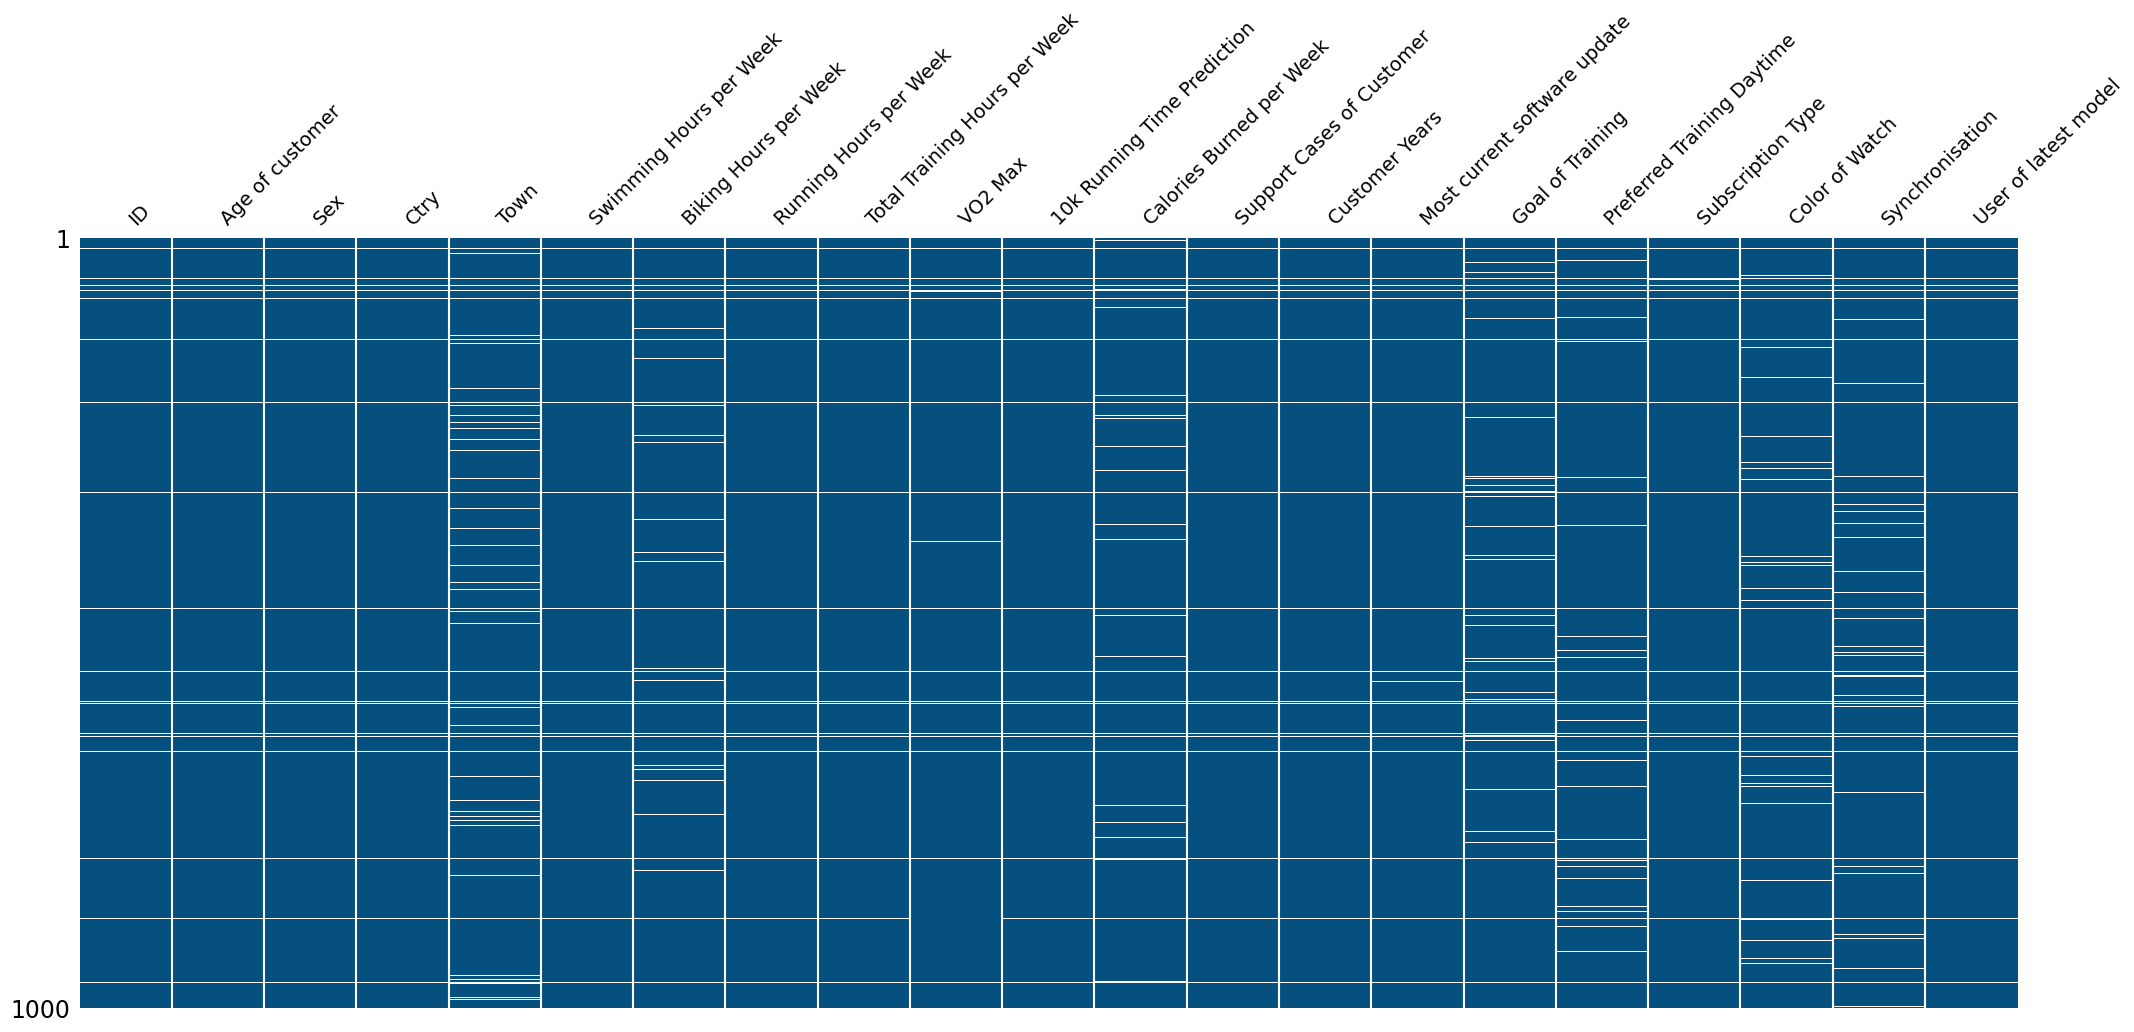

In [609]:
msno.matrix(df_training, color= hex_to_rgb_normalized(color2), fontsize=14, sparkline=False)

Durch die Visualisierung ist bereits gut zu erkennen, dass teilweise komplette Zeilen NaN Werte beinhalten. Diese sollten entfernt werden.

In [610]:
count_missing_values = pd.DataFrame(df_training.isnull().sum().sort_values(ascending=False))
count_missing_values.columns = ['Anzahl fehlender Werte']
count_missing_values

Anzahl fehlender Werte
Town                                               61
Color of Watch                                     54
Goal of Training                                   50
Synchronisation                                    50
Biking Hours per Week                              46
Preferred Training Daytime                         46
Calories Burned per Week                           41
VO2 Max                                            25
Subscription Type                                  23
Most current software update                       23
Sex                                                22
Age of customer                                    22
ID                                                 22
Ctry                                               22
Support Cases of Customer                          22
Running Hours per Week                             22
Total Training Hours per Week                      22
Swimming Hours per Week                            22
10k Running Time Prediction                        22
Customer Years                                     22
User of latest model                               22

Die Zeilen, indem das Label **User of latest model** fehlt, sollten entfernt werden.

In [611]:
count_missing_values_label = pd.DataFrame(df_training[df_training['User of latest model'].isnull()].isnull().sum().sort_values(ascending=False))
count_missing_values_label.columns = ['Anzahl fehlender Werte, wenn Label fehlt']
count_missing_values_label

Anzahl fehlender Werte, wenn Label fehlt
ID                                                                   22
Age of customer                                                      22
Sex                                                                  22
Ctry                                                                 22
Town                                                                 22
Swimming Hours per Week                                              22
Biking Hours per Week                                                22
Running Hours per Week                                               22
Total Training Hours per Week                                        22
10k Running Time Prediction                                          22
Calories Burned per Week                                             22
Support Cases of Customer                                            22
Customer Years                                                       22
Subscription Type                                                    22
Most current software update                                         22
Goal of Training                                                     22
Preferred Training Daytime                                           22
Synchronisation                                                      22
Color of Watch                                                       22
User of latest model                                                 22
VO2 Max                                                              21

Bis auf einem Wert in Spalte `VO2 Max` sind alle anderen Spalten komplett leer, wenn das Label fehlt. Diese Zeilen sollten also gelöscht werden.

In [612]:
missing_values_summary = count_missing_values.join(count_missing_values_label)

In [613]:
missing_values_summary['Anzahl fehlender Werte nach entfernen der leeren Zeilen des Labels'] = missing_values_summary['Anzahl fehlender Werte'] - missing_values_summary['Anzahl fehlender Werte, wenn Label fehlt']
missing_values_summary

Anzahl fehlender Werte  \
Town                                               61   
Color of Watch                                     54   
Goal of Training                                   50   
Synchronisation                                    50   
Biking Hours per Week                              46   
Preferred Training Daytime                         46   
Calories Burned per Week                           41   
VO2 Max                                            25   
Subscription Type                                  23   
Most current software update                       23   
Sex                                                22   
Age of customer                                    22   
ID                                                 22   
Ctry                                               22   
Support Cases of Customer                          22   
Running Hours per Week                             22   
Total Training Hours per Week                      22   
Swimming Hours per Week                            22   
10k Running Time Prediction                        22   
Customer Years                                     22   
User of latest model                               22   

                               Anzahl fehlender Werte, wenn Label fehlt  \
Town                                                                 22   
Color of Watch                                                       22   
Goal of Training                                                     22   
Synchronisation                                                      22   
Biking Hours per Week                                                22   
Preferred Training Daytime                                           22   
Calories Burned per Week                                             22   
VO2 Max                                                              21   
Subscription Type                                                    22   
Most current software update                                         22   
Sex                                                                  22   
Age of customer                                                      22   
ID                                                                   22   
Ctry                                                                 22   
Support Cases of Customer                                            22   
Running Hours per Week                                               22   
Total Training Hours per Week                                        22   
Swimming Hours per Week                                              22   
10k Running Time Prediction                                          22   
Customer Years                                                       22   
User of latest model                                                 22   

                               Anzahl fehlender Werte nach entfernen der leeren Zeilen des Labels  
Town                                                                          39                   
Color of Watch                                                                32                   
Goal of Training                                                              28                   
Synchronisation                                                               28                   
Biking Hours per Week                                                         24                   
Preferred Training Daytime                                                    24                   
Calories Burned per Week                                                      19                   
VO2 Max                                                                        4                   
Subscription Type                                                              1                   
Most current software update                                                   1                   
Sex                      

In [614]:
missing_values_summary['Anzahl fehlender Werte nach entfernen der leeren Zeilen des Labels'].sum()

np.int64(200)

Nach Löschung der Zeilen, in denen das Label fehlt gibt es noch 200 fehlende Werte im kompletten Datensatz.

In [615]:
df_training[(df_training.isnull().sum(axis=1) > 2) & (df_training['User of latest model'].notnull())]

Empty DataFrame
Columns: [ID, Age of customer, Sex, Ctry, Town, Swimming Hours per Week, Biking Hours per Week, Running Hours per Week, Total Training Hours per Week, VO2 Max, 10k Running Time Prediction, Calories Burned per Week, Support Cases of Customer, Customer Years, Most current software update, Goal of Training, Preferred Training Daytime, Subscription Type, Color of Watch, Synchronisation, User of latest model]
Index: []

In [616]:
df_training[(df_training.isnull().sum(axis=1) > 1) & (df_training['User of latest model'].notnull())]

ID  Age of customer     Sex       Ctry       Town  \
217  C0217             -1.0  Female      India        NaN   
230  C0230             38.0   Other         UK        NaN   
309  C0310             64.0    Male    Germany     Berlin   
312  C0313             28.0   Other        USA        NaN   
425  C0426             29.0   Other         UK        NaN   
490  C0491             20.0  Female  Australia     Sydney   
712  C0707             19.0   Other  Australia  Melbourne   
719  C0714             31.0  Female  Australia  Melbourne   
816  C0816             59.0    Male      India      Delhi   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
217                     2.31                    NaN                    4.43   
230                     1.84                   3.69                    1.01   
309                     2.04                   1.77                    6.56   
312                     0.00                   9.84                    5.78   
425                     2.70                   5.21                    2.13   
490                     2.45                   4.73                    6.53   
712                     2.62                   7.40                    1.60   
719                     3.05                    NaN                    5.22   
816                     0.82                   4.92                    1.95   

     Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
217                          13.33    40.33                        52.93   
230                           6.53    58.59                        41.17   
309                          10.37    18.90                        56.92   
312                          15.62    67.25                        34.65   
425                          10.04    57.51                        43.48   
490                          13.71    59.61                        36.21   
712                          11.62    54.03                        40.65   
719                          10.77    63.79                        36.19   
816                           7.70    26.12                        55.87   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
217                   6736.52                        0.0             6.0   
230                       NaN                        1.0             8.0   
309                   5254.97                        4.0             1.0   
312                   8037.13                        3.0             3.0   
425                   4775.57                        3.0             2.0   
490                       NaN                        3.0             2.0   
712                   5962.87                        4.0             1.0   
719                   5525.89                        3.0             5.0   
816                   4063.31                        4.0             3.0   

    Most current software update Goal of Training Preferred Training Daytime  \
217                   2024-05-10          Fitness                    Evening   
230                   2023-12-19       Recreation                    Evening   
309                   2024-06-07              NaN                  Afternoon   
312                   2024-04-01              NaN                  Afternoon   
425                   2024-02-28      Competition                    Morning   
490                   2024-11-26              NaN                    Morning   
712                   2024-07-17          Fitness                        NaN   
719                   2024-05-30              NaN                    Morning   
816                   2024-12-08          Fitness                        NaN   

    Subscription Type Color of Watch Synchronisation  User of latest model  
217              Free          Black             Yes                   0.0  
230              Free          Black             Yes                   0.0  
309             Basic          Black             NaN

Wenn die Zeilen gelöscht werden, in denen das Label NaN ist, wird keine weitere zeilenweise Löschung empfohlen. Es tritt kein Fall auf, bei dem innerhalb einer Zeile mehr als 2 Werte fehlen. Eine einfache Löschung dieser Zeilen, würde zu viele Informationen eleminieren. Für das Füllen der restlichen 200 fehlenden Werte muss eine andere Taktik verwendet werden.

In [617]:
# Betrachtung der Spalten, in denen nach der zeilenweisen Löschung noch fehlende Werte vorhanden sind
filtered_df = df_training[(df_training.isnull().sum(axis=1) > 0) & (df_training['User of latest model'].notnull())]
filtered_df[filtered_df.columns[filtered_df.isnull().any()]]

Town  Biking Hours per Week   VO2 Max  Calories Burned per Week  \
3        Munich                   4.67   49.0900                       NaN   
6           NaN                   4.06  247.2578                   4835.71   
20          NaN                  10.88   25.6600                   6184.35   
29     Brisbane                  11.39   65.3100                  10017.66   
31       Mumbai                  11.48   45.9500                   9604.77   
..          ...                    ...       ...                       ...   
984      Berlin                   0.62   55.1000                   3192.00   
986         NaN                   3.35   56.3100                   4031.71   
988         NaN                   2.89   60.0800                   4700.03   
989  Birmingham                   9.52   57.0100                   8858.12   
998      Berlin                   4.63   66.4600                   5184.27   

    Most current software update Goal of Training Preferred Training Daytime  \
3                     2024-08-11       Recreation                    Evening   
6                     2024-02-03       Recreation                  Afternoon   
20                    2023-11-10      Competition                    Evening   
29                    2024-09-13      Competition                        NaN   
31                    2023-12-30              NaN                  Afternoon   
..                           ...              ...                        ...   
984                   2023-12-02       Recreation                    Morning   
986                   2024-02-19       Recreation                    Morning   
988                   2024-01-07          Fitness                    Morning   
989                   2024-08-14          Fitness                        NaN   
998                   2024-06-19          Fitness                    Evening   

    Subscription Type Color of Watch Synchronisation  
3             Premium          Black              No  
6                Free          Black             Yes  
20            Premium          Black             Yes  
29              Basic          Black             Yes  
31              Basic          Black             Yes  
..                ...            ...             ...  
984              Free          White             NaN  
986           Premium          Black             Yes  
988           Premium          White             Yes  
989           Premium          White             Yes  
998              Free          Black             NaN  

[191 rows x 10 columns]

- Die Spalten `VO2 Max`, `Calories Burned per Week` sind numerisch und auf den ersten Blick ist kein direkter Zusammenhang mit anderen Spalten erkennbar, der ein regelbasiertes Verfahren rechtfertigen würde. Hier könnte es Sinn machen, eine Regression Imputation zu verwenden, falls sich in der nachfolgenden EDA aufzeigt, dass diese Werte mit anderen korrelieren.
- Die Spalte `Biking Hours per Week` kann direkt aus den anderen Spalten `Swimming Hours per Week`, `Running Hours per Week` und `Total Training Hours per Week` berechnet werden.
- Für die Spalte `Town` könnte eine regelbasierte Imputation angewandt werden. Je nach Land (`Ctry`) sind nur bestimmte Städte in der Kombination möglich.
- Für die restlichen Spalten kann erst eine Empfehlung gegeben werden, nach weiterer Sichtung der Daten.

In [618]:
# Eindeutige Kombinationen von 'Ctry' und 'Town' zählen
unique_combinations = (
    df_training
    .groupby(['Ctry', 'Town'], dropna=False) # Schließt beim Groupby NaN-Werte ein
    .size()  # Zählen der Häufigkeiten
    .reset_index(name='Count')  # Zurücksetzen des Index und Spalte 'Count' benennen
)
unique_combinations.sort_values(by=['Ctry', 'Count'], ascending=False).reset_index(drop=True)

Ctry         Town  Count
0   UnknownLand       Berlin      1
1   UnknownLand     Brisbane      1
2   UnknownLand       London      1
3   UnknownLand          NaN      1
4           USA     New York     72
5           USA      Chicago     64
6           USA  Los Angeles     56
7           USA          NaN      7
8            UK   Birmingham     70
9            UK   Manchester     58
10           UK       London     51
11           UK          NaN     12
12        India    Bangalore     64
13        India       Mumbai     59
14        India        Delhi     56
15        India          NaN      7
16      Germayn       Berlin      8
17      Germayn      Hamburg      8
18      Germayn       Munich      2
19      Germayn          NaN      1
20      Germany       Berlin     67
21      Germany       Munich     58
22      Germany      Hamburg     51
23      Germany          NaN      3
24    Australia    Melbourne     70
25    Australia     Brisbane     62
26    Australia       Sydney     60
27    Australia          NaN      8
28          NaN          NaN     22

Hier wird deutlich, dass bspw. eine fehlende Stadt mit dem Land `Australia`, nur die Werte `Sydney`, `Melbourne` oder `Brisbane` annehmen kann. Je nach Zusammenhang mit den anderen Spalten, kann aufgrund anderer Informationen besser entschieden werden, welche von den 3 Möglichkeiten die sinnvollste ist.  
Die Übersicht zeigt ebenfalls, dass innerhalb des Datensatzes auch unplausible Werte auftreten können wie `UnknownLand` oder `Germayn`. Daher werden die Spalten, mit wenig Ausprägungen im Folgenden noch auf unplausible Werte untersucht.

Um den Fehler `UnknownLand` zu beheben, kann eine umgekehrte Logik wie für die Imputation von `Town` angewendet werden. 
- Berlin &rarr; Germany
- London &rarr; UK
- Brisbane &rarr; Australia 

`Germayn` sollte zu `Germany` umgeändert werden.

Diese Anpassungen sollte vor der Imputation von Town erfolgen, da man so mehr Informationen gewinnt.

In [619]:
# Anzahl eindeutiger Werte pro Spalte
for col in df_training.columns:
    unique_count = df_training[col].nunique()
    print(f"Spalte: {col}, Anzahl eindeutiger Werte: {unique_count}")

Spalte: ID, Anzahl eindeutiger Werte: 971
Spalte: Age of customer, Anzahl eindeutiger Werte: 48
Spalte: Sex, Anzahl eindeutiger Werte: 3
Spalte: Ctry, Anzahl eindeutiger Werte: 7
Spalte: Town, Anzahl eindeutiger Werte: 15
Spalte: Swimming Hours per Week, Anzahl eindeutiger Werte: 440
Spalte: Biking Hours per Week, Anzahl eindeutiger Werte: 649
Spalte: Running Hours per Week, Anzahl eindeutiger Werte: 542
Spalte: Total Training Hours per Week, Anzahl eindeutiger Werte: 732
Spalte: VO2 Max, Anzahl eindeutiger Werte: 858
Spalte: 10k Running Time Prediction, Anzahl eindeutiger Werte: 805
Spalte: Calories Burned per Week, Anzahl eindeutiger Werte: 948
Spalte: Support Cases of Customer, Anzahl eindeutiger Werte: 5
Spalte: Customer Years, Anzahl eindeutiger Werte: 12
Spalte: Most current software update, Anzahl eindeutiger Werte: 393
Spalte: Goal of Training, Anzahl eindeutiger Werte: 3
Spalte: Preferred Training Daytime, Anzahl eindeutiger Werte: 3
Spalte: Subscription Type, Anzahl eindeutig

In [620]:
#Ausgabe der eindeutigen Werte für Spalten mit weniger als 50 eindeutigen Werten
for col in df_training.columns:
    unique_count = df_training[col].nunique()
    if unique_count < 50:  
        unique_values = df_training[col].unique()

        # Umwandlung der Werte in native Python-Typen, damit es im Print-Output besser aussieht
        unique_values_converted = [float(x) if isinstance(x, np.float64) else x for x in unique_values]

        # NaN-Werte an das Ende verschieben und sortieren
        unique_values_sorted = sorted(unique_values_converted, key=lambda x: (isinstance(x, float) and np.isnan(x), x))

        print(f"Spalte: {col}, Anzahl eindeutiger Werte: {unique_count}")
        print("Eindeutige Werte:", unique_values_sorted)
        print("="*50) 

Spalte: Age of customer, Anzahl eindeutiger Werte: 48
Eindeutige Werte: [-1.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, nan]
Spalte: Sex, Anzahl eindeutiger Werte: 3
Eindeutige Werte: ['Female', 'Male', 'Other', nan]
Spalte: Ctry, Anzahl eindeutiger Werte: 7
Eindeutige Werte: ['Australia', 'Germany', 'Germayn', 'India', 'UK', 'USA', 'UnknownLand', nan]
Spalte: Town, Anzahl eindeutiger Werte: 15
Eindeutige Werte: ['Bangalore', 'Berlin', 'Birmingham', 'Brisbane', 'Chicago', 'Delhi', 'Hamburg', 'London', 'Los Angeles', 'Manchester', 'Melbourne', 'Mumbai', 'Munich', 'New York', 'Sydney', nan]
Spalte: Support Cases of Customer, Anzahl eindeutiger Werte: 5
Eindeutige Werte: [0.0, 1.0, 2.0, 3.0, 4.0, nan]
Spalte: Customer Years, Anzahl eindeutiger Werte: 1

Neben den bereits gefunden unplausiblen Werten in `Ctry` gibt es ebenfalls einen unplausiblen Wert für `Age of customer`: **-1**  
Dieser sollte ebenfalls wie ein fehlender Wert behandelt werden.  
Für numerische stetige Features können unplausible Werte entdeckt werden, wenn sie als Ausreißer erkannt werden. 

In [621]:
# Wie oft kommt Datenfehler vor?
df_training['Age of customer'].value_counts().sort_index().head()

Age of customer
-1.0     10
 18.0    16
 19.0    32
 20.0    23
 21.0    11
Name: count, dtype: int64

### EDA numerische Variablen

In [622]:
numerical_cols = df_training.select_dtypes(include=['number']).columns
numeric_features = df_training[numerical_cols].drop(columns=['User of latest model']).columns
label = 'User of latest model'
features = df_training.drop(columns=['User of latest model'])

#### Einblick Verteilung

In [623]:
df_training[numerical_cols].describe().T

count         mean          std    min  \
Age of customer                978.0    40.529652    14.072180  -1.00   
Swimming Hours per Week        978.0     2.226196     1.595254   0.00   
Biking Hours per Week          954.0     5.529109     3.499372   0.00   
Running Hours per Week         978.0     3.262219     2.165709   0.00   
Total Training Hours per Week  978.0    11.446155     8.038531   0.15   
VO2 Max                        975.0    51.374066    21.459113  10.22   
10k Running Time Prediction    978.0    45.610521     7.549771  29.12   
Calories Burned per Week       959.0  5487.534849  2499.741648 -47.26   
Support Cases of Customer      978.0     1.956033     1.413167   0.00   
Customer Years                 978.0     3.792434     2.916593   0.00   
User of latest model           978.0     0.414110     0.492820   0.00   

                                     25%       50%        75%         max  
Age of customer                  29.0000    41.000    53.0000     64.0000  
Swimming Hours per Week           1.0200     2.020     3.1875      9.9700  
Biking Hours per Week             2.7675     5.110     7.8700     16.1100  
Running Hours per Week            1.6350     2.930     4.6000     11.8700  
Total Training Hours per Week     7.3800    10.220    14.0975    100.0000  
VO2 Max                          42.0700    53.400    60.0950    247.2578  
10k Running Time Prediction      40.3025    43.885    50.2575     67.0600  
Calories Burned per Week       3661.9400  5168.410  7000.8400  13280.0600  
Support Cases of Customer         1.0000     2.000     3.0000      4.0000  
Customer Years                    1.0000     3.000     6.0000     11.0000  
User of latest model              0.0000     0.000     1.0000      1.0000

array([[<Axes: title={'center': 'Age of customer'}>,
        <Axes: title={'center': 'Swimming Hours per Week'}>,
        <Axes: title={'center': 'Biking Hours per Week'}>],
       [<Axes: title={'center': 'Running Hours per Week'}>,
        <Axes: title={'center': 'Total Training Hours per Week'}>,
        <Axes: title={'center': 'VO2 Max'}>],
       [<Axes: title={'center': '10k Running Time Prediction'}>,
        <Axes: title={'center': 'Calories Burned per Week'}>,
        <Axes: title={'center': 'Support Cases of Customer'}>],
       [<Axes: title={'center': 'Customer Years'}>,
        <Axes: title={'center': 'User of latest model'}>, <Axes: >]],
      dtype=object)

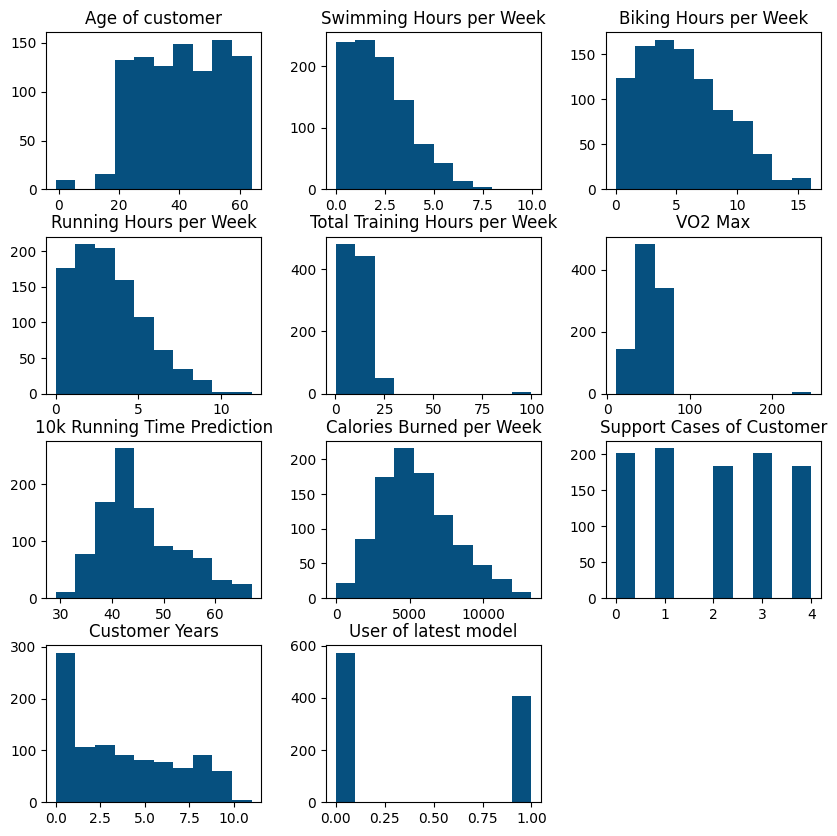

In [624]:
df_training.hist(figsize=(10,10), color= hex_to_rgb_normalized(color2), grid=False)

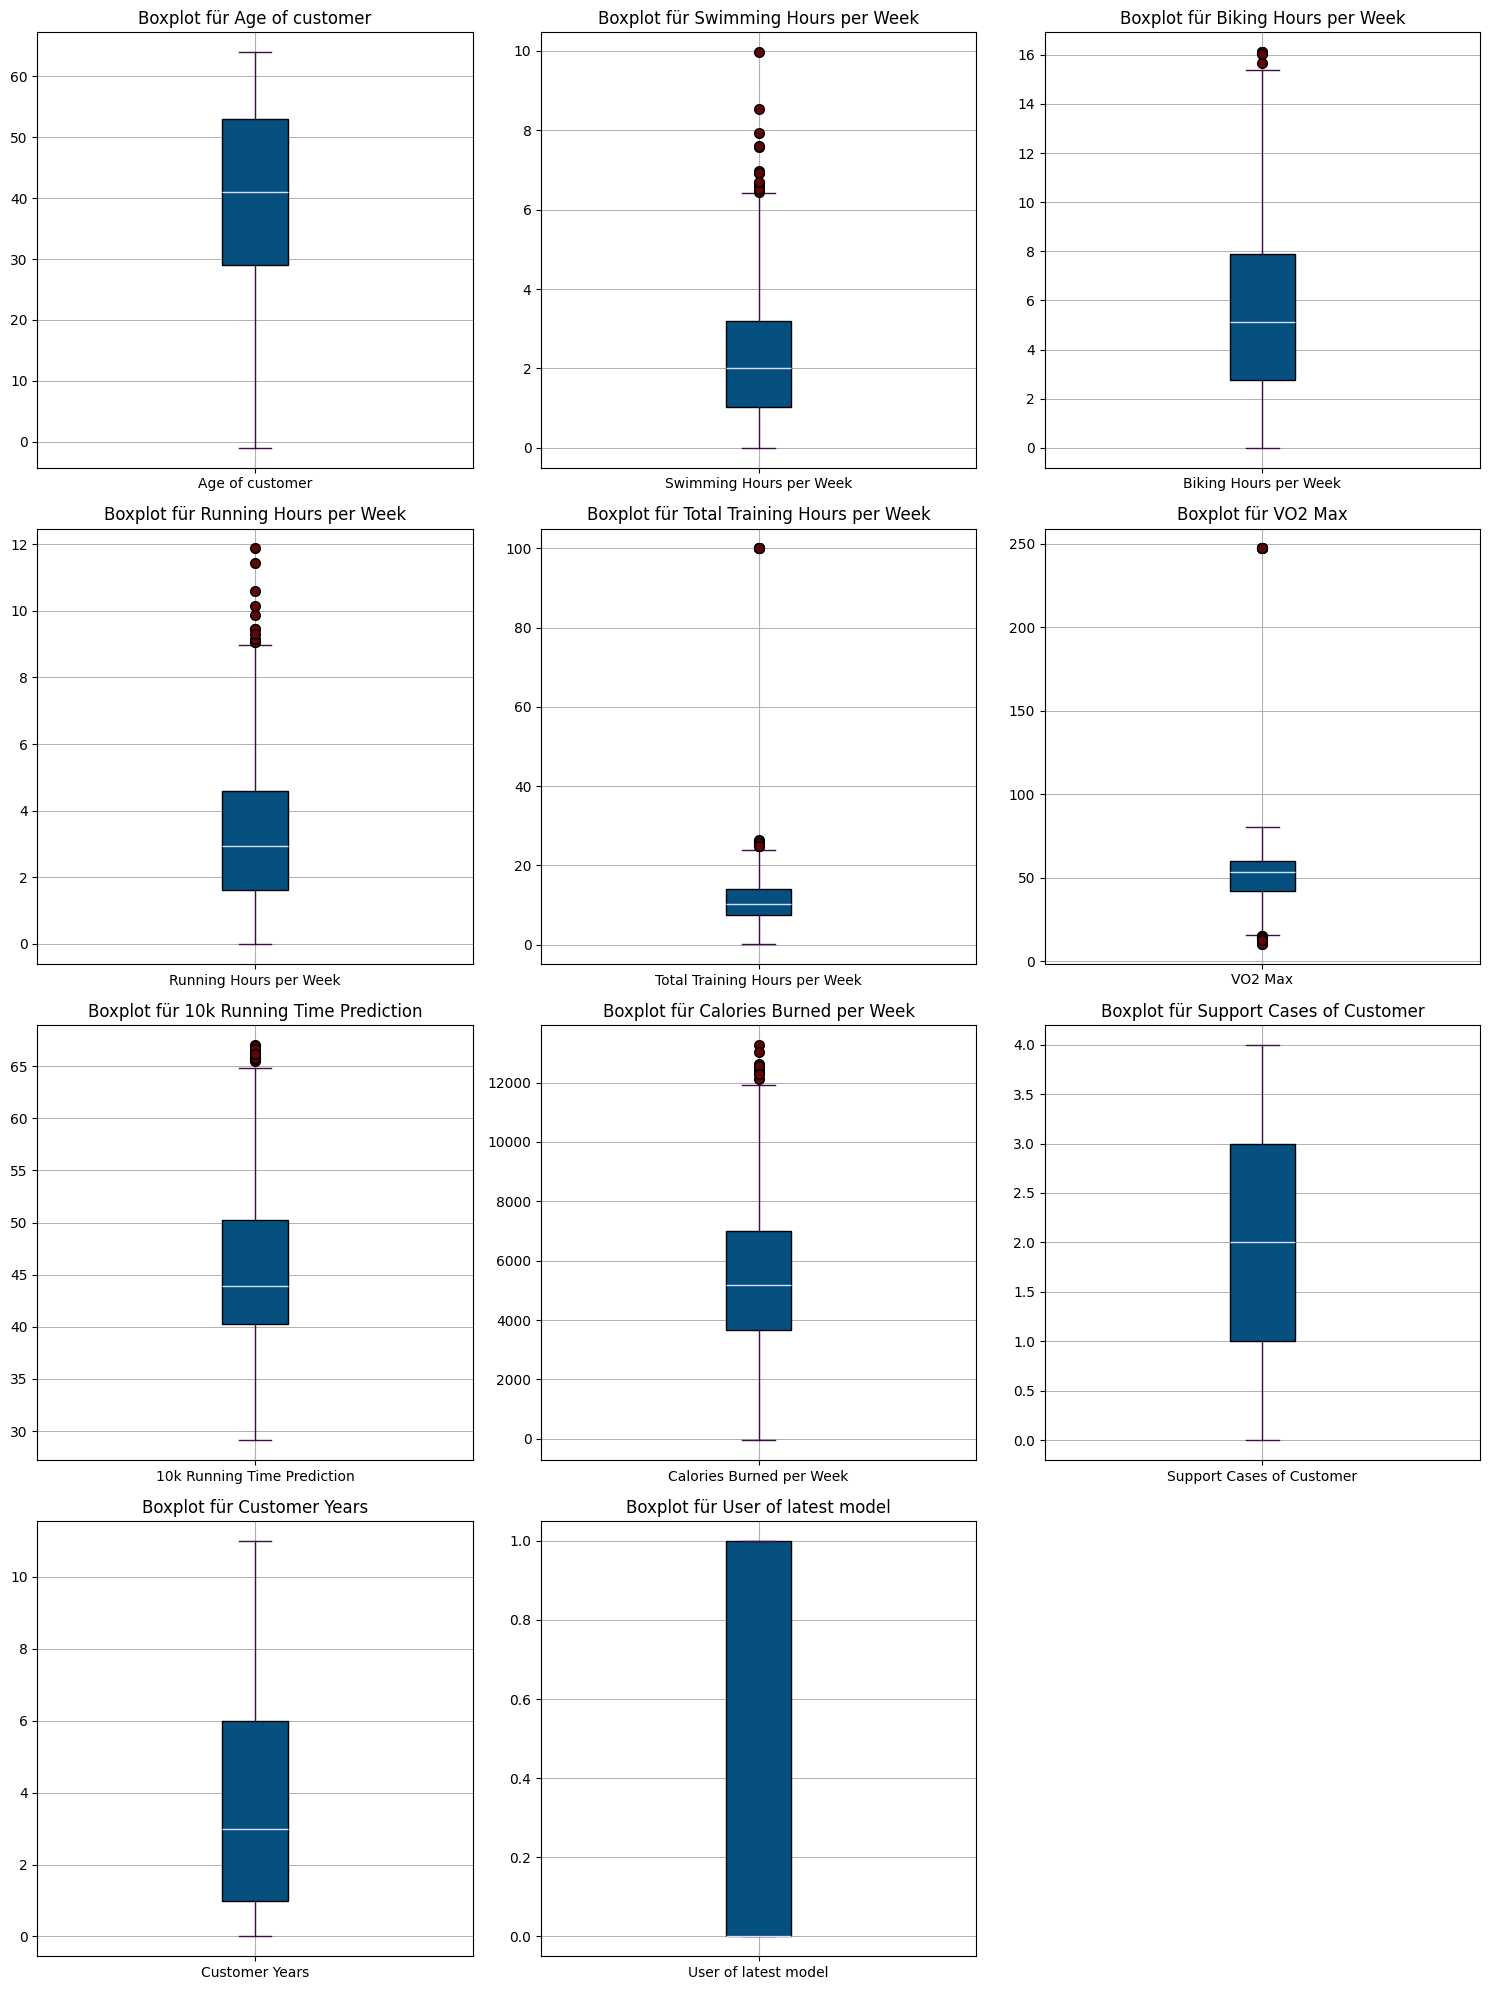

In [625]:
#Boxplots für numerische Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(numerical_cols) // ncols) + (len(numerical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede numerische Spalte iterieren und einen Boxplot erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    df_training.boxplot(column=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))
    ax.set_title(f"Boxplot für {col}")
    ax.grid(axis='y', linewidth=0.7)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

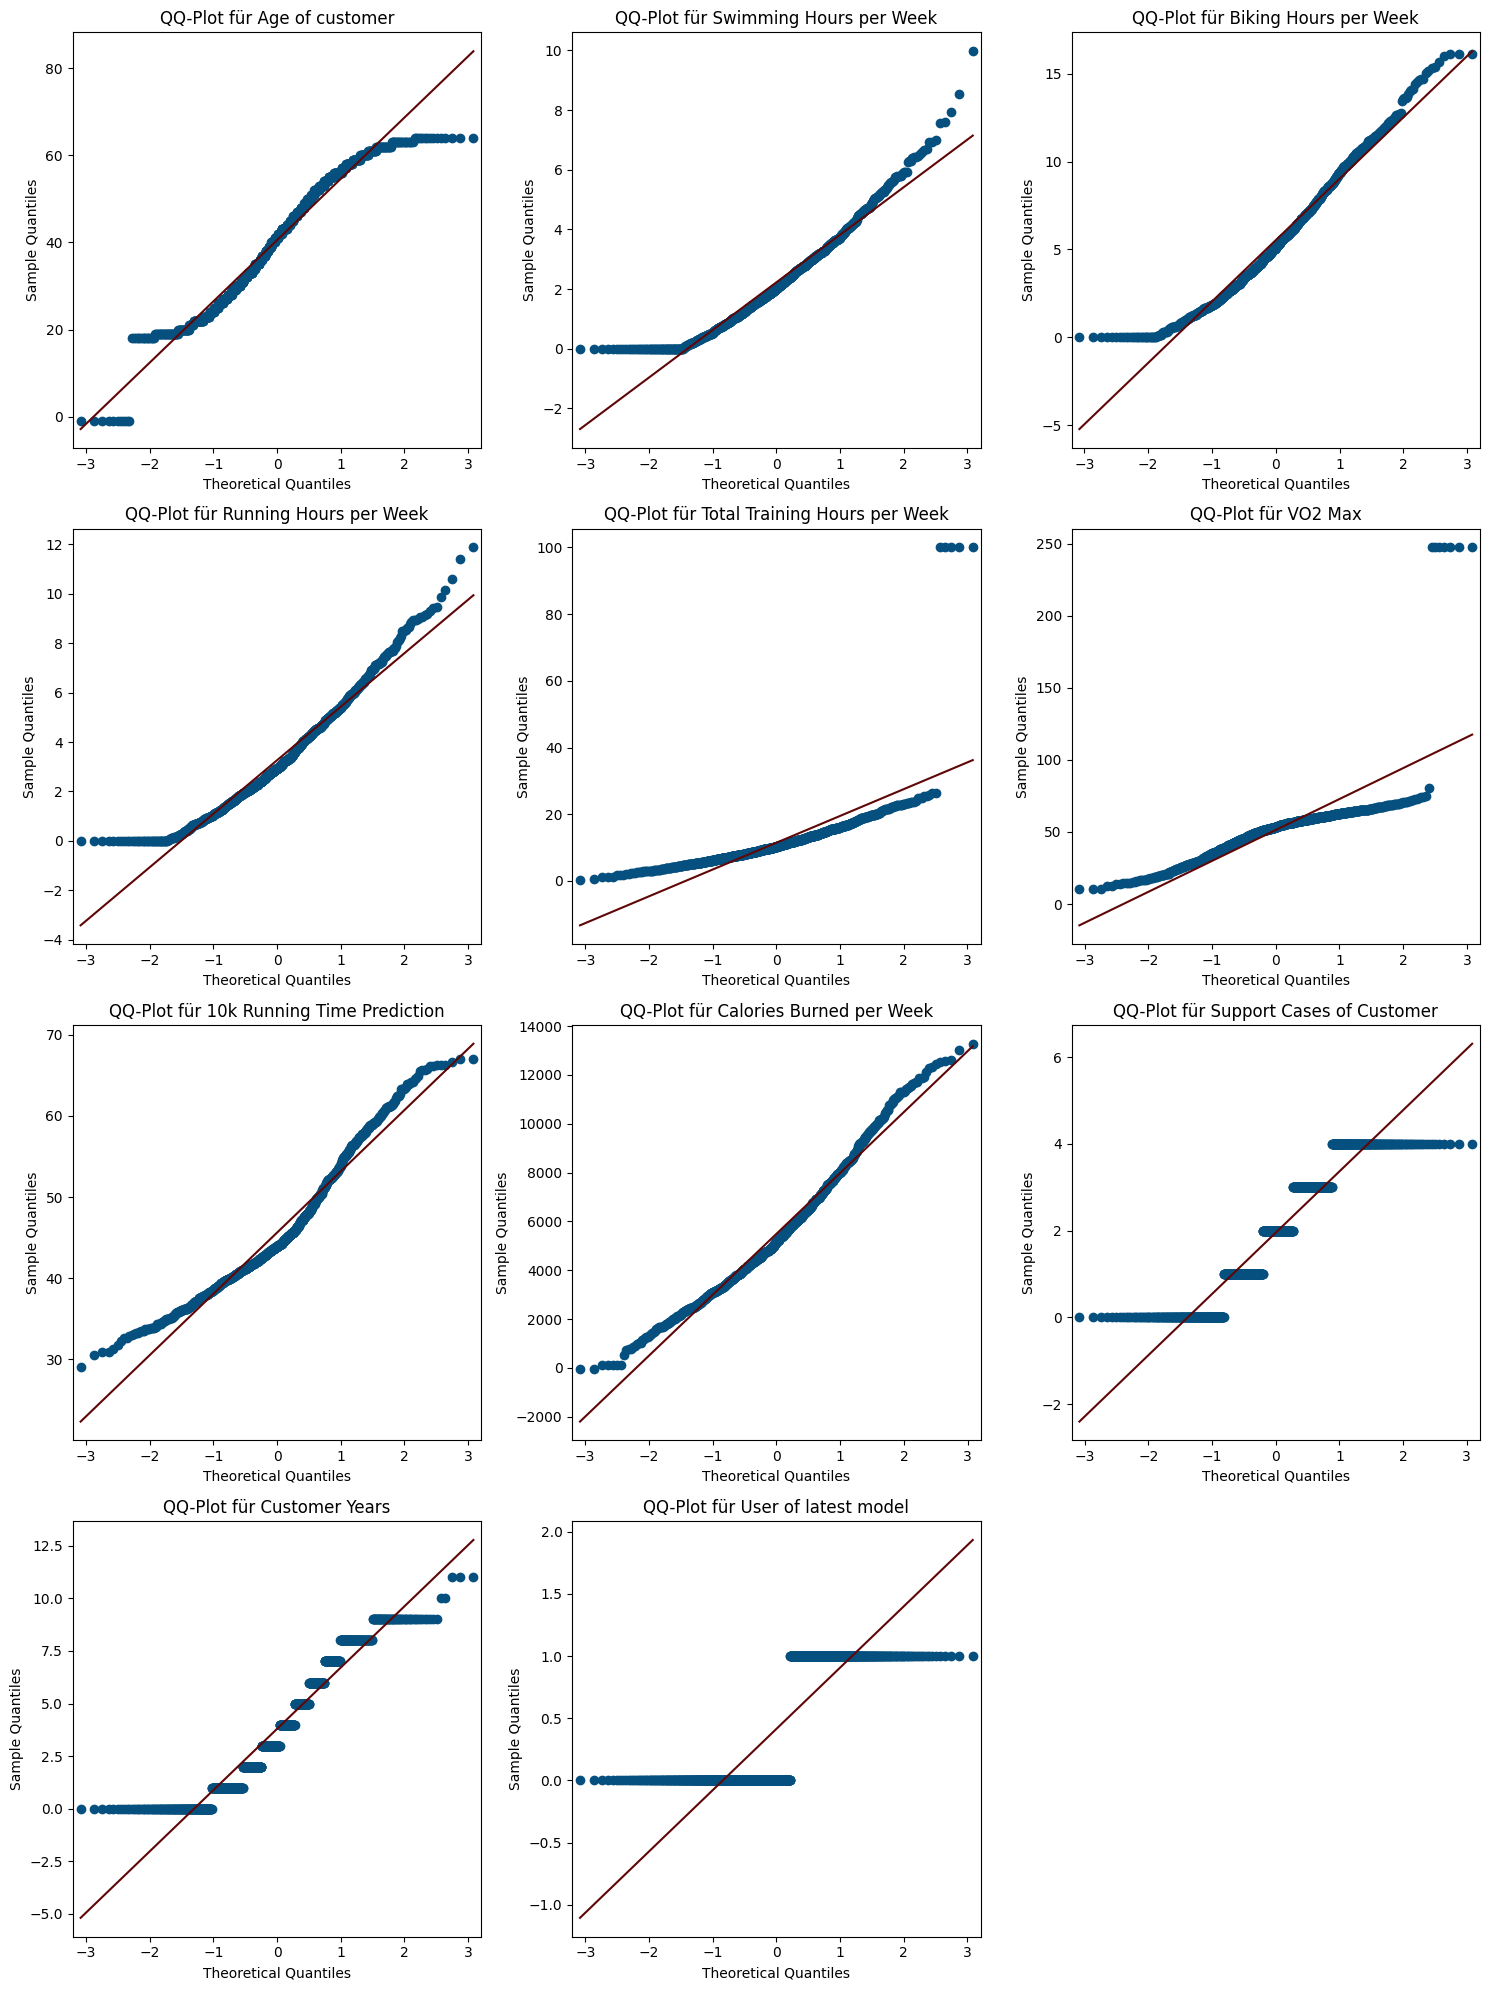

In [626]:
# QQ-Plots für numerische Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(numerical_cols) // ncols) + (len(numerical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede numerische Spalte iterieren und einen QQ-Plot erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    
    # QQ-Plot erstellen, aber diesmal speichern wir das Objekt (der Plot wird hier erstellt)
    qq = qqplot(df_training[col].dropna(), line='s', ax=ax)
    
    # Extrahiere die Linienobjekte
    lines = ax.get_lines()
    
    # Setze die Farbe der Linie (die theoretische Normalverteilungslinie)
    lines[1].set_color(color3)  # Die zweite Linie ist die 'line=s' Linie
    
    # Setze die Farbe der Datenpunkte (erste Linie ist der Scatterplot)
    lines[0].set_markerfacecolor(color2)
    lines[0].set_markeredgecolor(color2)
    
    # Achsentitel und Gitter
    ax.set_title(f"QQ-Plot für {col}")
    ax.grid(False)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

In [627]:
# Schiefe
skewness = df_training[numerical_cols].skew()

skewness_df = pd.DataFrame({
    'Spalte': skewness.index,
    'Schiefe': skewness.values,
    'Kategorie': [categorize_skewness(val) for val in skewness]
})

skewness_df

Spalte   Schiefe           Kategorie
0                 Age of customer -0.205840    eher symmetrisch
1         Swimming Hours per Week  0.790590  leicht rechtschief
2           Biking Hours per Week  0.526163  leicht rechtschief
3          Running Hours per Week  0.697999  leicht rechtschief
4   Total Training Hours per Week  6.928020  stark rechtsschief
5                         VO2 Max  5.194915  stark rechtsschief
6     10k Running Time Prediction  0.682588  leicht rechtschief
7        Calories Burned per Week  0.533698  leicht rechtschief
8       Support Cases of Customer  0.038682    eher symmetrisch
9                  Customer Years  0.340594    eher symmetrisch
10           User of latest model  0.349278    eher symmetrisch

In [628]:
# Prüfung auf Normalverteilung
for col in numerical_cols:
    print(f'\nShapiro-Wilk Test für Spalte: {col}')
    shapiro_wilk_test(df_training[col].dropna(), 0.05)
    print('-' * 40)


Shapiro-Wilk Test für Spalte: Age of customer
Statistics=0.964, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------

Shapiro-Wilk Test für Spalte: Swimming Hours per Week
Statistics=0.953, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------

Shapiro-Wilk Test für Spalte: Biking Hours per Week
Statistics=0.969, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------

Shapiro-Wilk Test für Spalte: Running Hours per Week
Statistics=0.961, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------

Shapiro-Wilk Test für Spalte: Total Training Hours per Week
Statistics=0.569, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------

Shapiro-Wilk Test für Spalte: VO2 Max
Statistics=0.607, p=0.00000
Sample sieht nicht norm

**Erkenntnisse Verteilung numerische Variablen**  
- `Age of customer`  
Bis auf den Datenfehler von -1 und die Kunden unter 20 sind die Daten relativ gleichverteilt und können als symmetrisch bezeichnet werden (Bewertung anhand berechneter Schiefe, Histogramm). Sie haben keine Normalverteilung.

- `Swimming Hours per Week`  
Die Daten sind leicht rechtsschief (Histogramm, QQ-Plot, berechnete Schiefe).
- `Biking Hours per Week`  
Die Daten sind leicht rechtsschief (Histogramm, QQ-Plot, berechnete Schiefe).
- `Running Hours per Week`  
Die Daten sind leicht rechtsschief (Histogramm, QQ-Plot, berechnete Schiefe).
- `Total Training Hours per Week`  
Die Daten sind bedingt durch wenige Ausreißer stark rechtsschief (Histogramm, QQ-Plot, berechnete Schiefe, Boxplot). Der Ausreißer von 100 wirkt wie ein Datenfehler, da die Aufsummierung der Maximalwerte von den 3 anderen Spalten `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week` nicht die 100 ergibt. Der Datenpunkt muss sich im Folgenden näher angeschaut werden. Allgemein sollte eine Prüfung erfolgen, ob die drei Spalten tatsächlich immer aufsummiert werden können, um den Wert von `Total Training Hours per Week` zu erhalten.
- `VO2 Max`  
Vergleicht man den Mittelwert mit dem Median, sind die Daten eher linksschief (Mittelwert < Median). Allerdings verfälscht der Ausreißer von 247.2578 das Bild. So geht aus der Berechnung der Schiefe, dem Boxplot und dem QQ-Plot eher eine starke Rechtsschiefe hervor. Der Ausreißer sollte sich im nächsten Schritt auch genauer angeschaut werden.
- `10k Running Time Prediction`  
Anhand der Vergleichs von Mittelwert und Median ist prinzipiell von einer Rechtsschiefe auszugehen. Dies wird durch die Berechnung der Schiefe und dem QQ-Plot bestätigt. Optisch gesehen zeigt das Histogramm eine annähernde Normalverteilung. Das Ergebnis des Shapiro-Wilk Test weist jedoch darauf hin, dass die Daten nicht normalverteilt sind.
- `Calories Burned per Week`  
Anhand der Vergleichs von Mittelwert und Median ist prinzipiell von einer Rechtsschiefe auszugehen. Dies wird durch die Berechnung der Schiefe und dem QQ-Plot bestätigt. Optisch gesehen zeigt das Histogramm eine annähernde Normalverteilung. Das Ergebnis des Shapiro-Wilk Test weist jedoch darauf hin, dass die Daten nicht normalverteilt sind.
- `Support Cases of Customer`  
Die Daten wirken gleichverteilt und können als symmetrisch bezeichnet werden (Histogramm, Berechnung Schiefe, Boxplot).
- `Customer Years`  
Daten wirken durch hohe Anzahl bei 0 rechtsschief (Boxplot, Histogramm). Laut Berechnung der Schiefe können sie jedoch als symmetrisch betrachtet werden.
- `User of latest model`  
Es gibt allgemein weniger Kunden, die das letzte Modell nutzen. Da die Spalte zwar numerisch kodiert ist, fachlich gesehen jedoch nominal, lassen sich keine validen Aussagen über die Datenverteilung mit den gegeben Mitteln treffen.

Die Spalten `Support Cases of Customer`, `Customer Years` sowie das Label `User of latest model` haben wenig Ausprägungen und sollten in der Analyse von Zusammenhängen nicht in die Korrelationsanalyse einfließen. Bei der Spalte `Age of customer` ist dies stritig. Es ist eine diskrete Variable, die allerdings (vor Datenbereinigung) 48 Ausprägungen zeigt. Somit könnte sie innerhalb einer Korrelationsanalyse untersucht werden.  

Allgemein lässt sich sagen, dass keine der numerischen Spalten normalverteilt ist. Alle Spalten könnten daher einer Transformation unterzogen werden.

In [629]:
# Überprüfung der Traingszeiten
df_traintimes = df_training[['Biking Hours per Week', 'Swimming Hours per Week', 'Running Hours per Week', 'Total Training Hours per Week']].copy()
df_traintimes['test'] = df_traintimes['Total Training Hours per Week'] - (df_traintimes['Biking Hours per Week'] + df_traintimes['Swimming Hours per Week'] + df_traintimes['Running Hours per Week'])
df_traintimes.sort_values(by='test', ascending=False).head(6)

Biking Hours per Week  Swimming Hours per Week  Running Hours per Week  \
184                   6.43                     0.89                    3.28   
74                    6.61                     2.75                    1.57   
250                   3.66                     2.24                    7.24   
649                   7.09                     6.98                    7.17   
929                  13.54                     1.10                    8.76   
726                   9.34                     0.45                    0.00   

     Total Training Hours per Week   test  
184                          100.0  89.40  
74                           100.0  89.07  
250                          100.0  86.86  
649                          100.0  78.76  
929                          100.0  76.60  
726                            9.8   0.01

Die Zeilen, in denen `Total Training Hours per Week` 100 ist, sollten durch die Addition der anderen 3 Trainingszeitenspalten ersetzt werden. Der Wert von 100 ist unplausibel und entspricht nicht der zu erwartenden Regel. Er sollte im Zuge der "Missing Value Behandlung" ersetzt werden.

In [630]:
# Überprüfung Maximalwert bei VO2 Max
df_training.sort_values(by='VO2 Max', ascending=False).head(15)

ID  Age of customer     Sex       Ctry        Town  \
428  C0429             31.0  Female  Australia      Sydney   
6    C0008             30.0  Female         UK         NaN   
214  C0214             38.0    Male      India   Bangalore   
152  C0153             48.0   Other      India       Delhi   
611  C0610             35.0  Female        USA    New York   
506  C0507             61.0    Male      India       Delhi   
883    NaN              NaN     NaN        NaN         NaN   
928  C0931             31.0   Other      India       Delhi   
837  C0838             35.0   Other         UK      London   
826  C0826             40.0   Other  Australia    Brisbane   
649  C0644             40.0    Male        USA     Chicago   
971  C0972             29.0    Male    Germany      Munich   
448  C0451             32.0    Male      India   Bangalore   
33   C0034             30.0  Female         UK  Birmingham   
76   C0073             28.0  Female  Australia      Sydney   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
428                     4.66                   5.64                    5.71   
6                       0.84                   4.06                    4.23   
214                     1.47                   6.64                    1.44   
152                     4.04                   9.70                    6.23   
611                     1.74                  10.82                    0.64   
506                     0.00                   2.60                    2.21   
883                      NaN                    NaN                     NaN   
928                     3.56                  14.70                    5.43   
837                     2.73                  12.74                    9.30   
826                     3.64                   9.15                    7.31   
649                     6.98                   7.09                    7.17   
971                     0.36                  15.67                    8.92   
448                     5.16                   6.09                    5.90   
33                      0.95                  13.83                    7.87   
76                      6.42                   2.93                    7.45   

     Total Training Hours per Week   VO2 Max  10k Running Time Prediction  \
428                          16.00  247.2578                        35.95   
6                             9.12  247.2578                        36.56   
214                           9.55  247.2578                        45.33   
152                          19.98  247.2578                        42.39   
611                          13.20  247.2578                        39.69   
506                           4.81  247.2578                        61.04   
883                            NaN  247.2578                          NaN   
928                          23.70   80.5400                        33.05   
837                          24.77   75.0700                        33.45   
826                          20.10   74.3000                        33.77   
649                         100.00   74.1200                        36.98   
971                          24.95   73.7400                        30.87   
448                          17.15   72.6100                        36.41   
33                           22.65   72.5400                        31.81   
76                           16.80   72.0300                        33.27   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
428                   7960.27                        4.0             6.0   
6                     4835.71                        4.0             3.0   
214                   4779.57                        0.0             3.0   
152                  10273.42                        1.0             2.0   
611                   6658.03                        1.0             2.0   
506                   2456.22                        3.0     

Der Wert 247,2578 bei der Spalte `VO2 Max` ist unplausibel. Er sollte angepasst werden im Zuge der "Missing Value"-Behandlung.

#### Einblick Zusammenhänge

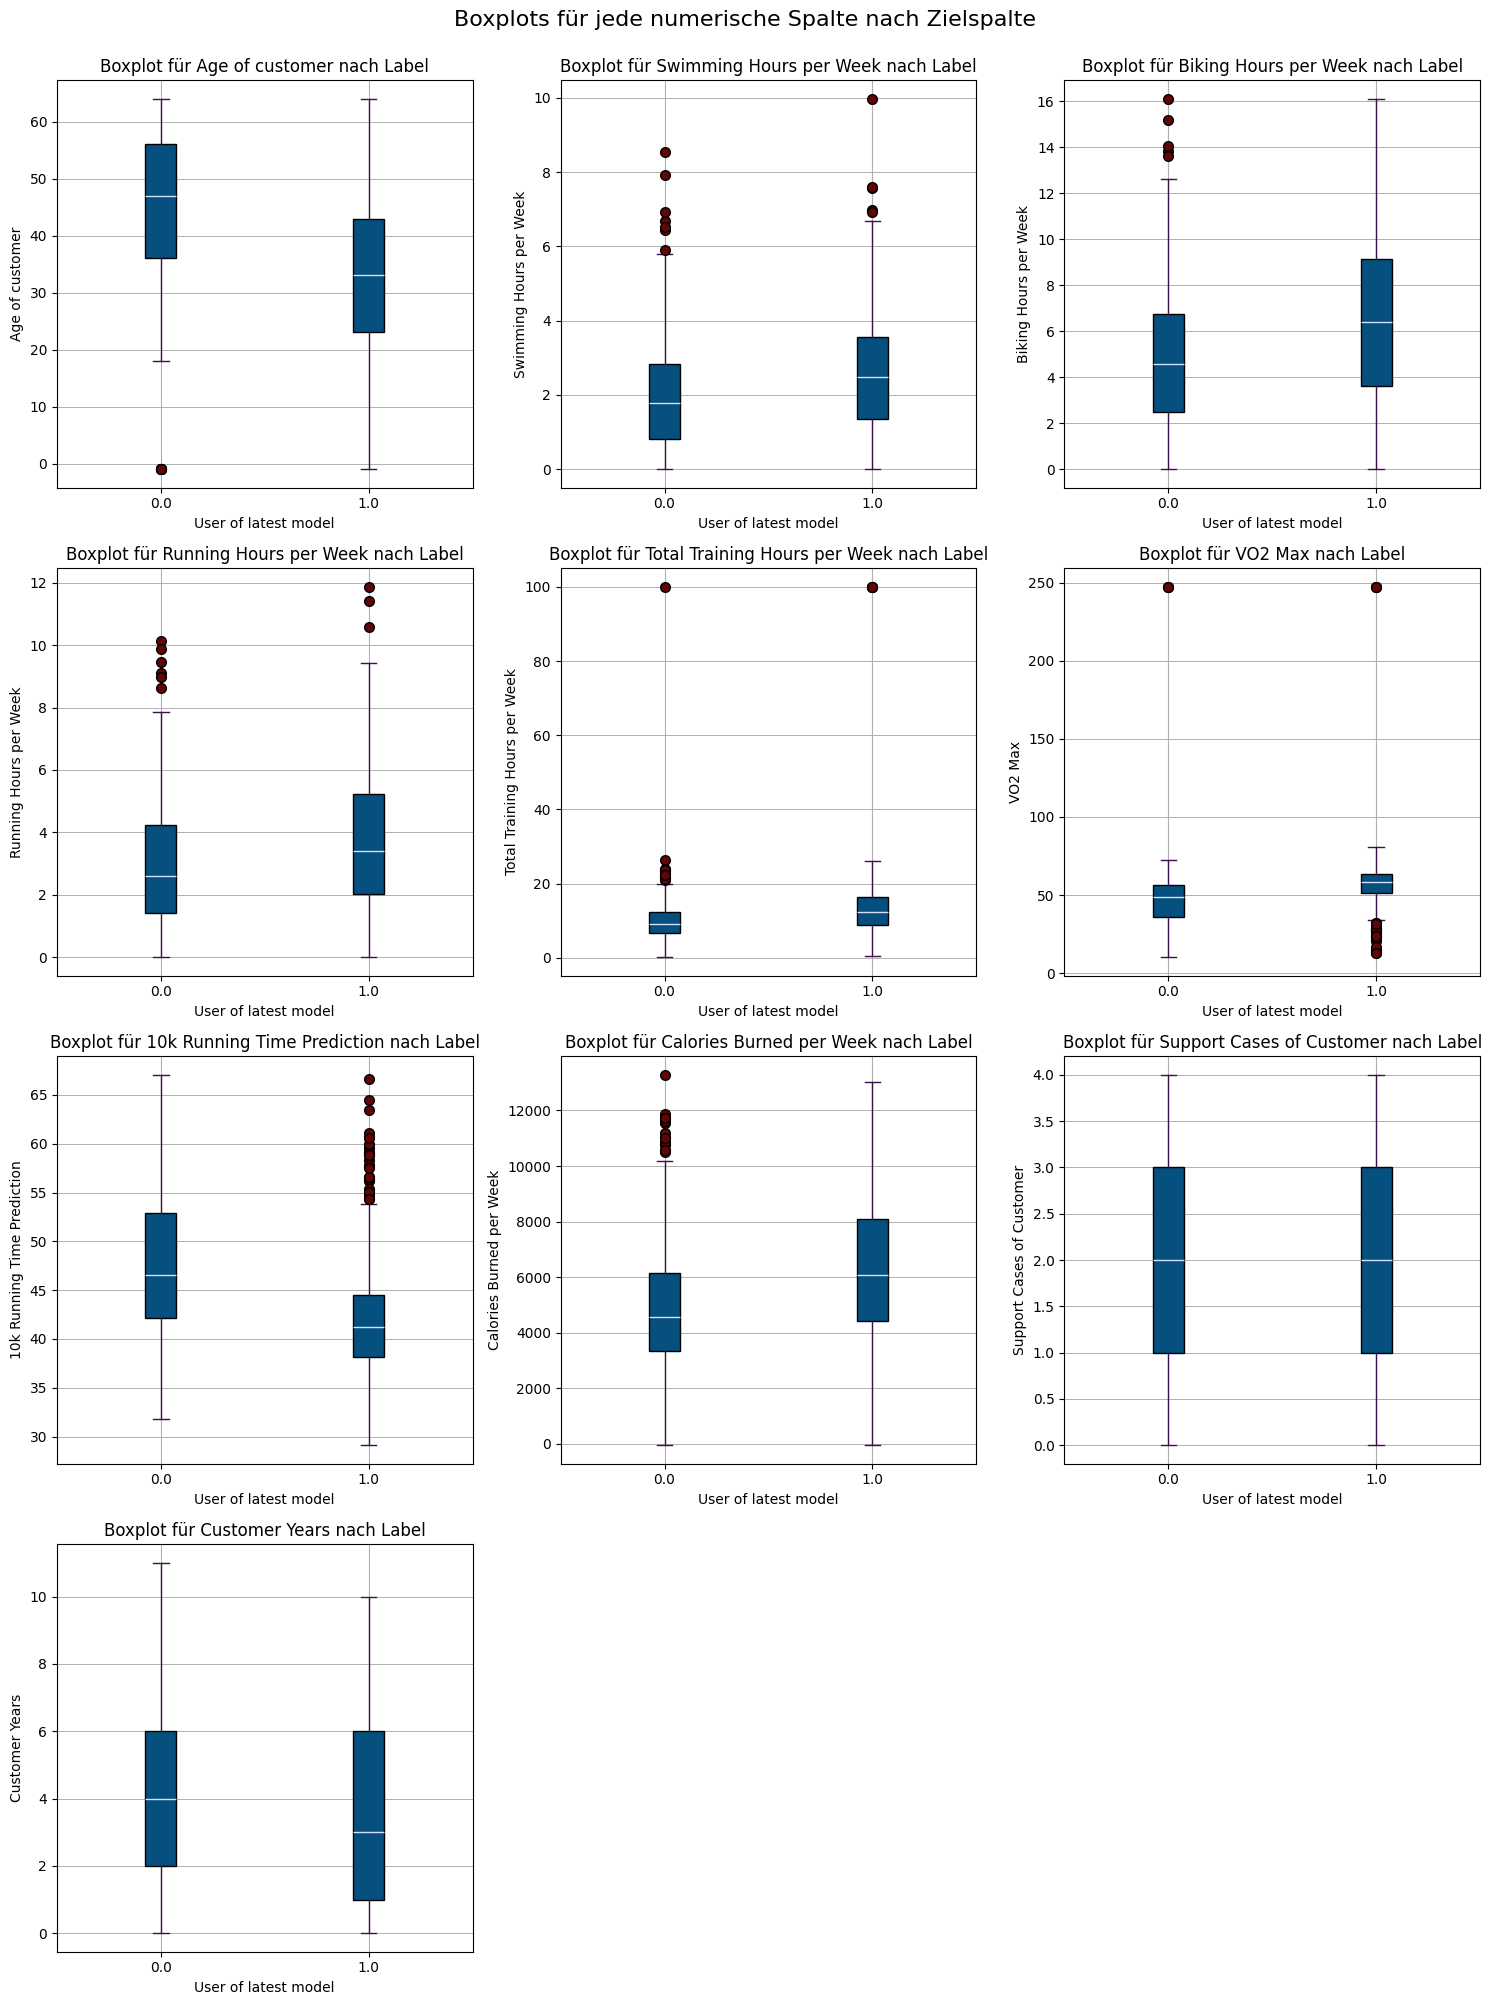

In [631]:
# Boxplots für numerische Spalten nach Label
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(numeric_features) // ncols) + (len(numeric_features) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(numeric_features):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=col, by=label, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {col} nach Label")
    ax.set_xlabel(label)
    ax.set_ylabel(col)
    ax.grid(axis='y', linewidth=0.7)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle('Boxplots für jede numerische Spalte nach Zielspalte', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()


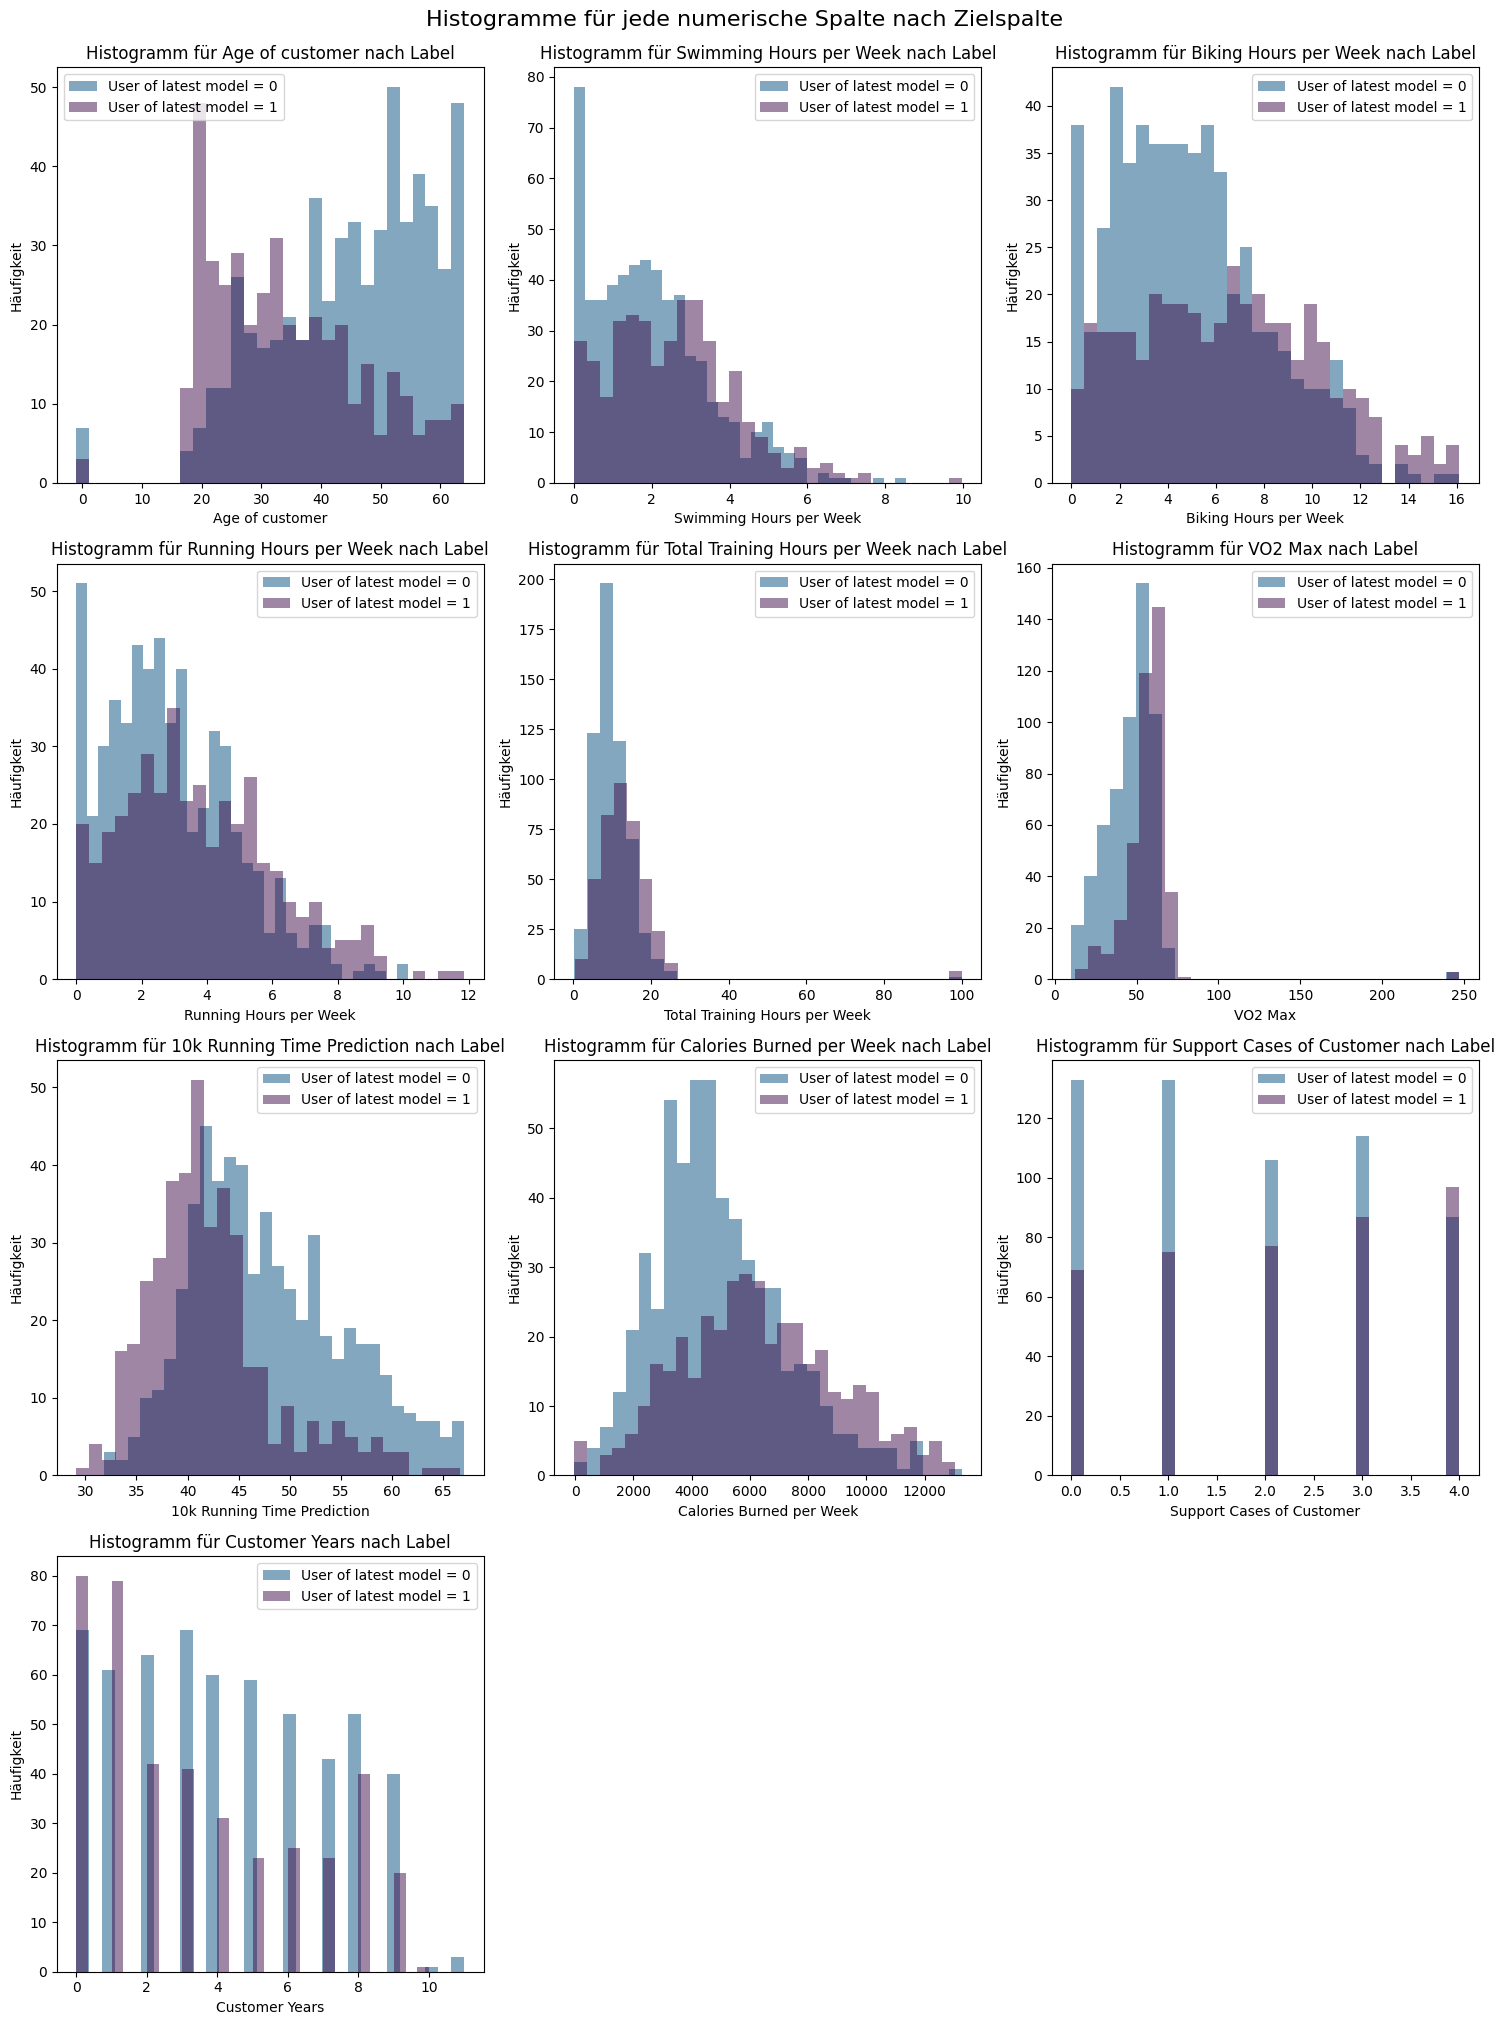

In [632]:
# Histogramme für numerische Spalten nach Label
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(numeric_features) // ncols) + (len(numeric_features) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede numerische Spalte iterieren und Histogramm für beide Kategorien des Labels erstellen
for i, col in enumerate(numeric_features):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Histogramm für jede Ausprägung der Zielspalte (label)
    df_training[df_training[label] == 0][col].hist(bins=30, ax=ax, alpha=0.5, label=f'{label} = 0', color=color2)
    df_training[df_training[label] == 1][col].hist(bins=30, ax=ax, alpha=0.5, label=f'{label} = 1', color=color4)

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Histogramm für {col} nach Label")
    ax.set_xlabel(col)
    ax.set_ylabel('Häufigkeit')
    ax.legend()
    ax.grid(False)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout()

# Titel für das gesamte Grid
fig.suptitle('Histogramme für jede numerische Spalte nach Zielspalte', fontsize=16, y=1.01)

# Plot anzeigen
plt.show()


**Erkenntnisse grafische Darstellung Zusammenhang mit Label**  
- `Age of customer`  
Die Nutzer des letzten Modells sind eher jünger.

- `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week`, `Total Training Hours per Week`  
Die Nutzer des letzten Modells haben höhere Trainingszeiten.

- `VO2 Max`  
Die Nutzer des letzten Modells haben eher höhere Werte.
- `10k Running Time Prediction`  
Die Nutzer des letzten Modells bekommen eher eine niedrigere Zeit vorhergesagt.
- `Calories Burned per Week`  
Die Nutzer des letzten Modells verbrennen eher mehr Kalorien.
- `Support Cases of Customer`  
Anhand der Grafiken lässt sich kein unmittelbarer Zusammenhang erkennen.
- `Customer Years`  
Tendenziell sind es neuere Kunden, die das neuste Modell nutzen.


Eine Korrelartionsanalyse ist prinzipiell nicht sinnvoll, da die Zielvariable nominal ist. Trotzdem wird eine Korrelationsmatrix erstellt, um Koliniearitäten zu identifizieren.

In [633]:
numerical_cols_plot = ['Age of customer', 'Swimming Hours per Week', 'Biking Hours per Week',
       'Running Hours per Week', 'Total Training Hours per Week', 'VO2 Max',
       '10k Running Time Prediction', 'Calories Burned per Week']

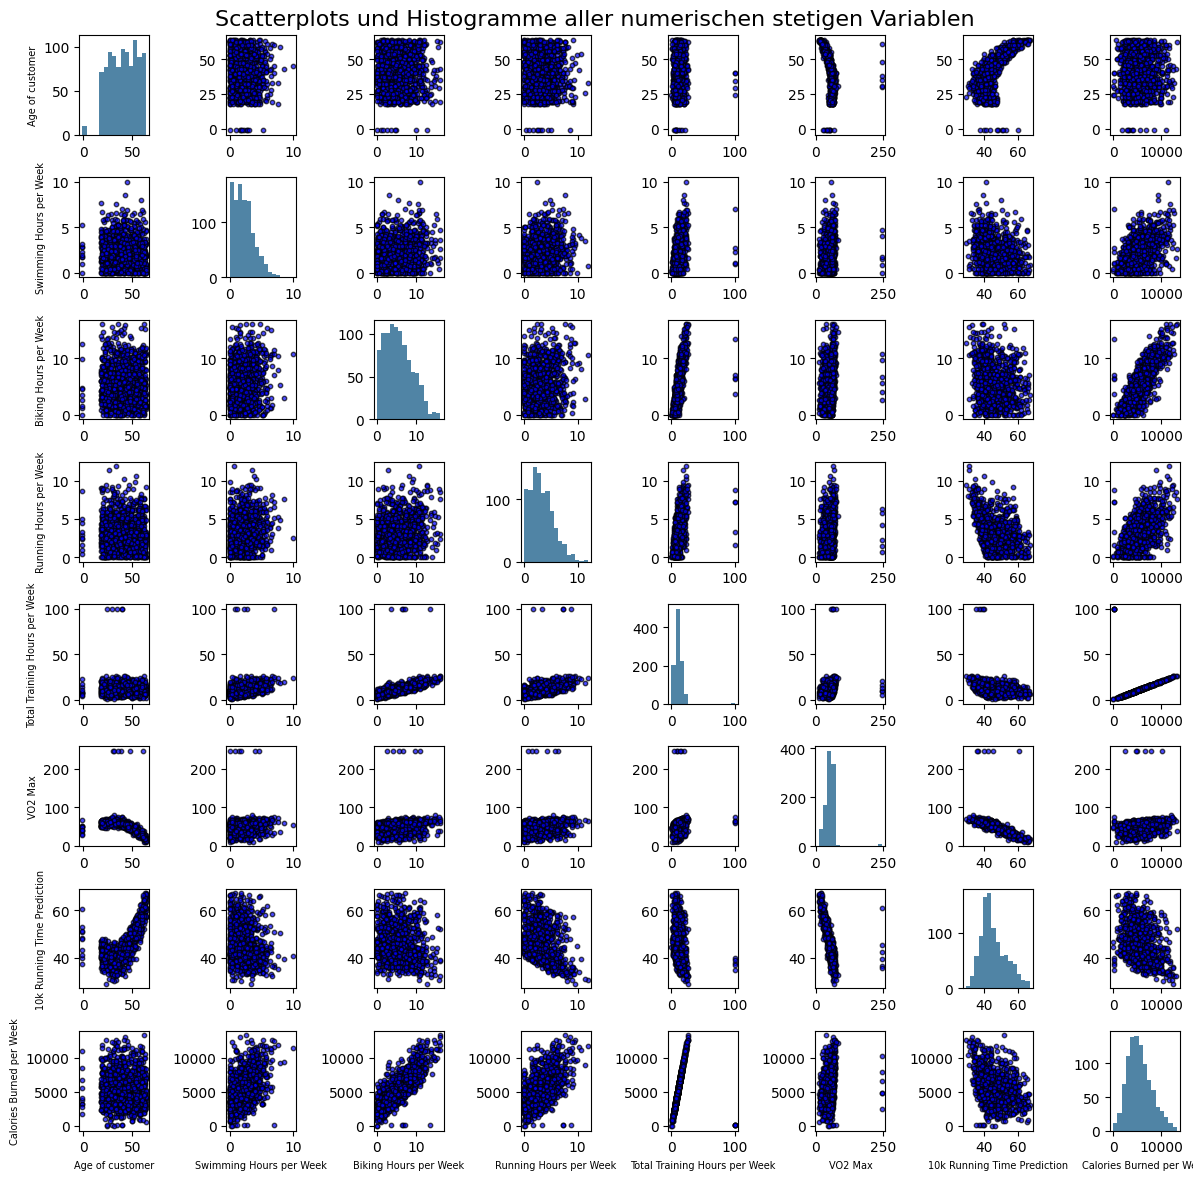

In [634]:
# Scatterplot-Matrix für alle numerischen stetigen Spalten 
# Subplot-Raster erstellen
n = len(numerical_cols_plot)
fig, axes = plt.subplots(n, n, figsize=(12, 12), sharex=False, sharey=False)

# Scatterplots und Achsenbeschriftungen einfügen
for i, row_var in enumerate(numerical_cols_plot):
    for j, col_var in enumerate(numerical_cols_plot):
        ax = axes[i, j]
        
        if i == j:
            # Diagonale: Histogramm (oder leer lassen)
            ax.hist(df_training[row_var], bins=15, color=color2, alpha=0.7)
        else:
            # Scatterplots für alle Kombinationen
            ax.scatter(df_training[col_var], df_training[row_var], alpha=0.7, c='blue', edgecolor='k', s=10)
        
        # Beschriftungen nur am Rand hinzufügen
        if i == n - 1:  # Unterste Zeile
            ax.set_xlabel(col_var, fontsize=7)
        if j == 0:  # Linkeste Spalte
            ax.set_ylabel(row_var, fontsize=7)

# Überschrift für das gesamte Raster hinzufügen
fig.suptitle("Scatterplots und Histogramme aller numerischen stetigen Variablen", fontsize=16)

# Layout anpassen und anzeigen
plt.tight_layout()
plt.show()

<Axes: >

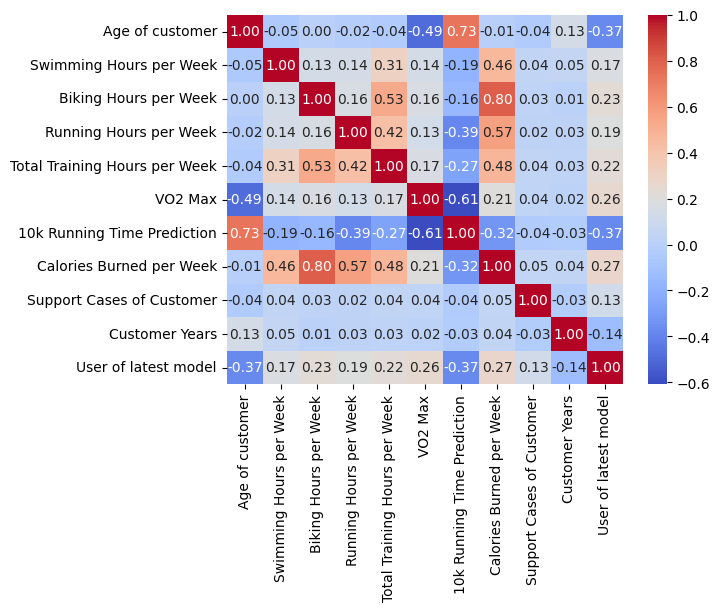

In [635]:
# Korrelationsmatrix
corr = df_training[numerical_cols].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")

**Erkenntnisse Korrelationsanalyse**  
- Wie zu erwarten ist die Korrelationsmatrix hinsichtlich des Labels nichts besonders aufschlussreich. Aufgrund dieser würden nur das `Alter` und die `10k Running Time Prediction` in Betracht gezogen werden.
- Die Trainingszeit gesamt korreliert mit den anderen einzelnen Trainingszeiten (Sinnig aufgrund direkter Beziehung durch Berechnung). Die einzelnen Trainingszeiten untereinander korrelieren jedoch nur schwach. 
- Das Alter korreliert mit der `10k Running Time Prediction` positiv. Je älter ein Kunde ist, desto höher ist seine voraussichtliche Laufzeit. Ebenfalls korreliert das Alter negativ mit `V02 Max`.
- `10k Running Time Prediction` und `V02 Max` korrelieren negativ.
- `Calories Burned per Week` korreliert positiv mit den Trainingszeiten- Dabei ist Fahrradfahren die Variable mit dem höchsten Korrelation.

In [636]:
# Varianzanalyse
for col in numeric_features:
    normalized_col = col+'_normalized'
    features[normalized_col] = (features[col] - features[col].min()) / (features[col].max() - features[col].min())

In [637]:
normalized_features = ['Age of customer_normalized',
       'Swimming Hours per Week_normalized',
       'Biking Hours per Week_normalized', 'Running Hours per Week_normalized',
       'Total Training Hours per Week_normalized', 'VO2 Max_normalized',
       '10k Running Time Prediction_normalized',
       'Calories Burned per Week_normalized',
       'Support Cases of Customer_normalized', 'Customer Years_normalized']

#describe normalized data
features[normalized_features].describe().T

count      mean       std  min  \
Age of customer_normalized                978.0  0.638918  0.216495  0.0   
Swimming Hours per Week_normalized        978.0  0.223290  0.160005  0.0   
Biking Hours per Week_normalized          954.0  0.343210  0.217217  0.0   
Running Hours per Week_normalized         978.0  0.274829  0.182452  0.0   
Total Training Hours per Week_normalized  978.0  0.113131  0.080506  0.0   
VO2 Max_normalized                        975.0  0.173618  0.090530  0.0   
10k Running Time Prediction_normalized    978.0  0.434647  0.198992  0.0   
Calories Burned per Week_normalized       959.0  0.415297  0.187565  0.0   
Support Cases of Customer_normalized      978.0  0.489008  0.353292  0.0   
Customer Years_normalized                 978.0  0.344767  0.265145  0.0   

                                               25%       50%       75%  max  
Age of customer_normalized                0.461538  0.646154  0.830769  1.0  
Swimming Hours per Week_normalized        0.102307  0.202608  0.319709  1.0  
Biking Hours per Week_normalized          0.171788  0.317194  0.488516  1.0  
Running Hours per Week_normalized         0.137742  0.246841  0.387532  1.0  
Total Training Hours per Week_normalized  0.072409  0.100851  0.139685  1.0  
VO2 Max_normalized                        0.134367  0.182165  0.210409  1.0  
10k Running Time Prediction_normalized    0.294742  0.389167  0.557130  1.0  
Calories Burned per Week_normalized       0.278316  0.391352  0.528846  1.0  
Support Cases of Customer_normalized      0.250000  0.500000  0.750000  1.0  
Customer Years_normalized                 0.090909  0.272727  0.545455  1.0

In [638]:
features[normalized_features].var().sort_values(ascending=False)

Support Cases of Customer_normalized        0.124815
Customer Years_normalized                   0.070302
Biking Hours per Week_normalized            0.047183
Age of customer_normalized                  0.046870
10k Running Time Prediction_normalized      0.039598
Calories Burned per Week_normalized         0.035181
Running Hours per Week_normalized           0.033289
Swimming Hours per Week_normalized          0.025602
VO2 Max_normalized                          0.008196
Total Training Hours per Week_normalized    0.006481
dtype: float64

**Erkenntnisse Varianzanalyse**  
Im Vergleich zur Korrelationsanalyse zeigt die Varianzanalyse, dass `Support Cases of Customer` und `Customer Years` aufgrund der vergleichsweisen hohen Varianz durchaus als Feature geeignet sein könnten.

In [639]:
# ANOVA-Test da Label kategorisch ist

anova_p_values = pd.DataFrame(index=numeric_features, columns=['p-value'])
for i in numeric_features:
    data_anova = pd.concat([features[i], df_training[label]], axis=1)
    data_anova = data_anova.dropna()
    groups = []
    for j in data_anova[label].unique():
        groups.append(data_anova[data_anova[label]==j][i])
    stat, p = f_oneway(*groups)
    anova_p_values.loc[i,'p-value'] = p
anova_p_values

p-value
Age of customer                     0.0
Swimming Hours per Week             0.0
Biking Hours per Week               0.0
Running Hours per Week              0.0
Total Training Hours per Week       0.0
VO2 Max                             0.0
10k Running Time Prediction         0.0
Calories Burned per Week            0.0
Support Cases of Customer      0.000077
Customer Years                 0.000022

**Erkenntnisse ANOVA-Test**  
Alle numerischen stetigen Spalten weisen einen Zusammenhang zum Label auf. Dies ist bereits aus der grafischen Analyse zu erwarten gewesen.  
`Support Cases of Customer` und `Customer Years` zeigen ebenfalls einen Zusammenhang zum Label. Dies deckt sich mit der Varianzanalyse, ist allerdings nicht durch die grafische Analyse erkenntlich gewesen.

### EDA kategorische Variablen

In [640]:
categorical_cols = list(df_training.select_dtypes(include=['object']).columns) + ['Support Cases of Customer', 'Customer Years']


#### Einblick Verteilung

In [641]:
df_training[categorical_cols].describe(include='object').T

count unique         top freq
ID                             978    971       C0482    2
Sex                            978      3        Male  345
Ctry                           978      7   Australia  200
Town                           939     15      Berlin   76
Most current software update   977    393  2024-12-29    9
Goal of Training               950      3     Fitness  332
Preferred Training Daytime     954      3     Morning  334
Subscription Type              977      3        Free  341
Color of Watch                 946      2       Black  691
Synchronisation                950      2         Yes  840

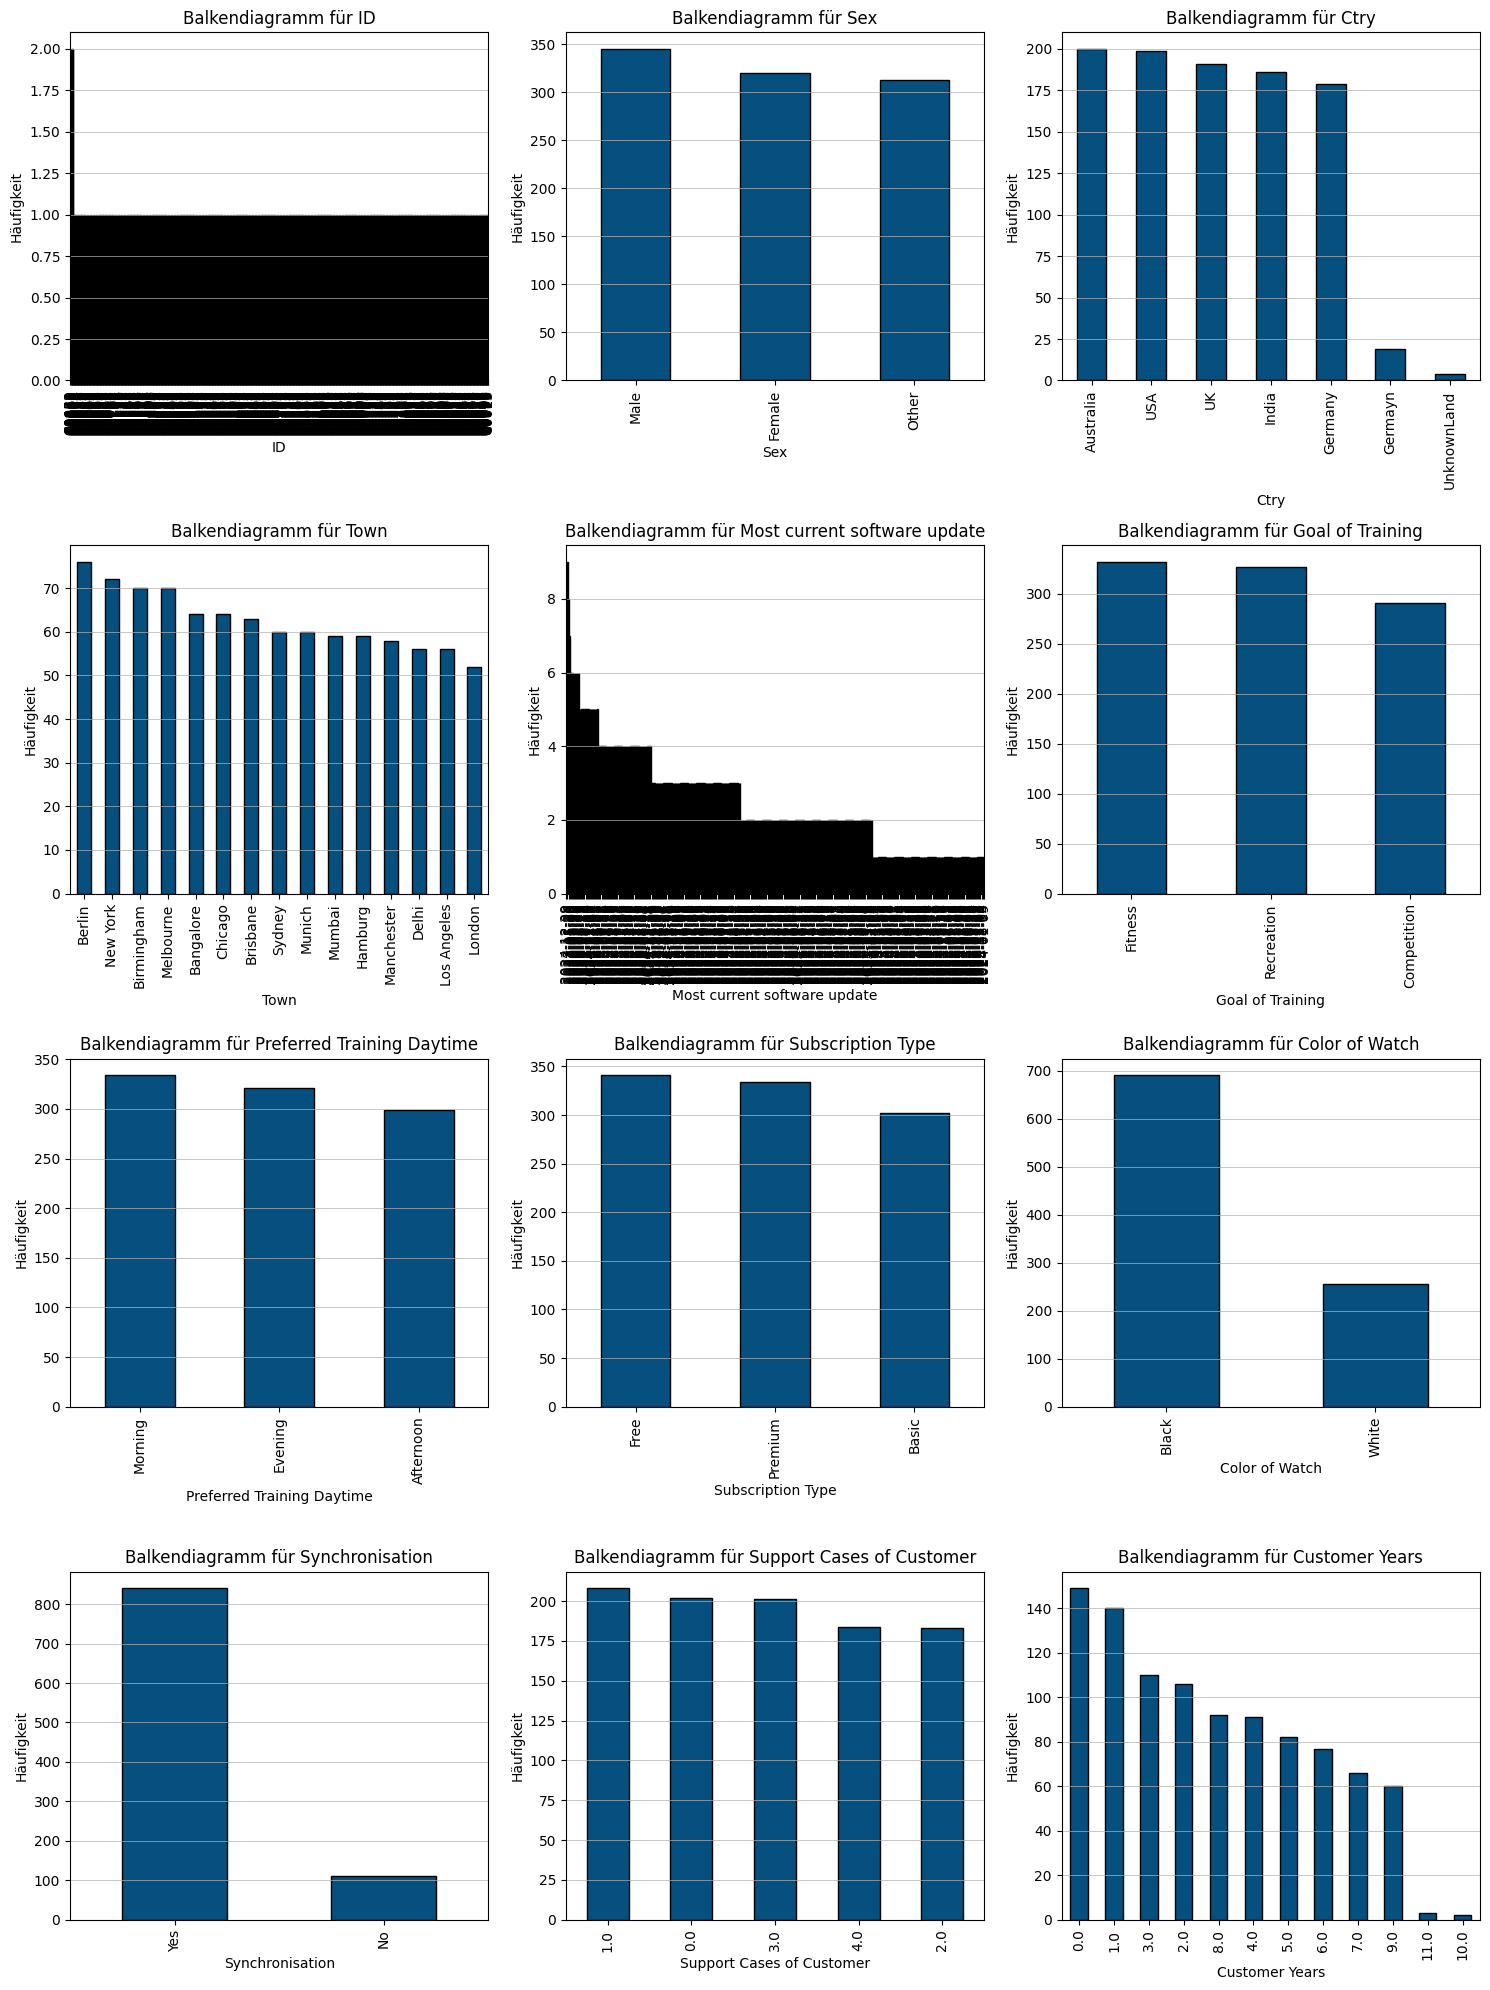

In [642]:
# Balkendiagramme für kategorische Spalten um Einblick in die Häufigkeiten zu erhalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede kategorische Spalte iterieren und Balkendiagramme erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    # Häufigkeiten der Kategorien berechnen
    value_counts = df_training[col].value_counts()
    # Balkendiagramm erstellen
    value_counts.plot(kind='bar', ax=ax, color=color2, edgecolor='black')
    ax.set_title(f"Balkendiagramm für {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Häufigkeit")
    ax.grid(axis='y', linewidth=0.5)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

In [643]:
# # Subplot erstellen
# fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(10, 5 * len(categorical_cols)))

# # Für jede kategorische Spalte
# for i, col in enumerate(categorical_cols):
#     # Häufigkeiten der Kategorien zählen
#     counts = df_training[col].value_counts(normalize=True).sort_index()
    
#     # Erstelle einen DataFrame, der für den Stacked Barplot geeignet ist
#     counts_df = counts.to_frame().transpose()

#     # Stacked Barplot erstellen
#     counts_df.plot(kind='bar', stacked=True, ax=axes[i], color=sns.color_palette("Set2", len(counts_df.columns)))
    
#     # Achsenbeschriftungen und Titel hinzufügen
#     axes[i].set_title(f"Verteilung der Kategorien in {col}")
#     axes[i].set_ylabel("Relative Häufigkeit")
#     axes[i].set_xlabel("Kategorien")

# # Layout anpassen, damit alles gut aussieht
# plt.tight_layout()
# plt.show()

**Erkenntnisse Verteilung kategorische Daten**  
- `ID`  
Zu viele Ausprägungen für die Visualisierung. Es scheint allerdings 7 IDs zu geben, die doppelt vorkommen. Das sollte eigentlich nicht der Fall sein und muss im Folgenden näher betrachtet werden.
- `Sex`  
Häufigste Kategorie ist männlich. Allgemein jedoch keine großen Unterschiede in den Häufigkeiten der Ausprägungen.
- `Ctry`  
Häufigste Kategorie ist Australien. Allgemein jedoch keine großen Unterschiede in den Häufigkeiten der Ausprägungen. Datenfehler *UnknownLand* und *Germayn* werden hier deutlich.
- `Town`  
Häufigste Kategorie ist Berlin. Allgemein jedoch keine großen Unterschiede in den Häufigkeiten der Ausprägungen.
- `Most current software update`  
Zu viele Ausprägungen für die Visualisierung. Eine Umformatierung zu datetime format wäre sinnig. Alternativ wäre auch mit Hilfe Feature Engineering das Datum in seine Bestandteile zu zerlegen.
- `Goal of Training`  
Häufigste Kategorie ist Fitness, Recreation jedoch auf ähnlichem Niveau. 
- `Preferred Training Daytime`  
Häufigste Kategorie ist morgens, gefolgt von abends. Nachmittags liegt mit etwas größerem Abstand dahinter.
- `Subscription Type`  
Häufigste Kategorie ist free, gefolgt von premium. Basic liegt mit etwas größerem Abstand dahinter.
- `Color of Watch`  
Deutliche Häufigkeit der Farbe Schwarz ggü. der zweiten Ausprägung weiß.
- `Synchronisation`  
Deutliche Häufigkeit der Synchronisation ggü. der zweiten Ausprägung nicht synchronisiert.
- `Support Cases of Customer`  
Die Anzahl 4 und 2 liegen mit etwas Abstand hinter 0, 1 oder 3.
- `Customer Years`  
Es gibt vermehrt Zeilen mit Kundenjahren zwischen 0 und 1 und kaum welche mit Kundenjahren über 10.  

Insbesondere bei `Color of Watch` und `Synchronisation` ist zu beachten, dass bei beiden Variablen ein Merkmal deutlich überrepräsentiert ist. Dies könnte nachteilig in der Featureauswahl sein.

In [644]:
# Überprüfung Spalte ID
id_counts = df_training['ID'].value_counts()

pd.set_option('display.max_columns', None)

# Dann filtern, um nur die Zeilen mit IDs, die mehr als einmal vorkommen, zu behalten
df_training[df_training['ID'].isin(id_counts[id_counts > 1].index)]

ID  Age of customer     Sex       Ctry        Town  \
59   C0059             63.0   Other         UK      London   
60   C0059             62.0   Other         UK      London   
479  C0482             61.0  Female  Australia   Melbourne   
480  C0482             62.0  Female  Australia   Melbourne   
568  C0568             32.0    Male        USA    New York   
569  C0568             33.0    Male        USA    New York   
641  C0640             29.0   Other  Australia   Melbourne   
642  C0640             29.0   Other  Australia   Melbourne   
644  C0641             52.0    Male         UK  Manchester   
645  C0641             53.0    Male         UK  Manchester   
713  C0708             55.0   Other         UK  Birmingham   
714  C0708             55.0   Other         UK  Birmingham   
939  C0942             57.0  Female    Germany      Berlin   
940  C0942             58.0  Female    Germany      Berlin   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
59                      0.00                   5.00                    2.80   
60                      0.00                   5.00                    2.80   
479                     0.62                  10.05                    4.96   
480                     0.62                  10.05                    4.96   
568                     3.17                   7.17                    3.10   
569                     3.17                   7.17                    3.10   
641                     5.06                   1.44                    0.25   
642                     5.06                   1.44                    0.25   
644                     1.87                   5.58                    2.37   
645                     1.87                   5.58                    2.37   
713                     0.40                   5.89                    2.07   
714                     0.40                   5.89                    2.07   
939                     1.02                   0.00                    2.92   
940                     1.02                   0.00                    2.92   

     Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
59                            7.80    20.49                        63.31   
60                            7.80    20.49                        63.31   
479                          15.62    28.89                        58.83   
480                          15.62    28.89                        58.83   
568                          13.44    61.28                        37.68   
569                          13.44    61.28                        37.68   
641                           6.75    54.86                        43.60   
642                           6.75    54.86                        43.60   
644                           9.81    44.88                        49.10   
645                           9.81    44.88                        49.10   
713                           8.37    40.73                        51.15   
714                           8.37    40.73                        51.15   
939                           3.95    34.41                        57.38   
940                           3.95    34.41                        57.38   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
59                    3694.24                        3.0             1.0   
60                    3694.24                        3.0             1.0   
479                   7664.95                        1.0             1.0   
480                   7664.95                        1.0             1.0   
568                   6919.41                        4.0             7.0   
569                   6919.41                        4.0             7.0   
641                   3233.52                        0.0             3.0   
642                   3233.52                        0.0             3.0   
644                   4785.35                        3.0          

Die Zeilen, bei denen die ID gleich ist unterscheiden sich sonst nur im Alter oder überhaupt nicht. Die Zeilen wirken wir Duplikate bzw. eine Doppelanmeldung des selben Kundens mit einem höheren Alter (Altersunterschied max 1 Jahr). Eine der Zeilen sollte jeweils gelöscht werden.

In [645]:
# Überprüfung sonstige mögliche Duplikate
find_similar_rows(df_training, max_diff=3).sort_values(by='ID')

ID  Age of customer     Sex       Ctry        Town  \
59   C0059             63.0   Other         UK      London   
60   C0059             62.0   Other         UK      London   
480  C0482             62.0  Female  Australia   Melbourne   
479  C0482             61.0  Female  Australia   Melbourne   
568  C0568             32.0    Male        USA    New York   
569  C0568             33.0    Male        USA    New York   
641  C0640             29.0   Other  Australia   Melbourne   
642  C0640             29.0   Other  Australia   Melbourne   
644  C0641             52.0    Male         UK  Manchester   
645  C0641             53.0    Male         UK  Manchester   
713  C0708             55.0   Other         UK  Birmingham   
714  C0708             55.0   Other         UK  Birmingham   
939  C0942             57.0  Female    Germany      Berlin   
940  C0942             58.0  Female    Germany      Berlin   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
59                      0.00                   5.00                    2.80   
60                      0.00                   5.00                    2.80   
480                     0.62                  10.05                    4.96   
479                     0.62                  10.05                    4.96   
568                     3.17                   7.17                    3.10   
569                     3.17                   7.17                    3.10   
641                     5.06                   1.44                    0.25   
642                     5.06                   1.44                    0.25   
644                     1.87                   5.58                    2.37   
645                     1.87                   5.58                    2.37   
713                     0.40                   5.89                    2.07   
714                     0.40                   5.89                    2.07   
939                     1.02                   0.00                    2.92   
940                     1.02                   0.00                    2.92   

     Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
59                            7.80    20.49                        63.31   
60                            7.80    20.49                        63.31   
480                          15.62    28.89                        58.83   
479                          15.62    28.89                        58.83   
568                          13.44    61.28                        37.68   
569                          13.44    61.28                        37.68   
641                           6.75    54.86                        43.60   
642                           6.75    54.86                        43.60   
644                           9.81    44.88                        49.10   
645                           9.81    44.88                        49.10   
713                           8.37    40.73                        51.15   
714                           8.37    40.73                        51.15   
939                           3.95    34.41                        57.38   
940                           3.95    34.41                        57.38   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
59                    3694.24                        3.0             1.0   
60                    3694.24                        3.0             1.0   
480                   7664.95                        1.0             1.0   
479                   7664.95                        1.0             1.0   
568                   6919.41                        4.0             7.0   
569                   6919.41                        4.0             7.0   
641                   3233.52                        0.0             3.0   
642                   3233.52                        0.0             3.0   
644                   4785.35                        3.0          

Anhand der doppelten ID wurden die einzigen Duplikate entdeckt. Ansonsten unterscheiden sich die Zeilen in mindestens 3 Spalten im Dataframe.

In [646]:
# Konvertierung 'Most current software update' in das Datetime-Format
df_training['Most current software update'] = pd.to_datetime(df_training['Most current software update'], errors='coerce')

In [647]:
df_training[categorical_cols].describe().T

count                           mean  \
Most current software update    977  2024-05-25 23:54:06.264073728   
Support Cases of Customer     978.0                       1.956033   
Customer Years                978.0                       3.792434   

                                              min                  25%  \
Most current software update  2023-10-11 00:00:00  2024-02-07 00:00:00   
Support Cases of Customer                     0.0                  1.0   
Customer Years                                0.0                  1.0   

                                              50%                  75%  \
Most current software update  2024-05-25 00:00:00  2024-09-13 00:00:00   
Support Cases of Customer                     2.0                  3.0   
Customer Years                                3.0                  6.0   

                                              max       std  
Most current software update  2025-01-01 00:00:00       NaN  
Support Cases of Customer                     4.0  1.413167  
Customer Years                               11.0  2.916593

In [648]:
df_training['Most current software update'].sort_values().head(50)

163   2023-10-11
37    2023-10-12
243   2023-10-12
634   2023-10-12
827   2023-10-14
902   2023-10-14
892   2023-10-14
388   2023-10-15
426   2023-10-15
301   2023-10-18
198   2023-10-18
514   2023-10-18
652   2023-10-18
659   2023-10-19
923   2023-10-20
610   2023-10-21
114   2023-10-21
938   2023-10-21
421   2023-10-22
533   2023-10-23
106   2023-10-24
813   2023-10-24
650   2023-10-24
189   2023-10-25
819   2023-10-25
353   2023-10-25
691   2023-10-26
837   2023-10-26
580   2023-10-27
44    2023-10-27
463   2023-10-28
151   2023-10-29
288   2023-10-29
333   2023-10-29
551   2023-10-30
459   2023-10-31
119   2023-10-31
921   2023-11-01
682   2023-11-02
276   2023-11-02
354   2023-11-03
550   2023-11-03
887   2023-11-03
431   2023-11-05
859   2023-11-05
611   2023-11-05
662   2023-11-06
179   2023-11-06
854   2023-11-06
778   2023-11-06
Name: Most current software update, dtype: datetime64[ns]

Wie bereits zu erwarten gibt es sehr viele Ausprägungen der `Most current software update`, in der kaum Häufungen vorkommen. Es ist fraglich inwiefern das Feature im aktuellen Zustand einen Erklärwert bieten kann.

In [649]:
# Extrahiere Jahr, Monat und Wochentag
df_training['Year'] = df_training['Most current software update'].dt.year
df_training['Month'] = df_training['Most current software update'].dt.month
df_training['Weekday'] = df_training['Most current software update'].dt.weekday  # 0=Montag, 1=Dienstag, ...

df_training[['Most current software update', 'Year', 'Month', 'Weekday']].head()


Most current software update    Year  Month  Weekday
0                   2024-07-22  2024.0    7.0      0.0
1                   2024-05-11  2024.0    5.0      5.0
2                   2024-08-16  2024.0    8.0      4.0
3                   2024-08-11  2024.0    8.0      6.0
4                   2024-11-18  2024.0   11.0      0.0

In [650]:
new_categorical_cols = ['Year', 'Month', 'Weekday']

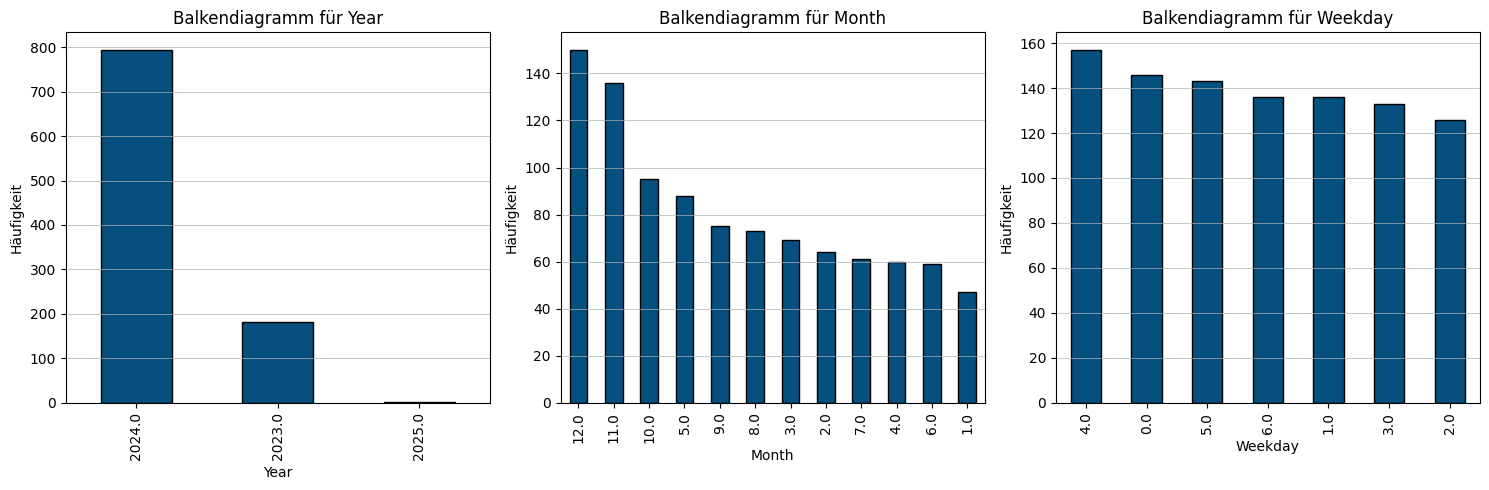

In [651]:
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(new_categorical_cols) // ncols) + (len(new_categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede kategorische Spalte iterieren und Balkendiagramme erstellen
for i, col in enumerate(new_categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    # Häufigkeiten der Kategorien berechnen
    value_counts = df_training[col].value_counts()
    # Balkendiagramm erstellen
    value_counts.plot(kind='bar', ax=ax, color=color2, edgecolor='black')
    ax.set_title(f"Balkendiagramm für {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Häufigkeit")
    ax.grid(axis='y', linewidth=0.5)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

Da der Datensatz erst Oktober 2023 beginnt und am 01.01.2025 endet, ist es nur logisch, dass 2024 die höchsten Werte beinhaltet. Ebenso gilt dies für die Monate Oktober bis Dezember. Die kommen einmal für 2023 und für 2024 vor und haben so eine größere Chance aufzutauchen.  
Fachlich gesehen, ist es nicht sinnig nach Saisonalitäten zu schauen, sondern eher nach der Frage zu gehen "Wie aktuell halten die Kunden das Update". Insofern wäre eine stetige Variable mit dem Max-Wert - tatsächlichen Wert sinnvoller, um zu sehen, ob ein Zusammenhang darin besteht "Je älter das letzte Update, desto weniger wahrscheinlich ist der Kauf des neuen Modells".

In [652]:
max_date = df_training['Most current software update'].max()
df_training['Days since Update'] = (max_date - df_training['Most current software update']).dt.days
df_training['Days since Update'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: Days since Update
Non-Null Count  Dtype  
--------------  -----  
977 non-null    float64
dtypes: float64(1)
memory usage: 7.9 KB


##### Einblick in neue numerische Spalte Days since Update  

In [653]:
df_training['Days since Update'].describe()

count    977.000000
mean     220.004094
std      128.873365
min        0.000000
25%      110.000000
50%      221.000000
75%      329.000000
max      448.000000
Name: Days since Update, dtype: float64

<Axes: >

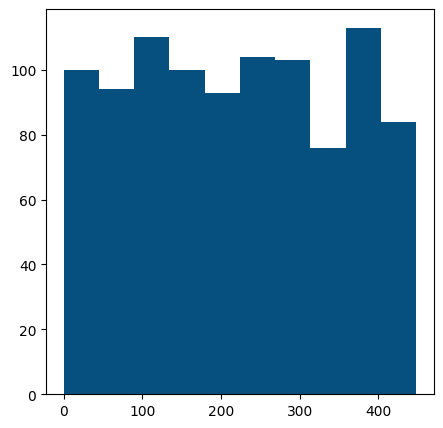

In [654]:
# Histogramm für 'Days since Update'
df_training['Days since Update'].hist(figsize=(5,5), color= hex_to_rgb_normalized(color2), grid=False)

<Axes: >

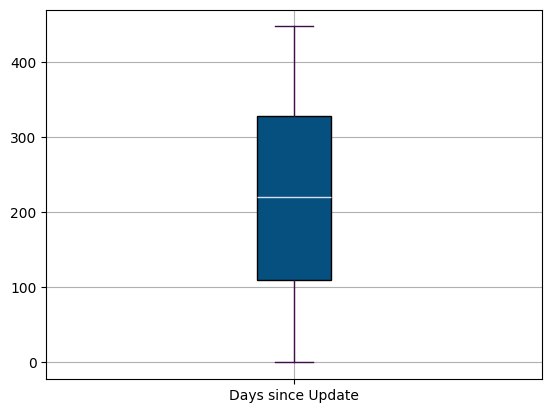

In [655]:
#Boxplot für 'Days since Update'
df_training.boxplot(column='Days since Update', patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

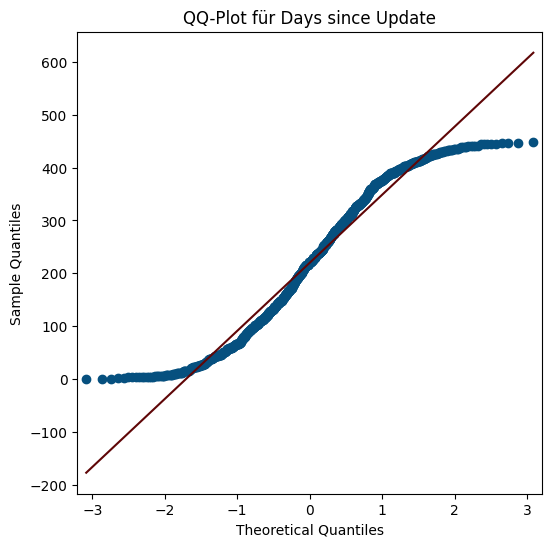

In [656]:
# QQ-Plot für 'Days since Update'
# Erstelle ein Plot-Objekt und eine Achse
fig, ax = plt.subplots(figsize=(6, 6))

 # QQ-Plot erstellen, aber diesmal speichern wir das Objekt (der Plot wird hier erstellt)
qq = qqplot(df_training['Days since Update'].dropna(), line='s', ax=ax)

# Extrahiere die Linienobjekte
lines = ax.get_lines()

# Setze die Farbe der Linie (die theoretische Normalverteilungslinie)
lines[1].set_color(color3)  # Die zweite Linie ist die 'line=s' Linie

# Setze die Farbe der Datenpunkte (erste Linie ist der Scatterplot)
lines[0].set_markerfacecolor(color2)
lines[0].set_markeredgecolor(color2)

# Achsentitel und Gitter
ax.set_title(f"QQ-Plot für Days since Update")
ax.grid(False)

plt.show()

In [657]:
# Schiefe
skewness = df_training['Days since Update'].skew()

skewness_df = pd.DataFrame({
    'Spalte': ['Days since Update'],
    'Schiefe': [skewness],
    'Kategorie': [categorize_skewness(skewness)]
})

skewness_df

Spalte   Schiefe         Kategorie
0  Days since Update  0.023679  eher symmetrisch

In [658]:
print(f'\nShapiro-Wilk Test für Spalte: Days since Update')
shapiro_wilk_test(df_training['Days since Update'].dropna(), 0.05)
print('-' * 40)


Shapiro-Wilk Test für Spalte: Days since Update
Statistics=0.956, p=0.00000
Sample sieht nicht normalverteilt aus (H0 wird verworfen).
----------------------------------------


Die neue Spalte zeigt am ehesten eine symmetrische Gleichverteilung. Bei Nutzung der Spalte müsste eine Transformation erfolgen.

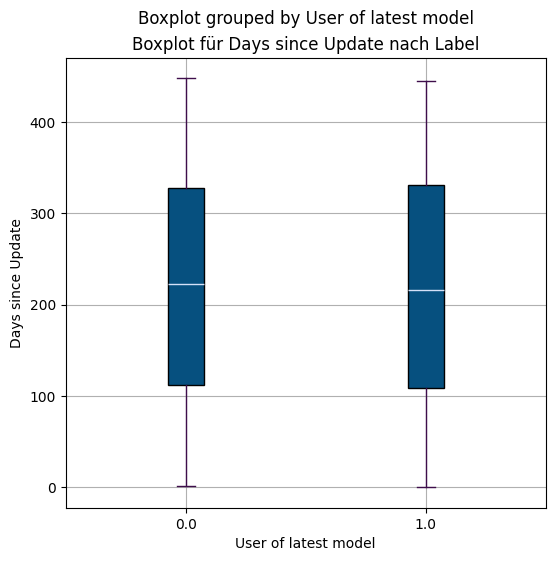

In [659]:
# Boxplot für 'Days since Update' nach Label
# Subplots erstellen
fig, ax = plt.subplots(figsize=(6, 6))

# Boxplot für die Zielspalte auf der x-Achse (label)
df_training.boxplot(column='Days since Update', by=label, ax=ax, patch_artist=True,
                    boxprops=dict(facecolor=color2, color='black'), 
                    whiskerprops=dict(color=color4),
                    flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                    capprops=dict(color=color4),
                    medianprops=dict(color=color5))

# Titel und Achsenbeschriftung anpassen
ax.set_title(f"Boxplot für Days since Update nach Label")
ax.set_xlabel(label)
ax.set_ylabel('Days since Update')
ax.grid(True)


<Axes: >

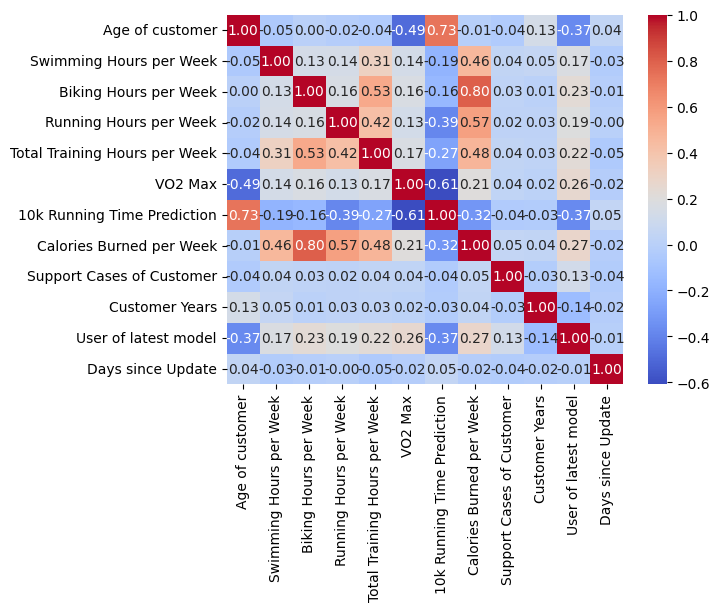

In [660]:
# Korrelationsmatrix mit Days since Update
corr = df_training[numerical_cols.tolist() + ['Days since Update']].corr()
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt=".2f")

In [661]:
# ANOVA-Test für 'Days since Update' und Label
feature_name = 'Days since Update'

data_anova = pd.concat([df_training[feature_name], df_training[label]], axis=1)
data_anova = data_anova.dropna()

for category in data_anova[label].unique():
    groups.append(data_anova[data_anova[label] == category][feature_name])

stat, p = f_oneway(*groups)
print(f'P-Wert für {feature_name} und {label}: {p}')

P-Wert für Days since Update und User of latest model: 0.0


Das neue Feature scheint nicht wirklich einen Zusammenhang zu anderen numerischen Variablen aufzuweisen. Grafisch konnte auch kein Unterschied in der Verteilung der Daten je nach Label-Ausprägung erkannt werden. Laut ANOVA-Test hat das neue Feature jedoch einen Einfluss auf das Label.

#### Einblick Zusammenhänge

In [662]:
categorical_cols = [item for item in categorical_cols if item not in ['Most current software update', 'ID']]
categorical_features = features[categorical_cols]
categorical_features

Sex       Ctry        Town Goal of Training  \
0     Other         UK  Birmingham          Fitness   
1     Other  Australia      Sydney          Fitness   
2     Other      India   Bangalore      Competition   
3      Male    Germany      Munich       Recreation   
4      Male      India      Mumbai       Recreation   
..      ...        ...         ...              ...   
995  Female  Australia    Brisbane       Recreation   
996  Female  Australia   Melbourne       Recreation   
997   Other        USA    New York          Fitness   
998   Other    Germayn      Berlin          Fitness   
999    Male      India      Mumbai          Fitness   

    Preferred Training Daytime Subscription Type Color of Watch  \
0                      Evening              Free          White   
1                      Evening           Premium          Black   
2                    Afternoon              Free          White   
3                      Evening           Premium          Black   
4                      Morning             Basic          Black   
..                         ...               ...            ...   
995                    Morning           Premium          Black   
996                  Afternoon              Free          Black   
997                  Afternoon           Premium          Black   
998                    Evening              Free          Black   
999                  Afternoon           Premium          Black   

    Synchronisation  Support Cases of Customer  Customer Years  
0               Yes                        2.0             1.0  
1               Yes                        2.0             1.0  
2               Yes                        2.0             0.0  
3                No                        3.0             0.0  
4               Yes                        3.0             3.0  
..              ...                        ...             ...  
995             Yes                        0.0             3.0  
996             Yes                        0.0             3.0  
997             Yes                        4.0             6.0  
998             NaN                        3.0             3.0  
999             Yes                        0.0             7.0  

[1000 rows x 10 columns]

**Variation Ratio** 

In [663]:
non_continous_feature_data_var = categorical_features.apply(lambda x: x.value_counts(normalize=True).max(), axis=0)
non_continous_feature_data_var_ratio=1-non_continous_feature_data_var
non_continous_feature_data_var_ratio.sort_values(ascending=False)

Town                          0.919063
Customer Years                0.847648
Ctry                          0.795501
Support Cases of Customer     0.787321
Subscription Type             0.650972
Goal of Training              0.650526
Preferred Training Daytime    0.649895
Sex                           0.647239
Color of Watch                0.269556
Synchronisation               0.115789
dtype: float64

Die grafische Analyse der Verteilung der kategorischen Daten wird hier noch einmal bestätigt. `Color of Watch` und `Synchronisation` zeigen zu wenig Variation, um von einem Erklärwert für das Label ausgehen zu können.

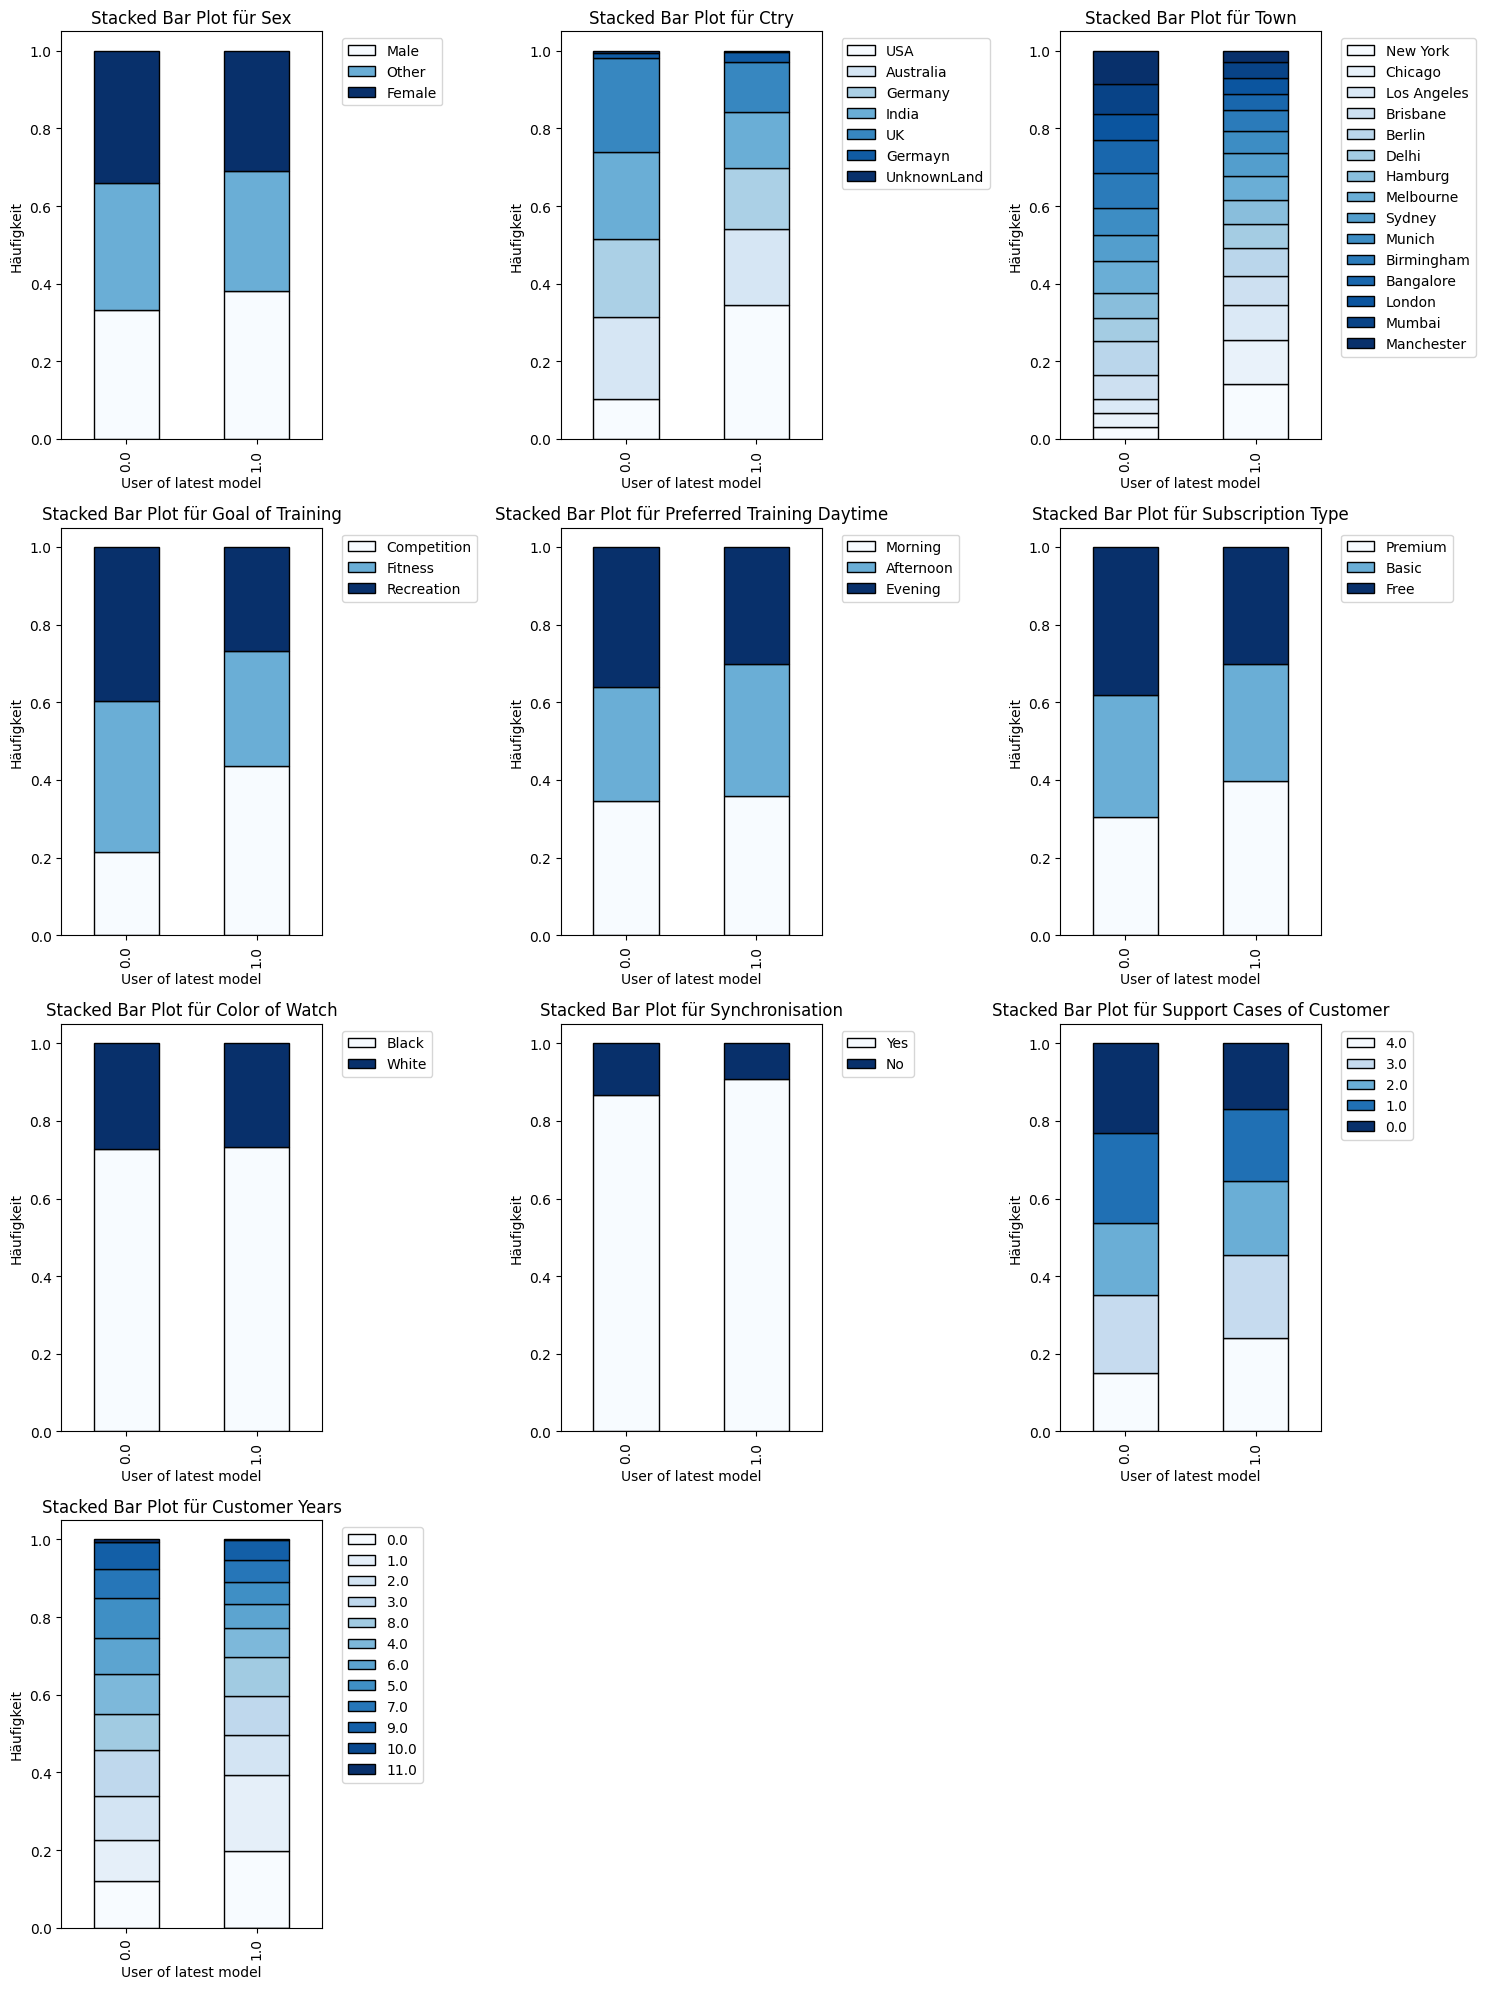

In [664]:
# Anteile der Kategorien je nach Labelausprägung
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Iteriere über jede kategorische Spalte
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    
    # Gruppiere nach der Zielspalte und zähle die Häufigkeit jeder Kategorie
    grouped = df_training.groupby([label, col]).size().unstack(fill_value=0)

    # Berechne die Anteile der Kategorien für label = 1 (Zielspalte ist 1)
    proportions_label_1 = grouped.loc[1].div(grouped.loc[1].sum())

    # Sortiere die Kategorien nach den Anteilen von label = 1 in absteigender Reihenfolge
    sorted_columns = proportions_label_1.sort_values(ascending=False).index

    # Reorganisiere die gruppierten Daten basierend auf der sortierten Reihenfolge
    grouped_sorted = grouped[sorted_columns]

    # Normalisierte Gruppen berechnen
    normalized_grouped = grouped_sorted.div(grouped_sorted.sum(axis=1), axis=0)

    # Stacked Bar Plot erstellen
    normalized_grouped.plot(kind='bar', stacked=True, ax=ax, colormap='Blues', edgecolor='black')

    # Achsentitel und Labels
    ax.set_title(f"Stacked Bar Plot für {col}")
    ax.set_xlabel(label)
    ax.set_ylabel('Häufigkeit')
    ax.grid(False)

    # Legende nach rechts verschieben
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Verschiebe die Legende nach rechts

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()


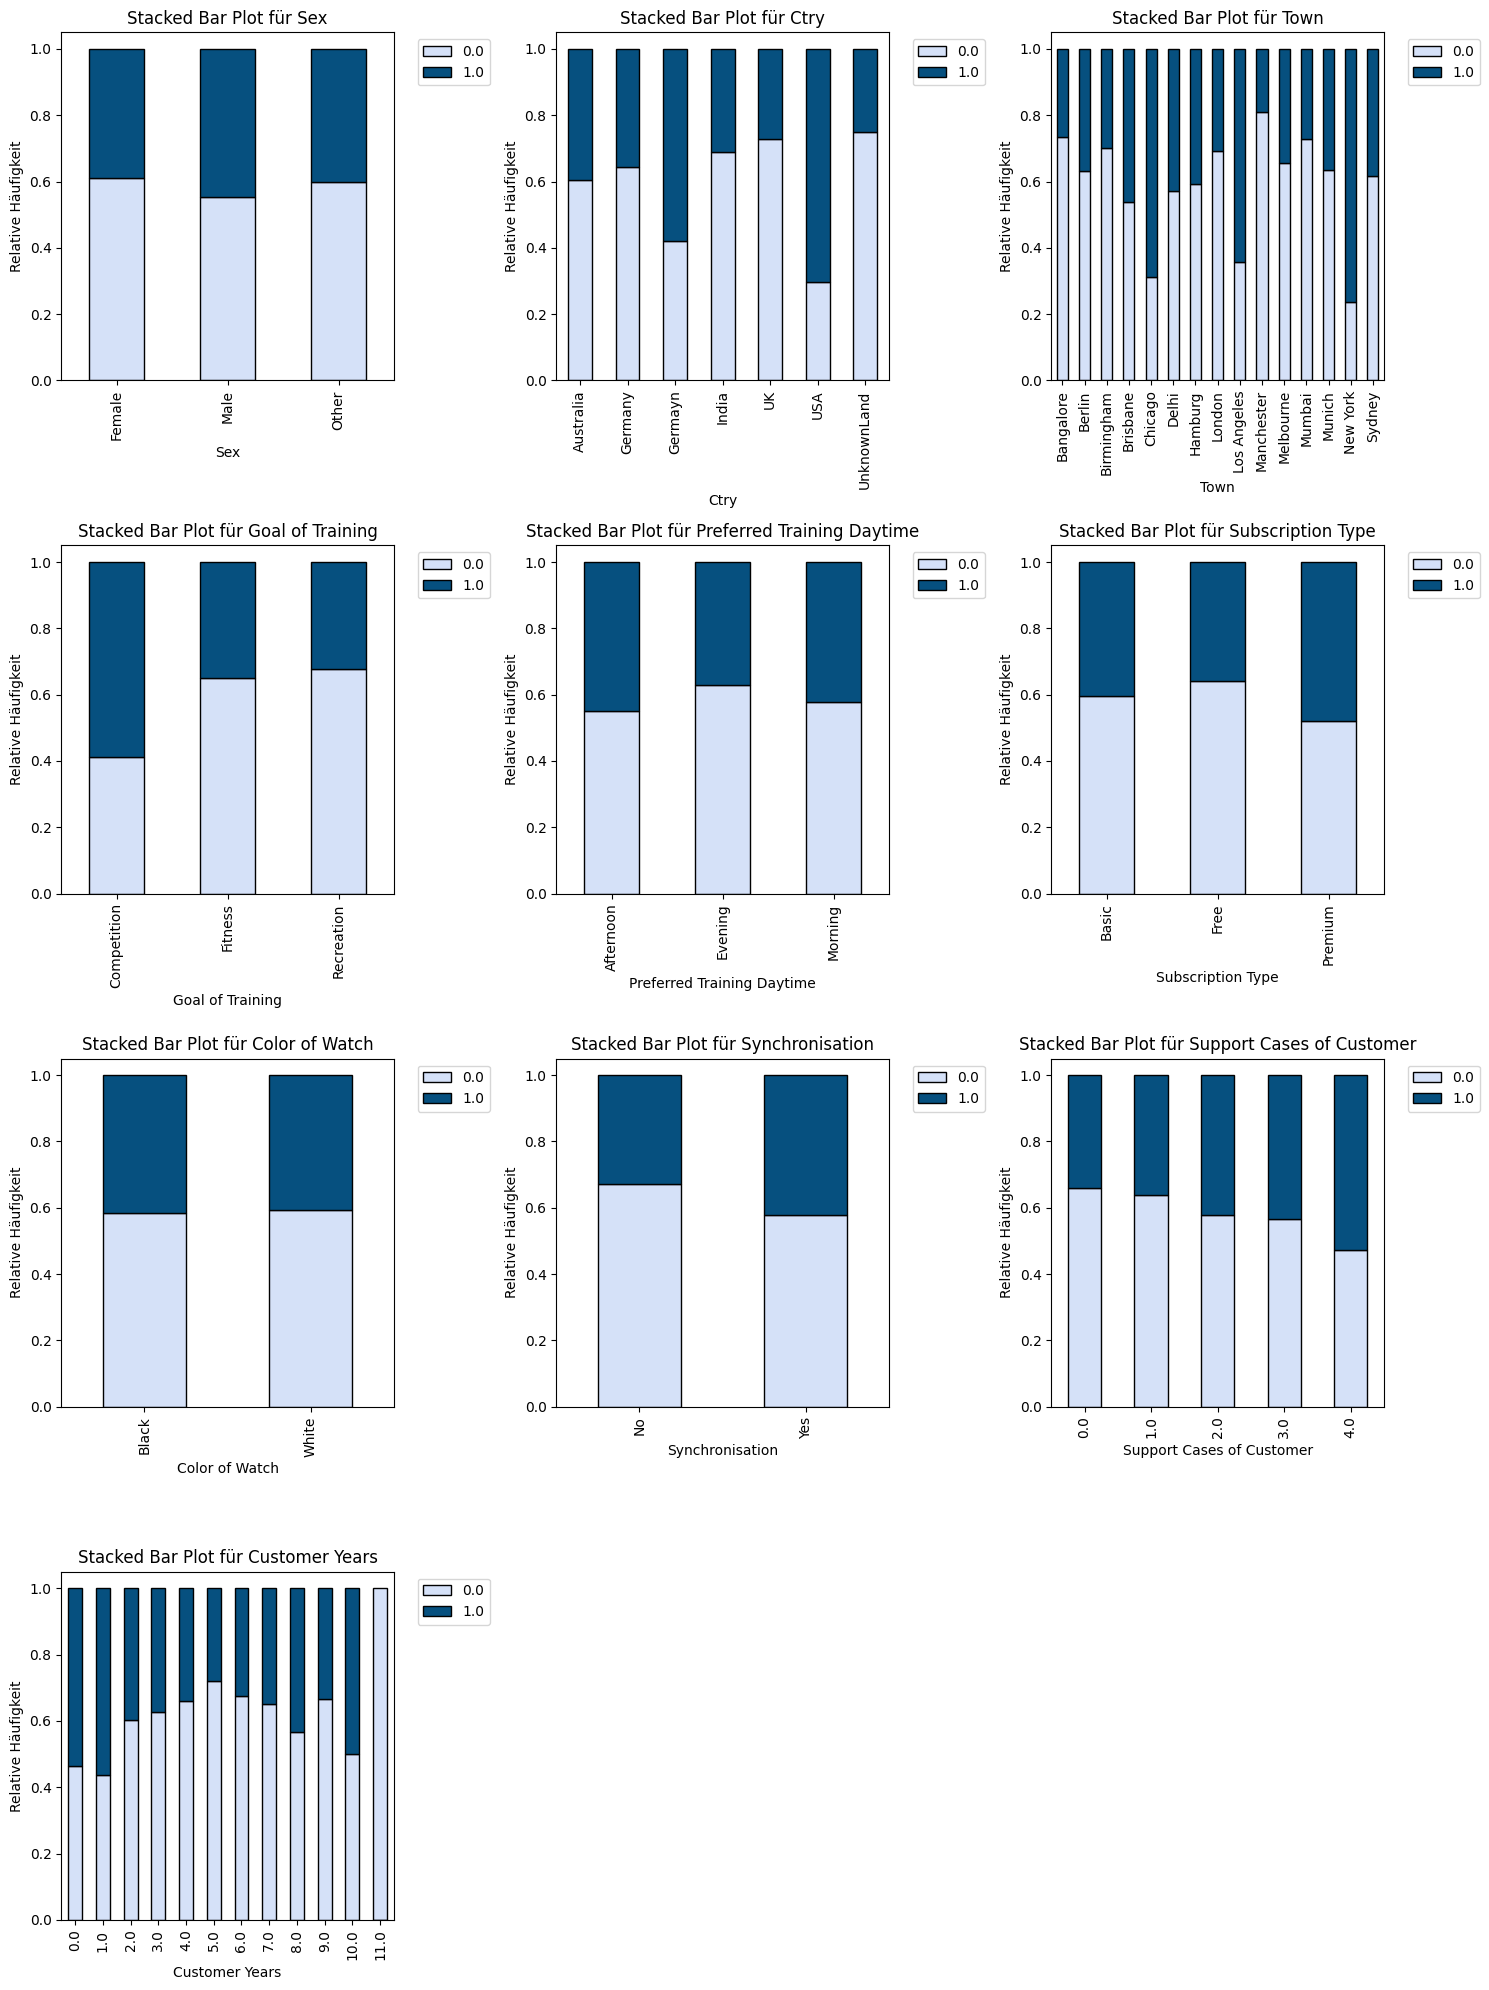

In [665]:
# Anteil Labelausprägungen je Kategorie
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Iteriere über jede kategorische Spalte
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    
    # Gruppiere nach dem Label und berechne die Häufigkeit der Kategorien
    data = pd.crosstab(df_training[col], df_training[label])
    
    # Normalisiere die Daten, sodass sie die relativen Häufigkeiten darstellen
    data = data.div(data.sum(axis=1), axis=0)
    
    # Stacked Bar Plot erstellen
    data.plot(kind='bar', stacked=True, ax=ax, edgecolor='black', color=[color5, color2]) 


    # Achsentitel und Labels
    ax.set_title(f"Stacked Bar Plot für {col}")
    ax.set_xlabel(col)
    ax.set_ylabel('Relative Häufigkeit')
    ax.grid(False)

    # Legende nach rechts verschieben
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))  # Verschiebe die Legende nach rechts

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen und Plot anzeigen
plt.tight_layout()
plt.show()


**Erkenntisse grafische Darstellung**
- `Sex`, `Preferred Training Daytime`, `Color of Watch`   
Kaum Unterschiede in den Anteiligkeiten je nach Label erkennbar
- `Ctry`, `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years`, `Synchronisation`  
Unterschiede in den Anteiligkeiten je nach Label erkennbar

**Chi2-Test**

In [666]:
features_non_continous = df_training[categorical_cols + ['ID']]
non_continous_df = pd.concat([features_non_continous, df_training[label]], axis=1)

In [667]:
non_cont_columns = non_continous_df.columns

#create a new dataframe which contains chi2 values for all feature combinations
chi2_values = pd.DataFrame(index=non_cont_columns, columns=non_cont_columns)
for i in non_cont_columns:
    for j in non_cont_columns:
        df_chi2 = non_continous_df[[i,j]]
        data_cont=pd.crosstab(df_chi2.iloc[:,0], df_chi2.iloc[:,1])
        stat, p, dof, expected = chi2_contingency(data_cont)
        chi2_values.loc[i,j] = p

<Axes: >

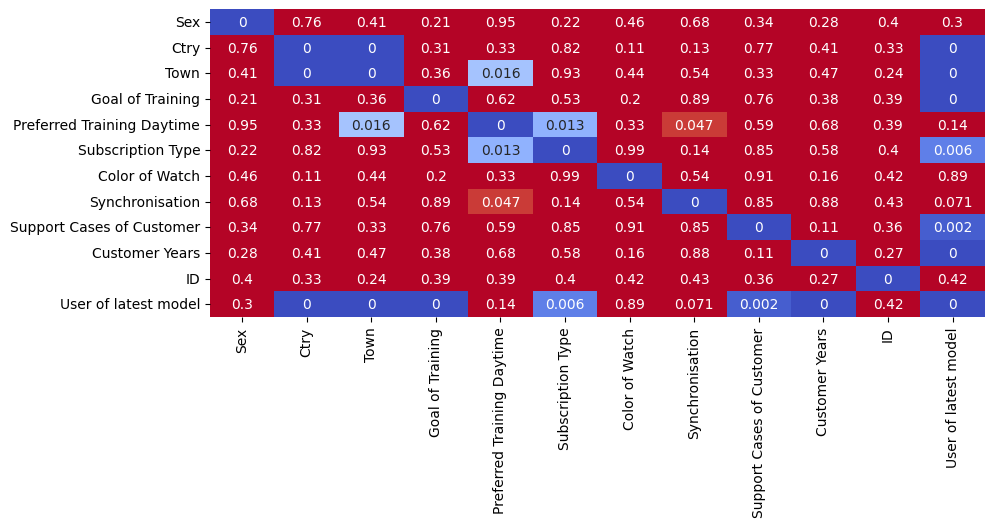

In [668]:
plt.figure(figsize=(10,4))
sns.heatmap(round(chi2_values.astype(float),3), annot=True, cmap='coolwarm', cbar=False, vmin=0, vmax=0.05)

**Erkenntisse Chi2-Test**
- `Sex`, `Preferred Training Daytime`, `Color of Watch`, `Synchronisation`  
Keinen Einfluss auf Label
- `Ctry`, `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years`  
Einfluss auf Label

### EDA kategorische und numerische Spalten  
Neben den Zusammenhängen mit dem Label werden hier weitere Zusammenhänge untersucht, die beim Lösen der Datenqualitätsprobleme helfen könnten.  

Für folgende Spalten ist noch nicht genau klar, wie eine Imputation von Missing Values / Nonsense Data erfolgen kann.

- `Town`  
Es ist bereits deutlich, dass die Missing Values von dieser Spalte mit Hilfe `Ctry` gefühlt werden kann. Für ein Land stehen jedoch mehrere Städte potenziell zur Auswahl. Daher werden noch mehr Informationen für die genaue Imputation benötigt.  
Zu füllende Werte: 39

- `Most current software update` bzw. `Days since Update`  
Bisher noch keine Information gesammelt, die für die Imputation von diesem Wert nützlich wäre. Aufgrund möglicher Relevanz von  `Days since Update` für das Label sollte allerdings eine Impuation erfolgen.  
Zu füllende Werte: 1
- `Goal of Training`  
Bisher noch keine Information gesammelt, die für die Imputation von diesem Wert nützlich wäre. Aufgrund Relevanz für das Label, sollte jedoch eine Impuation erfolgen.  
Zu füllende Werte: 28  
- `Preferred Training Daytime`  
Die Spalte zeigt einen Zusammenhang zu `Town` und `Subscription Type`. Allerdings sind beide Spalten noch unvollständig. Ebenfalls ist fraglich, ob sich eine Imputation lohnt, da kein Zusammenhang zum Label besteht.  
Zu füllende Werte: 24 
- `Synchronisation`  
Die Spalte zeigt keinen Zusammenhang zu anderen kategorischen Spalten. Der Zusammenhang zum Label konnte mit Hilfe Chi2-Test nicht nachgewiesen werden. Ebenfalls ist der Erklärwert durch die geringe Varianz in der Spalte begrenzt. Daher ist es fraglich, ob sich eine Impuation lohnt.  
Zu füllende Werte: 27 (28 nach Löschung 22 Zeilen ohne Label - 1 Löschung Duplikat mit fehlendem Wert in dieser Spalte)
- `Color of Watch`  
Die Spalte weist bisher keinen Zusammenhang zu anderen kategorischen Spalten oder dem Label auf. Die Anteile des Labels unterscheiden sich überhaupt nicht je nach Farbe. Daher wird geraten, dass Feature zu löschen.  
Zu füllende Werte: 32
- `Subscription Type`  
Es besteht ein Zusammenhang zu `Preferred Training Daytime`. Diese ist jedoch unvollständig. Aufgrund Relevanz für das Label, sollte eine Imputation erfolgen.  
Zu füllende Werte: 1  
- `Age of customer`  
Enthält zwar keine fehlenden Werte, allerdings sollte eine Lösung für den Datenfehler von -1 gefunden werden. Das Alter weist einen positiven Zusammenhang mit `10k Running Time Prediction`. Der Scatterplot deutet jedoch an, dass die Beziehung zwischen den Variablen nicht rein linear ist.
Zu ersetzende Werte: -1
- `Calories Burned per Week`  
Zeigt einen positiven Zusammenhang zu allen Trainingszeiten, am deutlichsten jedoch mit `Biking Hours per Week`.  
Zu füllende Werte: 19
- `VO2 Max`  
Sowohl die fehlenden Werte als auch die 6 identifizierten Zeilen mit Ausreißer (nach Löschung leerer Label-Zeilen) müssen behandelt werden. Es existiert ein Zusammenahang zu `10k Running Time Prediction` sowie `Age of customer`. Nach Eliminierung der Ausreißer sollte ebenfalls ein Zusammenhang zu den Trainingszeiten und `Calories Burned per Week` existieren (vgl. Scatterplots)  
Zu füllende Werte: 10

*Fazit*  
`Town`, `Days since Update`, `Goal of Training`, `Subscription Type`, `Age of customer`, `Calories Burned per Week`, `VO2 Max` sollten näher untersucht werden.

#### Zusammenhang von Ziel-numerischen Variablen mit kategorischen Variablen

In [669]:
target_numeric = ['Calories Burned per Week', 'VO2 Max', 'Age of customer', 'Days since Update']

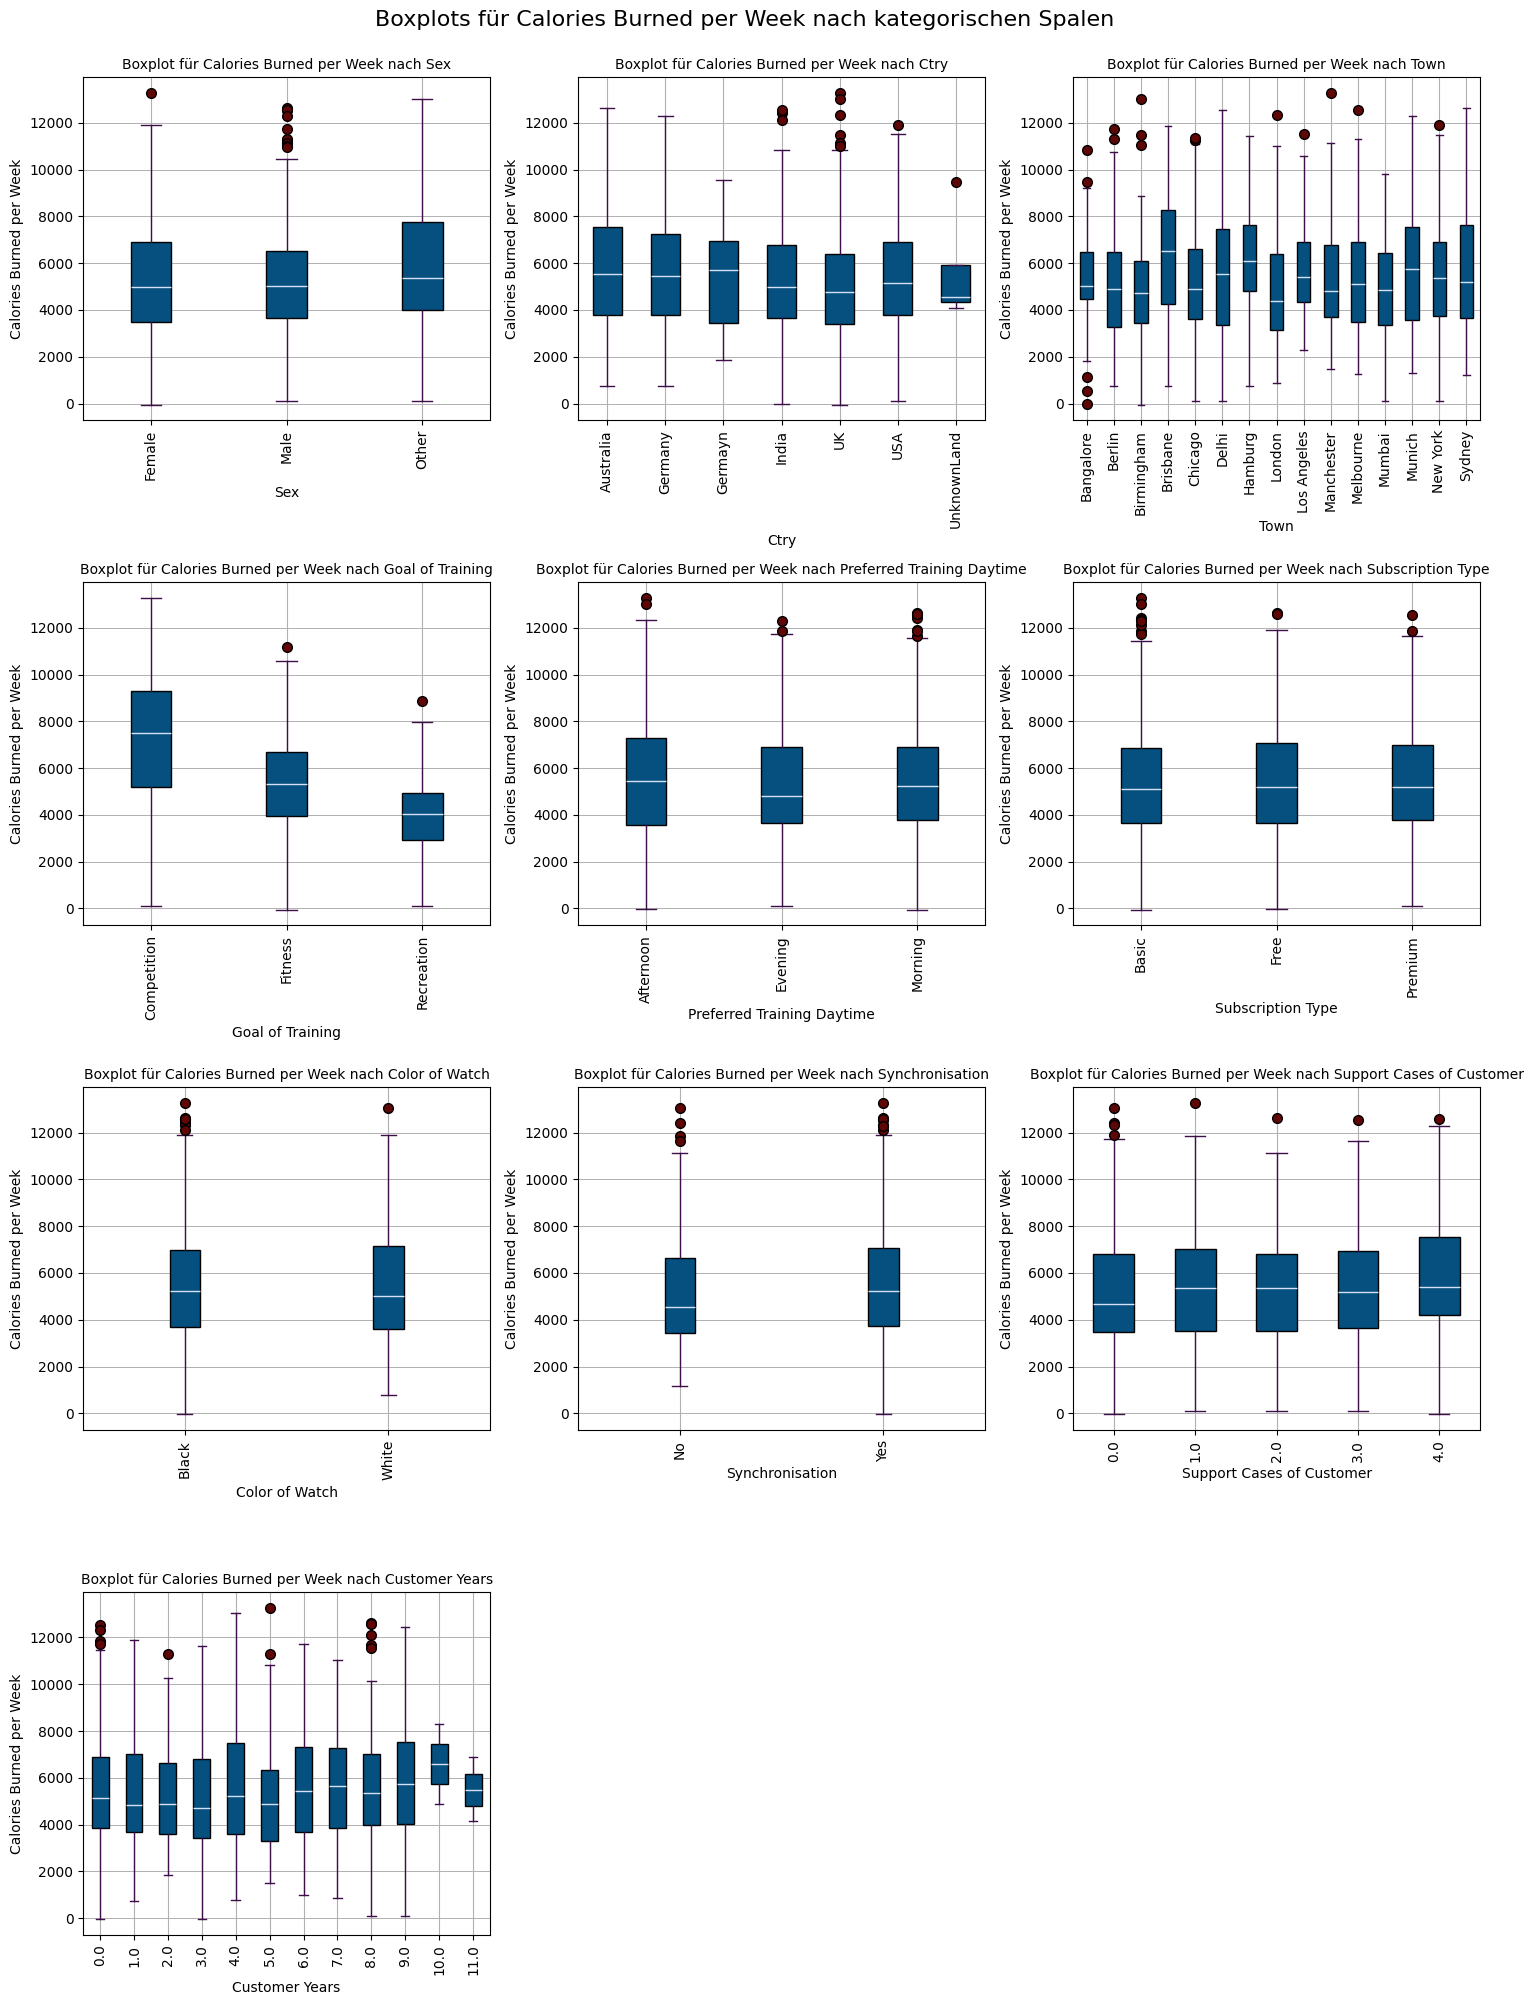

In [670]:
#Boxplots für Kalorienverbrauch pro Woche nach kategorischen Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

t_col = 'Calories Burned per Week'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=t_col, by=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {t_col} nach {col}", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(t_col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {t_col} nach kategorischen Spalen', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Zusammenhang mit Goal of Training.

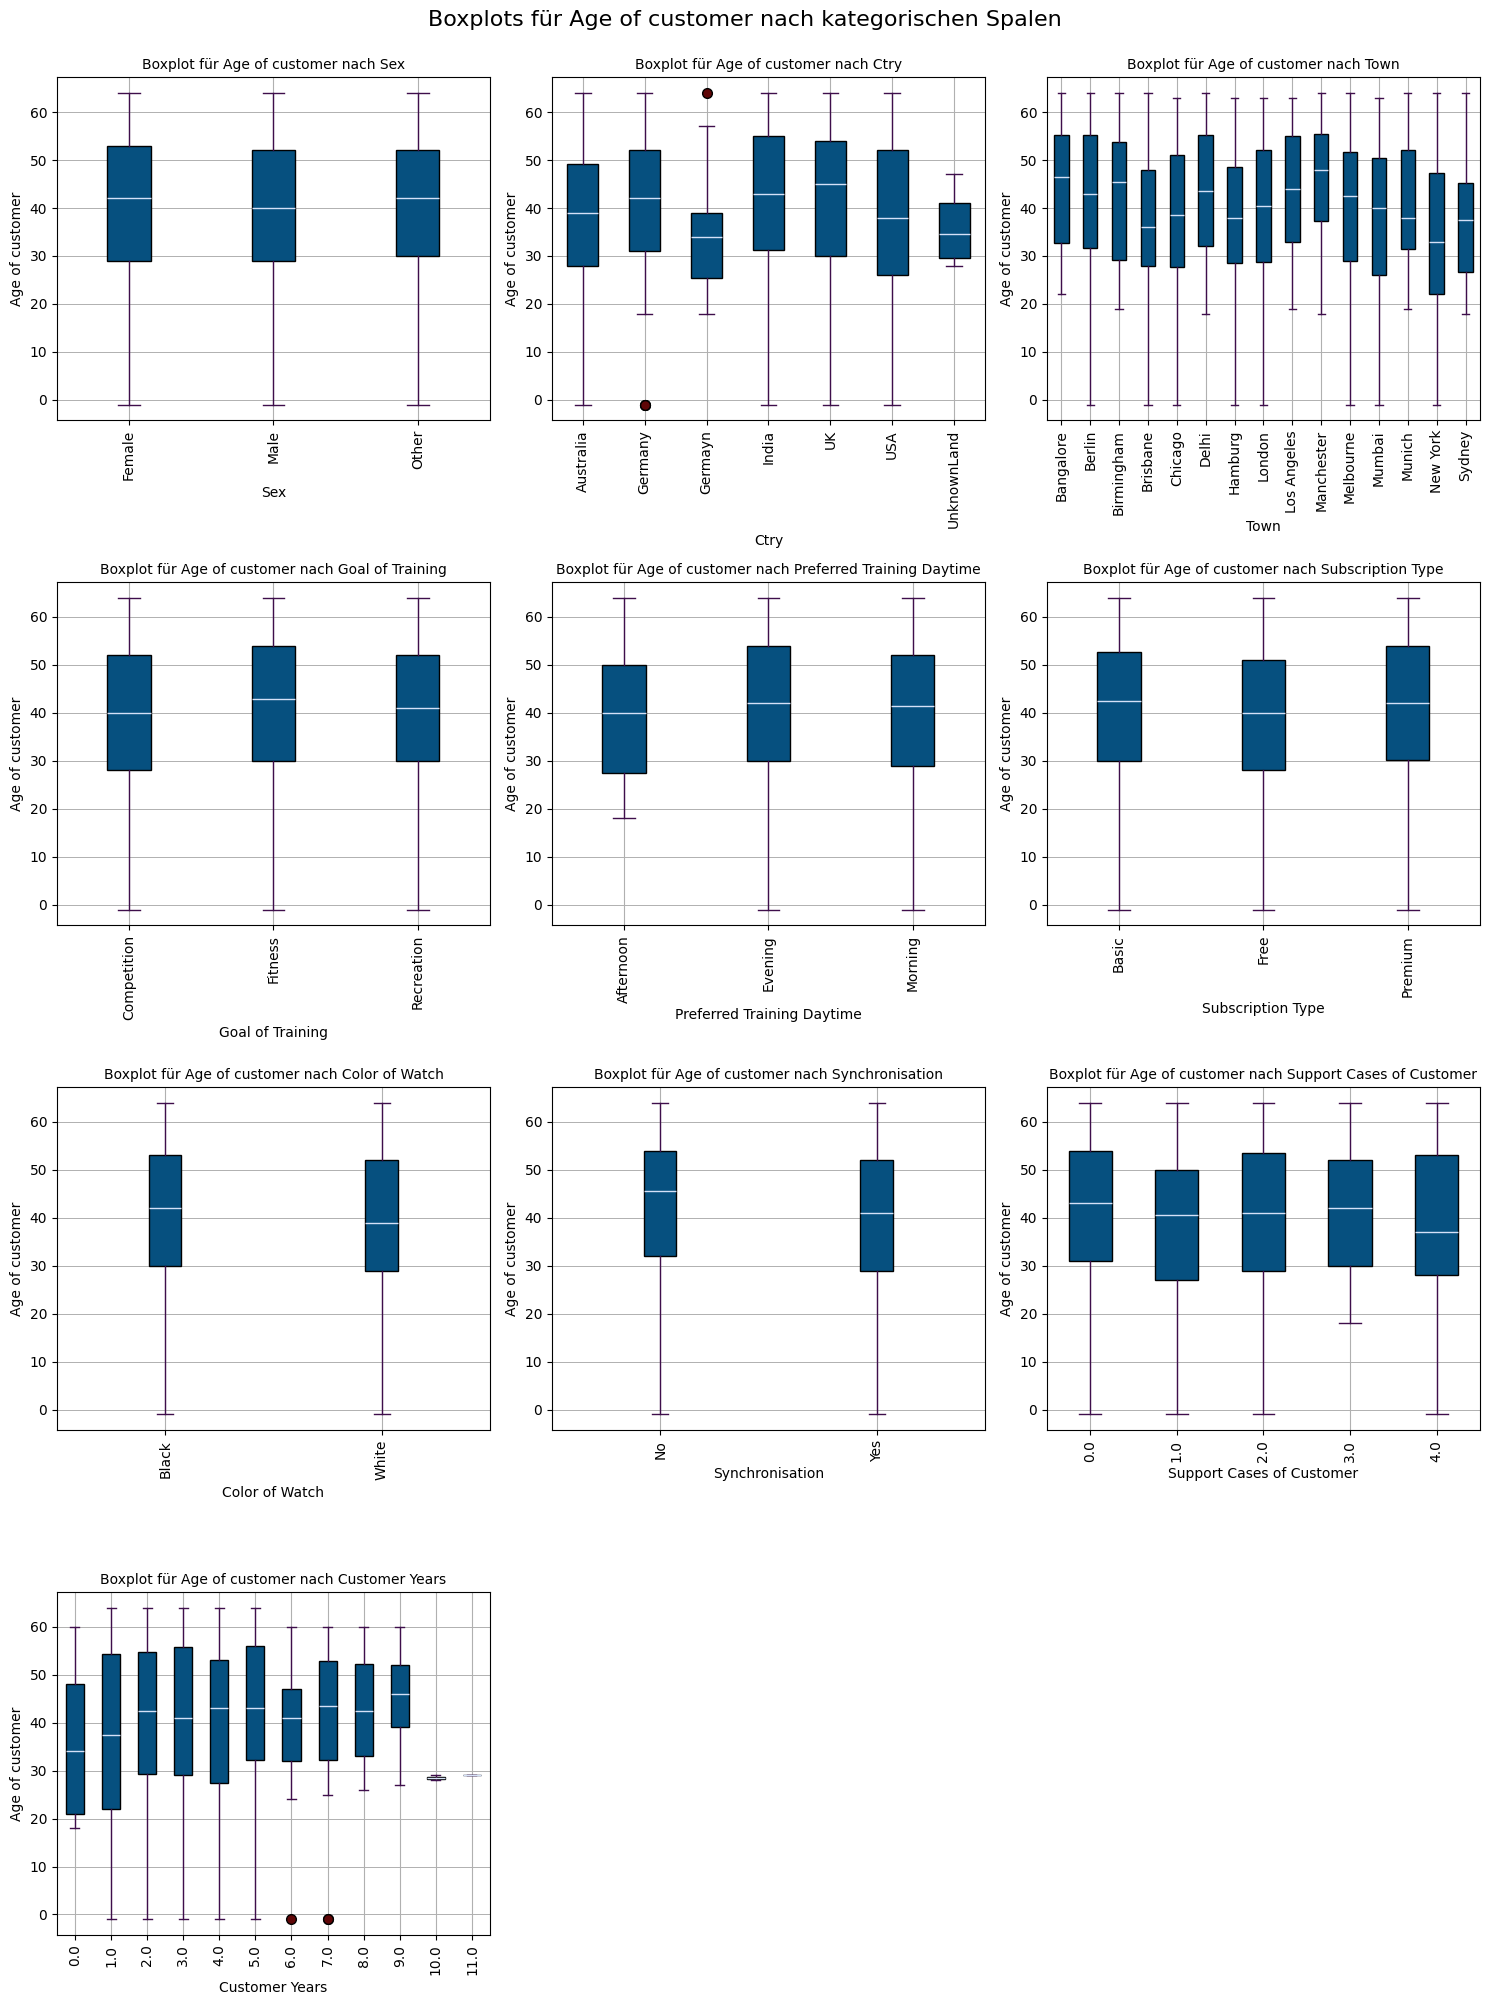

In [671]:
#Boxplots für Age of Customer nach kategorischen Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

t_col = 'Age of customer'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=t_col, by=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {t_col} nach {col}", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(t_col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {t_col} nach kategorischen Spalen', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Zusammenhang mit Customer Years und Town.

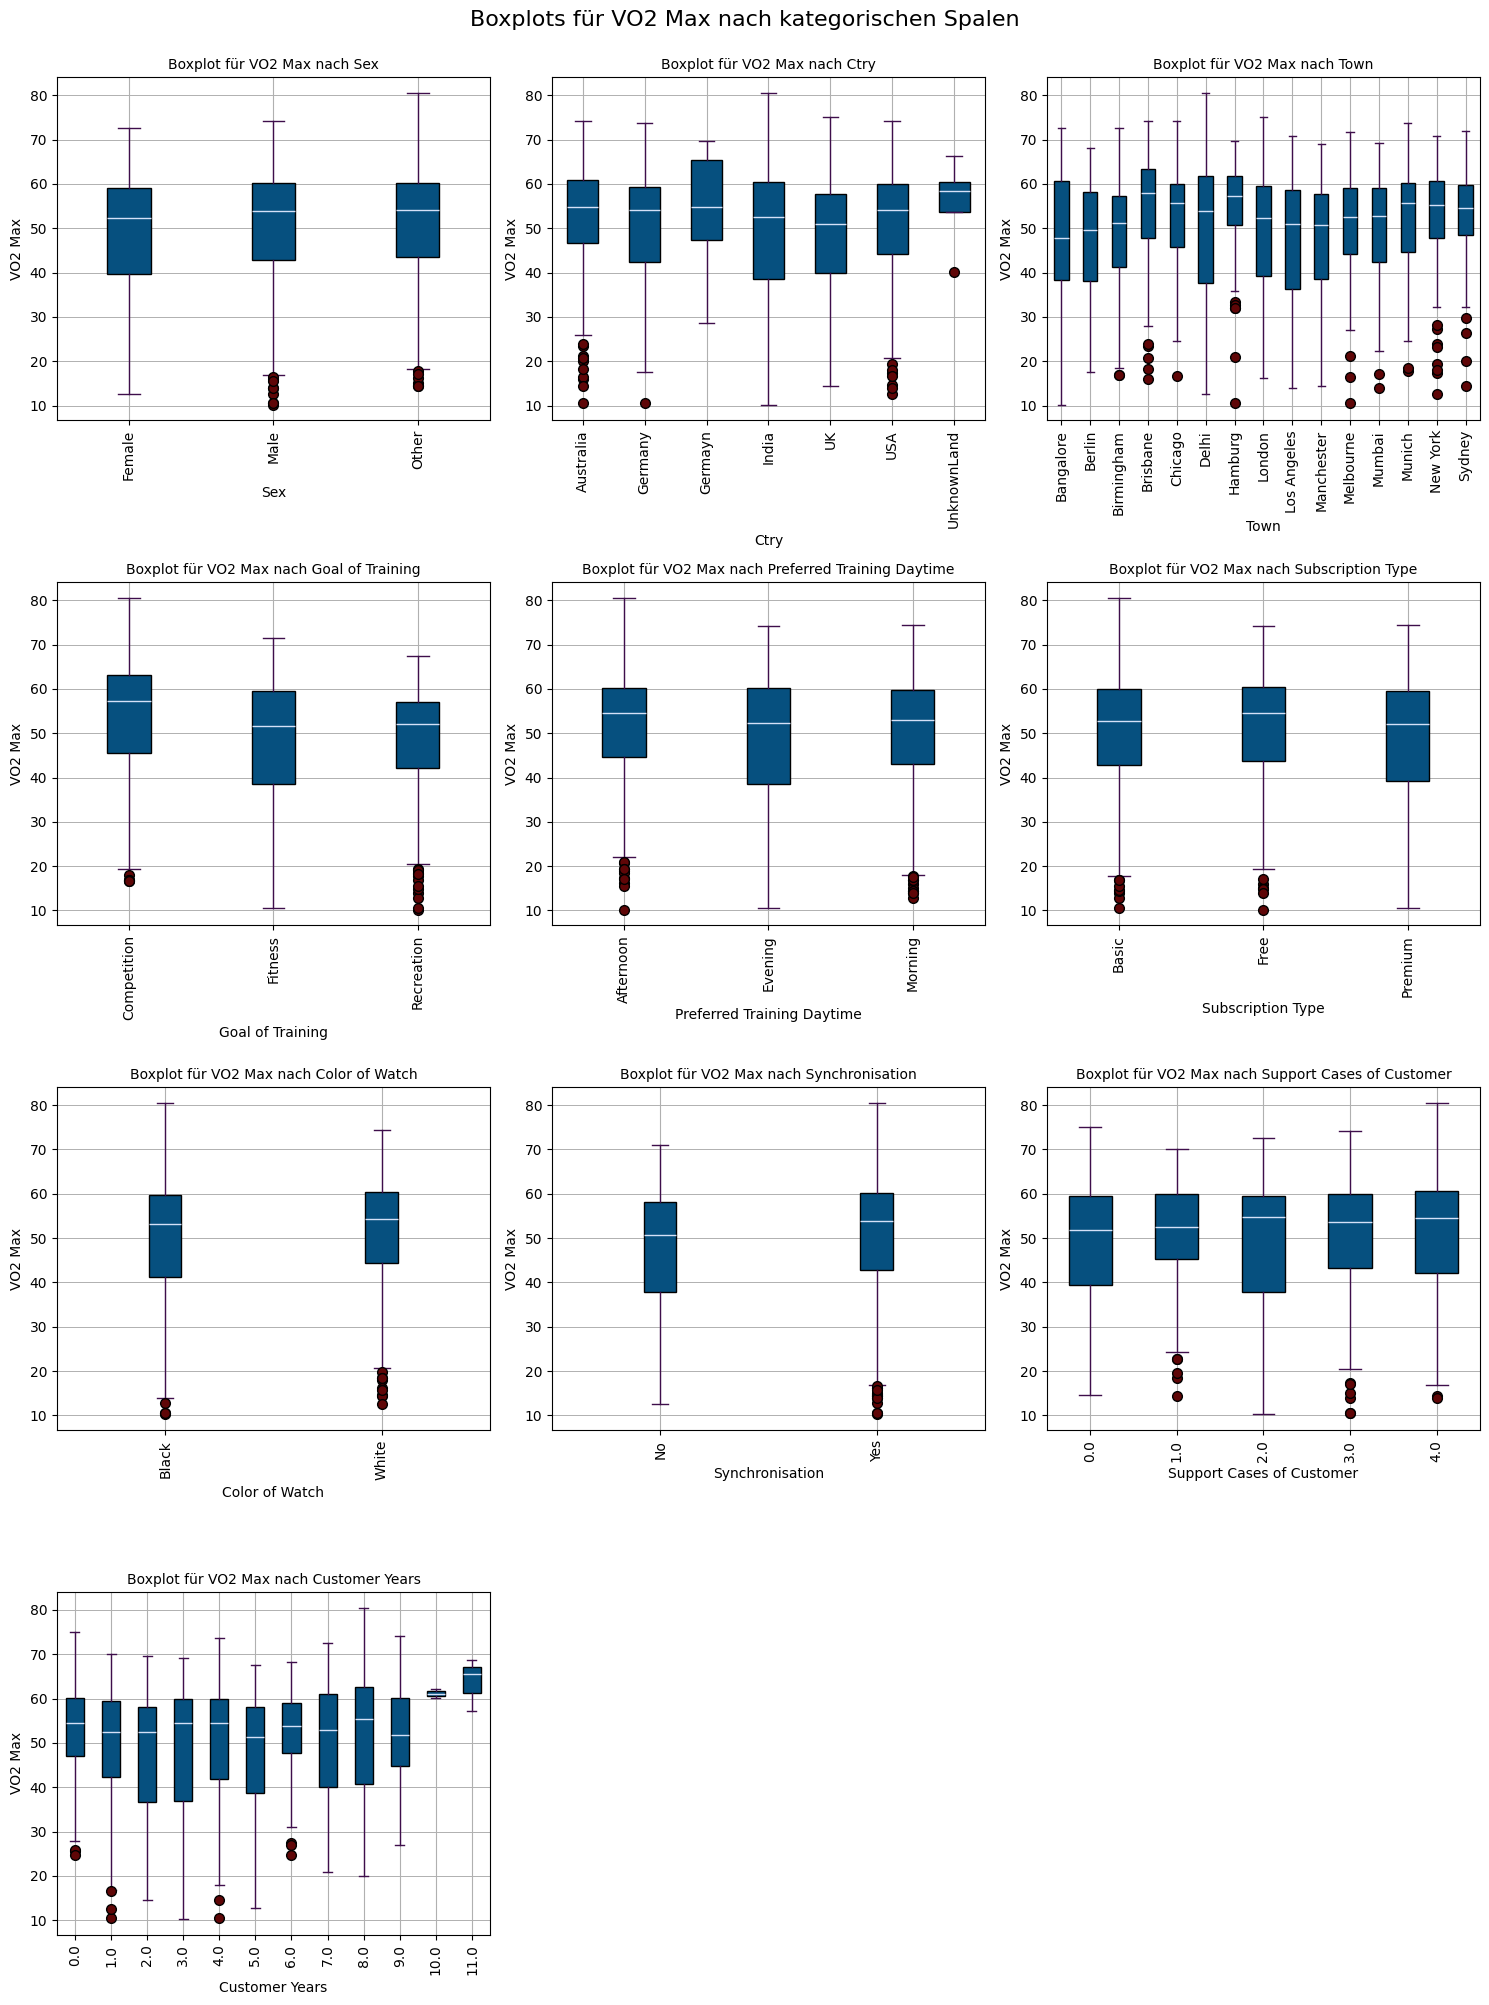

In [672]:
#Boxplots für VO2 Max nach kategorischen Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

t_col = 'VO2 Max'
# Herausfiltern von Ausreißern, sonst erkennt man nichts
df_training_filter = df_training[df_training['VO2 Max'] < 100]

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training_filter.boxplot(column=t_col, by=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {t_col} nach {col}", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(t_col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {t_col} nach kategorischen Spalen', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Zusammenhang mit Goal of Training.

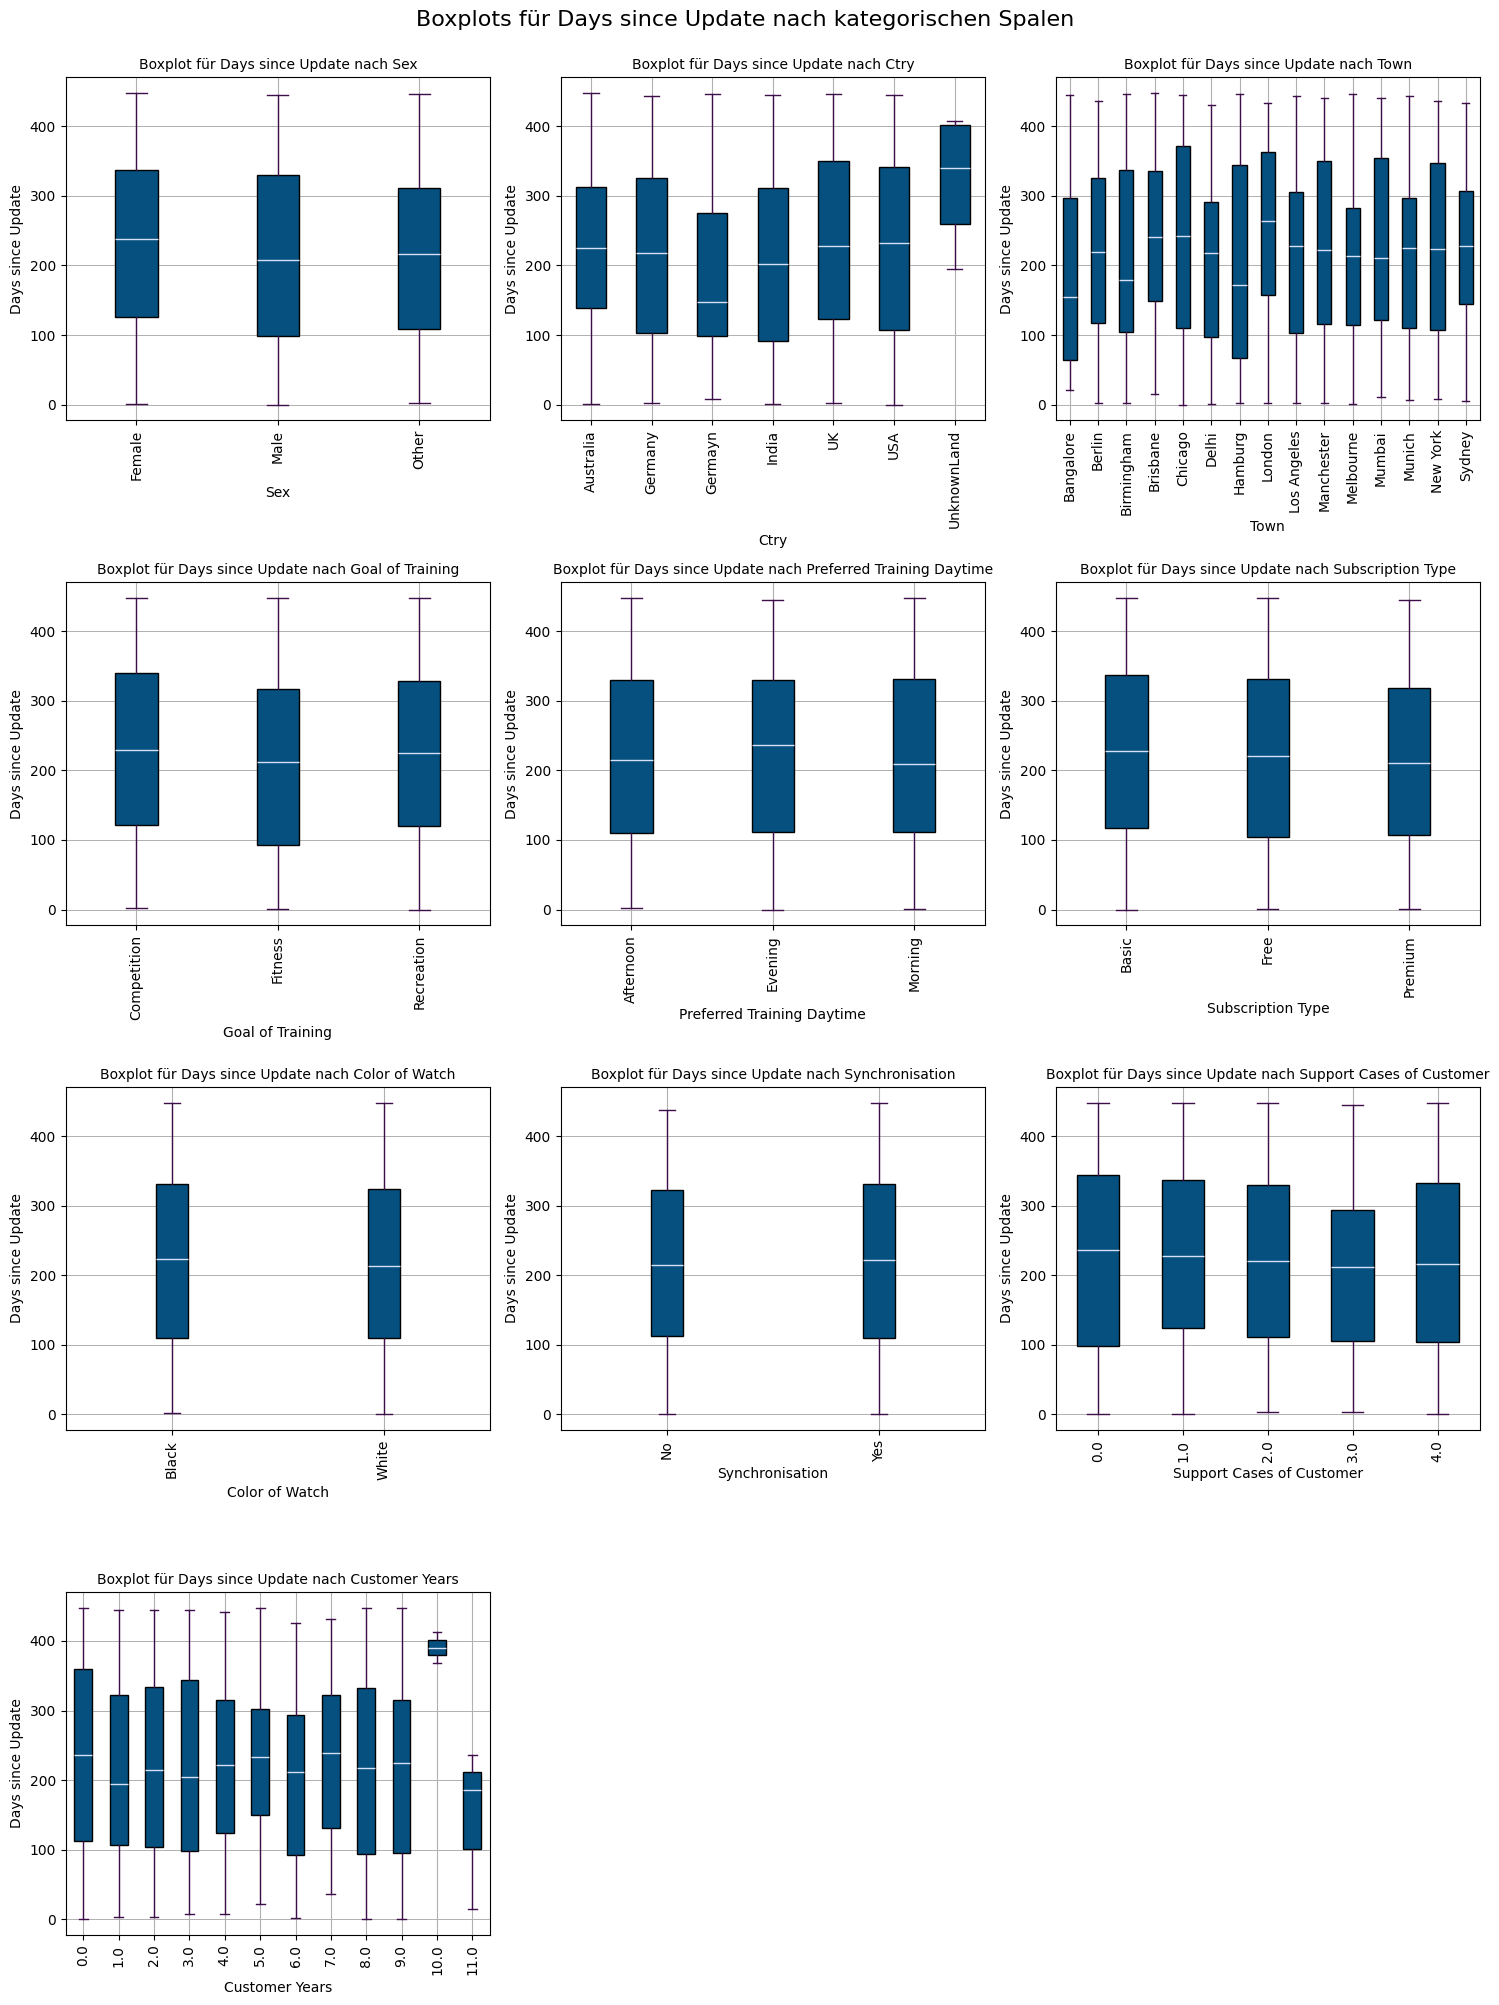

In [673]:
#Boxplots für Days since Update nach kategorischen Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

t_col = 'Days since Update'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=t_col, by=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {t_col} nach {col}", fontsize=10)
    ax.set_xlabel(col)
    ax.set_ylabel(t_col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {t_col} nach kategorischen Spalen', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Keine Zusammenhänge.

In [674]:
# Abschließender ANOVA-Test
# DataFrame für p-Werte erstellen (Zeilen: Labels, Spalten: numerische Features)
anova_p_values = pd.DataFrame(index=categorical_cols, columns=target_numeric)

# Schleife über Labels und numerische Features
for c in categorical_cols:
    for target in target_numeric:
        # Daten für ANOVA-Test vorbereiten
        data_anova = pd.concat([df_training[target], df_training[c]], axis=1).dropna()
        
        # Gruppen basierend auf den Kategorien im Label
        groups = []
        for category in data_anova[c].unique():
            groups.append(data_anova[data_anova[c] == category][target])
        
        # ANOVA-Test durchführen
        stat, p = f_oneway(*groups)
        anova_p_values.loc[c, target] = p  # p-Wert speichern

# Ergebnisse anzeigen
anova_p_values

Calories Burned per Week   VO2 Max Age of customer  \
Sex                                        0.006796  0.975237        0.844574   
Ctry                                       0.374941  0.597943        0.014938   
Town                                       0.041173  0.093718        0.000775   
Goal of Training                                0.0  0.003993        0.420323   
Preferred Training Daytime                 0.441963  0.200722        0.152488   
Subscription Type                           0.91305  0.612321        0.131568   
Color of Watch                             0.944773  0.763355        0.128585   
Synchronisation                            0.367411   0.04146        0.173918   
Support Cases of Customer                  0.211156  0.123346        0.048674   
Customer Years                             0.736684  0.715422        0.000071   

                           Days since Update  
Sex                                 0.214662  
Ctry                                0.207587  
Town                                0.485087  
Goal of Training                    0.065069  
Preferred Training Daytime          0.707553  
Subscription Type                   0.315094  
Color of Watch                      0.456688  
Synchronisation                     0.861185  
Support Cases of Customer           0.508439  
Customer Years                      0.609676

**Erkenntnisse ANOVA-Test**  

- `Calories Burned per Week`  
Zusammenhang mit `Sex` und `Goal of Training`
- `VO2 Max`  
Zusammenhang mit `Goal of Training` und `Synchronisation`
- `Age of customer`  
Zusammenhang mit `Ctry`, `Town`, `Support Cases of Customer`, `Customer Years`  
- `Days since Update`  
Kein Zusammenhang mit kategorischer Variable


#### Zusamenhang von Ziel-kategorischen Variablen mit numerischen

In [675]:
target_cat = ['Town', 'Goal of Training', 'Subscription Type', 'Preferred Training Daytime', 'Color of Watch', 'Synchronisation']

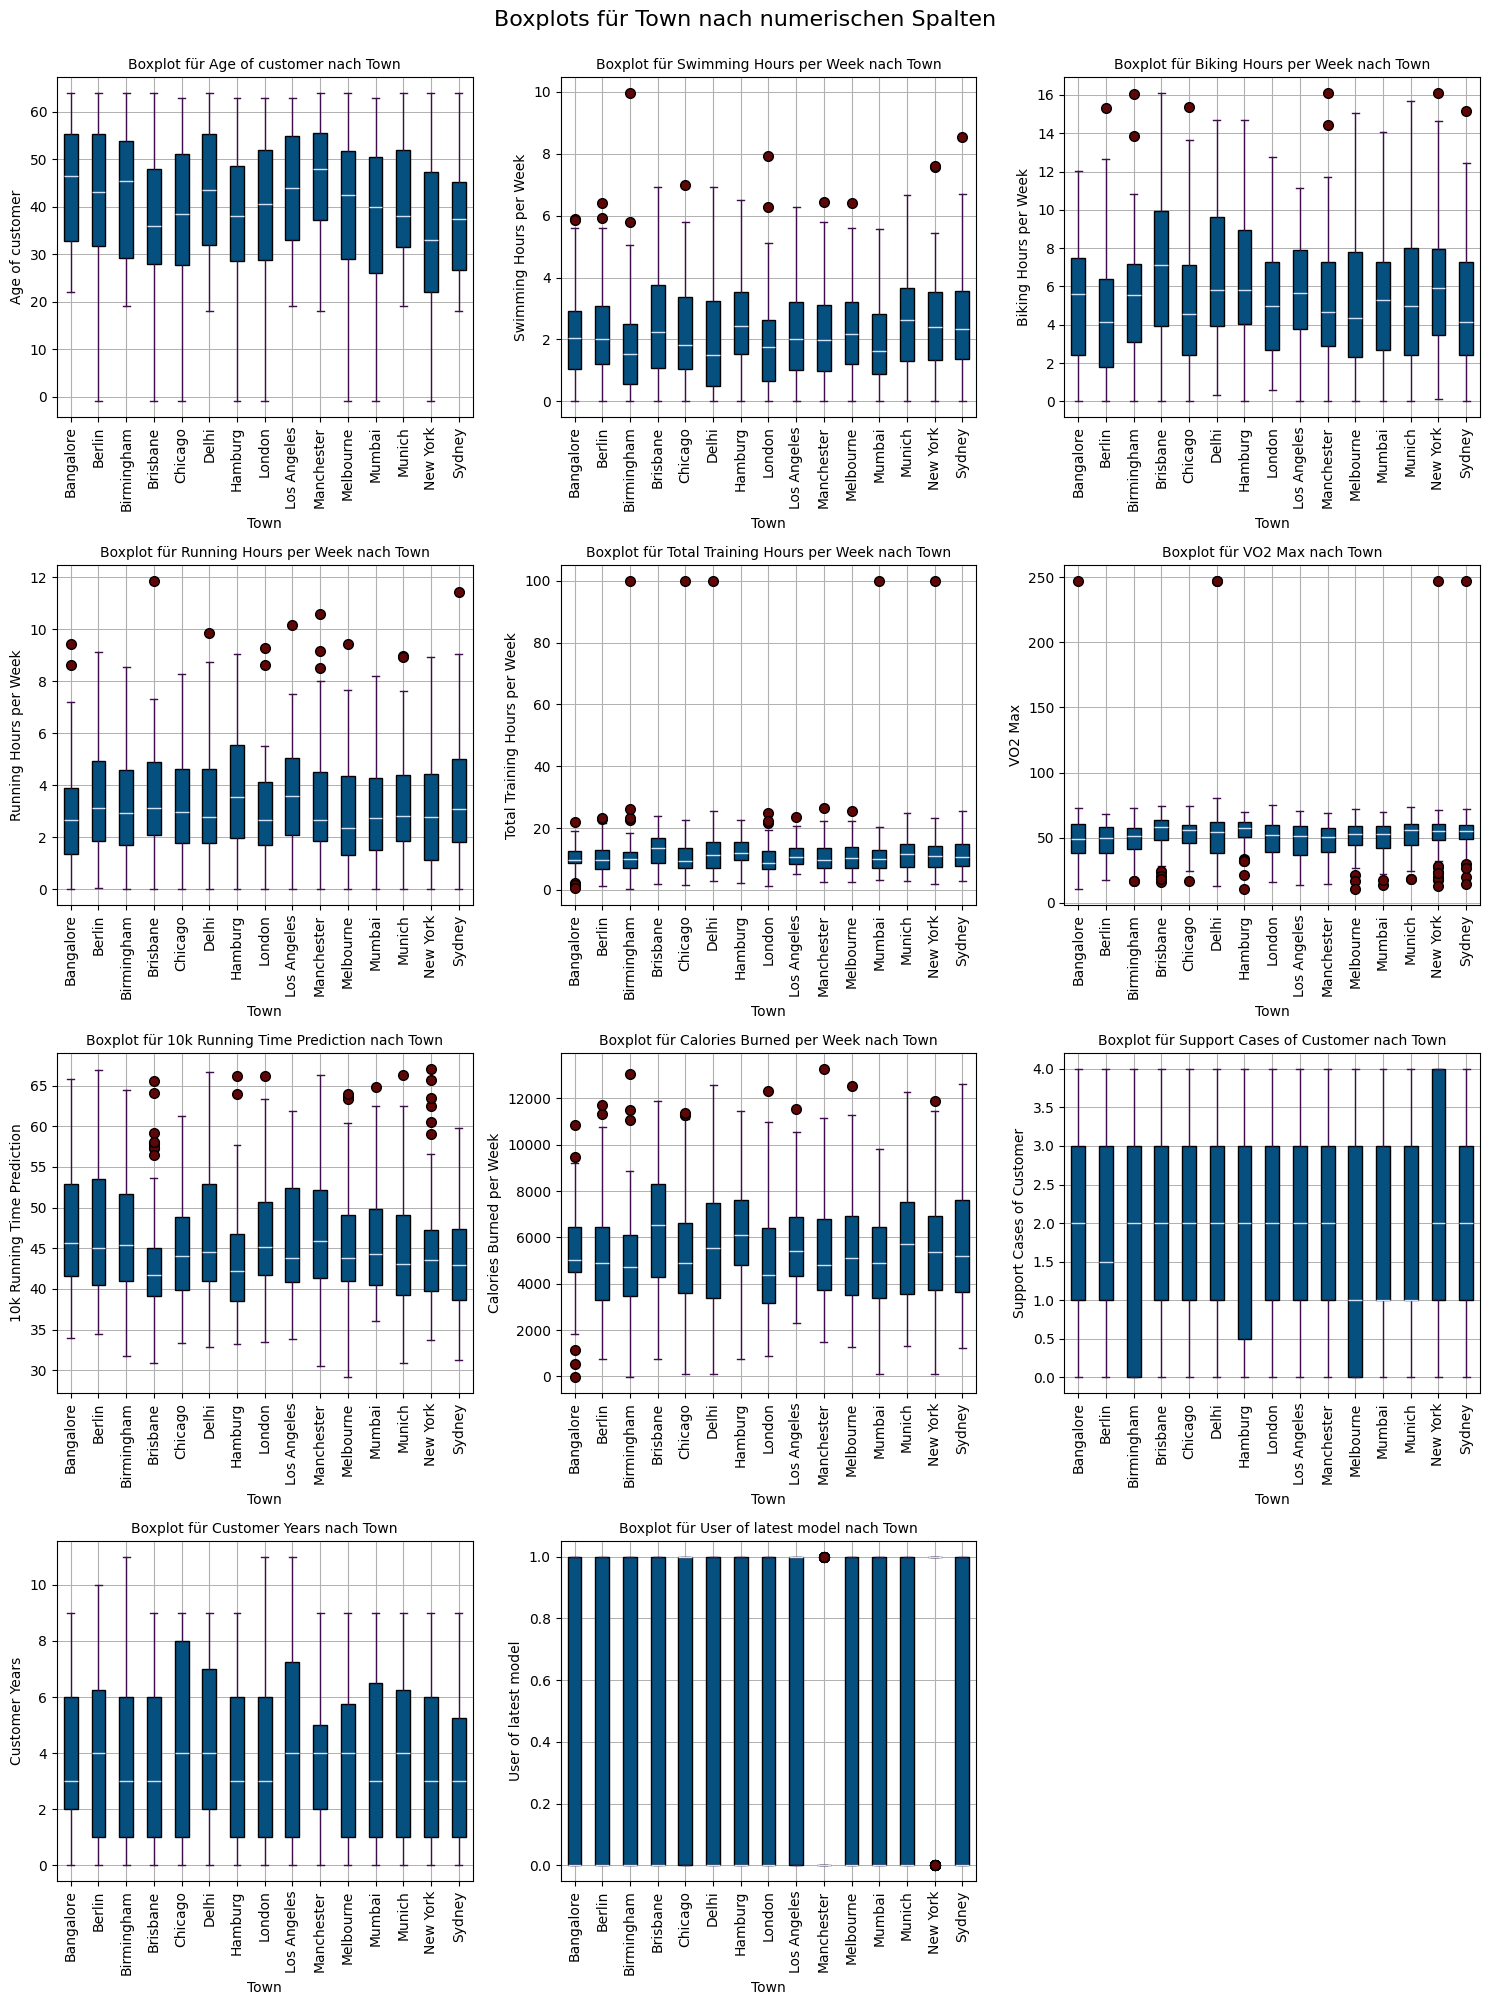

In [676]:
# Boxplots für numerische Spalten nach Town
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

c_col = 'Town'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=col, by=c_col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {col} nach {c_col}", fontsize=10)
    ax.set_xlabel(c_col)
    ax.set_ylabel(col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {c_col} nach numerischen Spalten', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Schwierig zu erkennen.

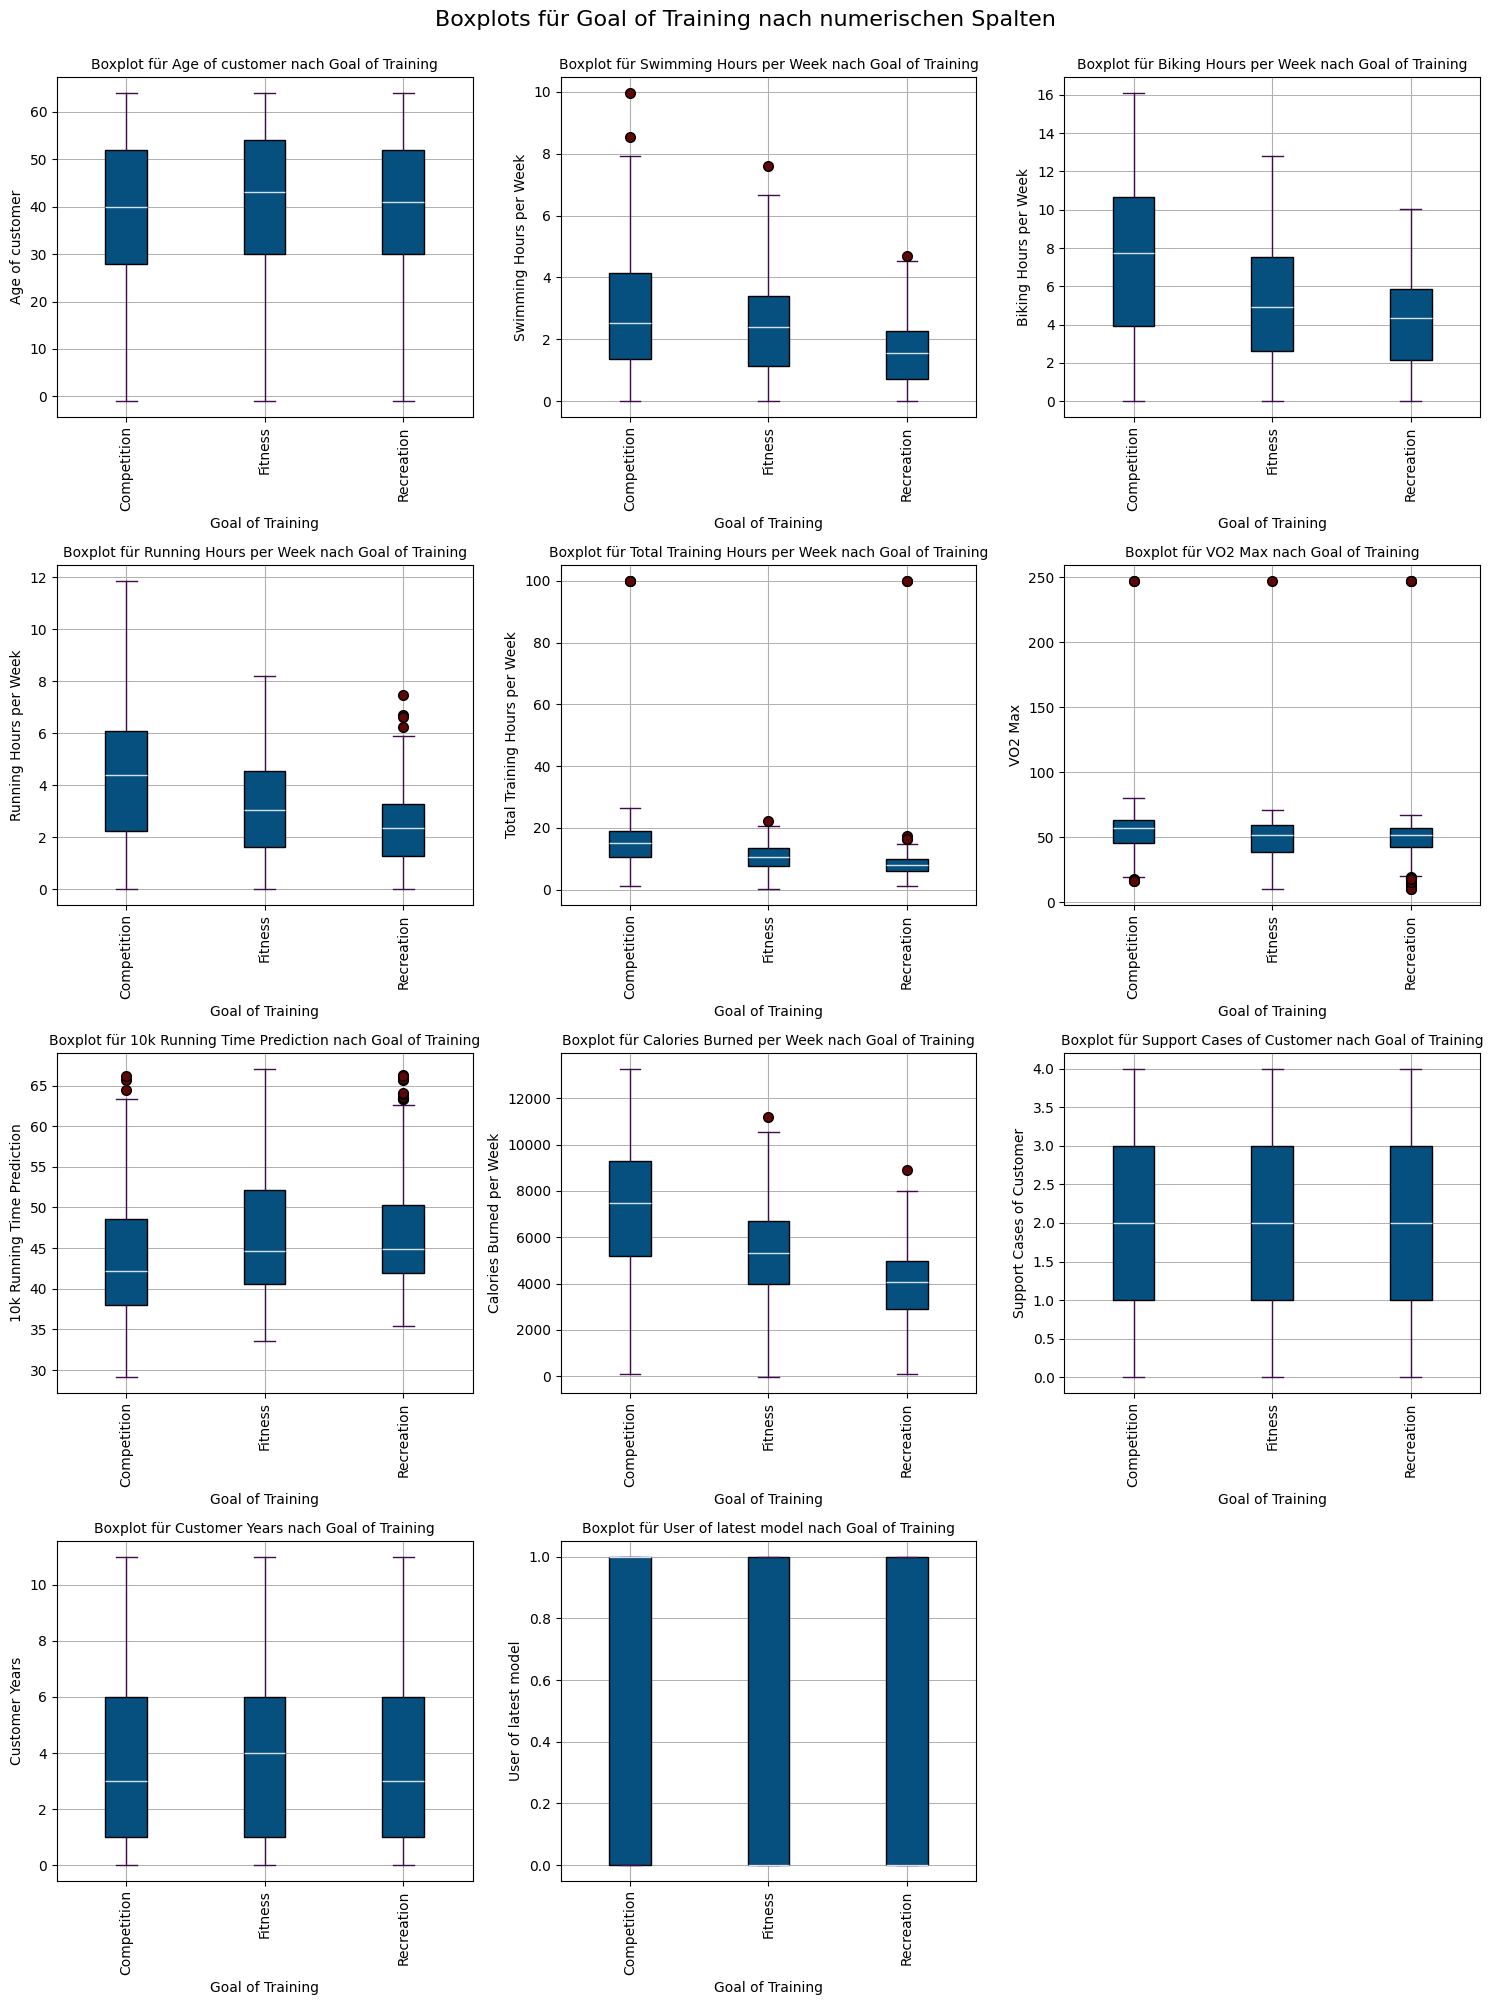

In [677]:
#Boxplots für numerische Spalten nach Goal of Training
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

c_col = 'Goal of Training'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=col, by=c_col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {col} nach {c_col}", fontsize=10)
    ax.set_xlabel(c_col)
    ax.set_ylabel(col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {c_col} nach numerischen Spalten', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Zusammenhang mit den Trainingszeiten, Running Time Prediction und Kalorienverbrauch.

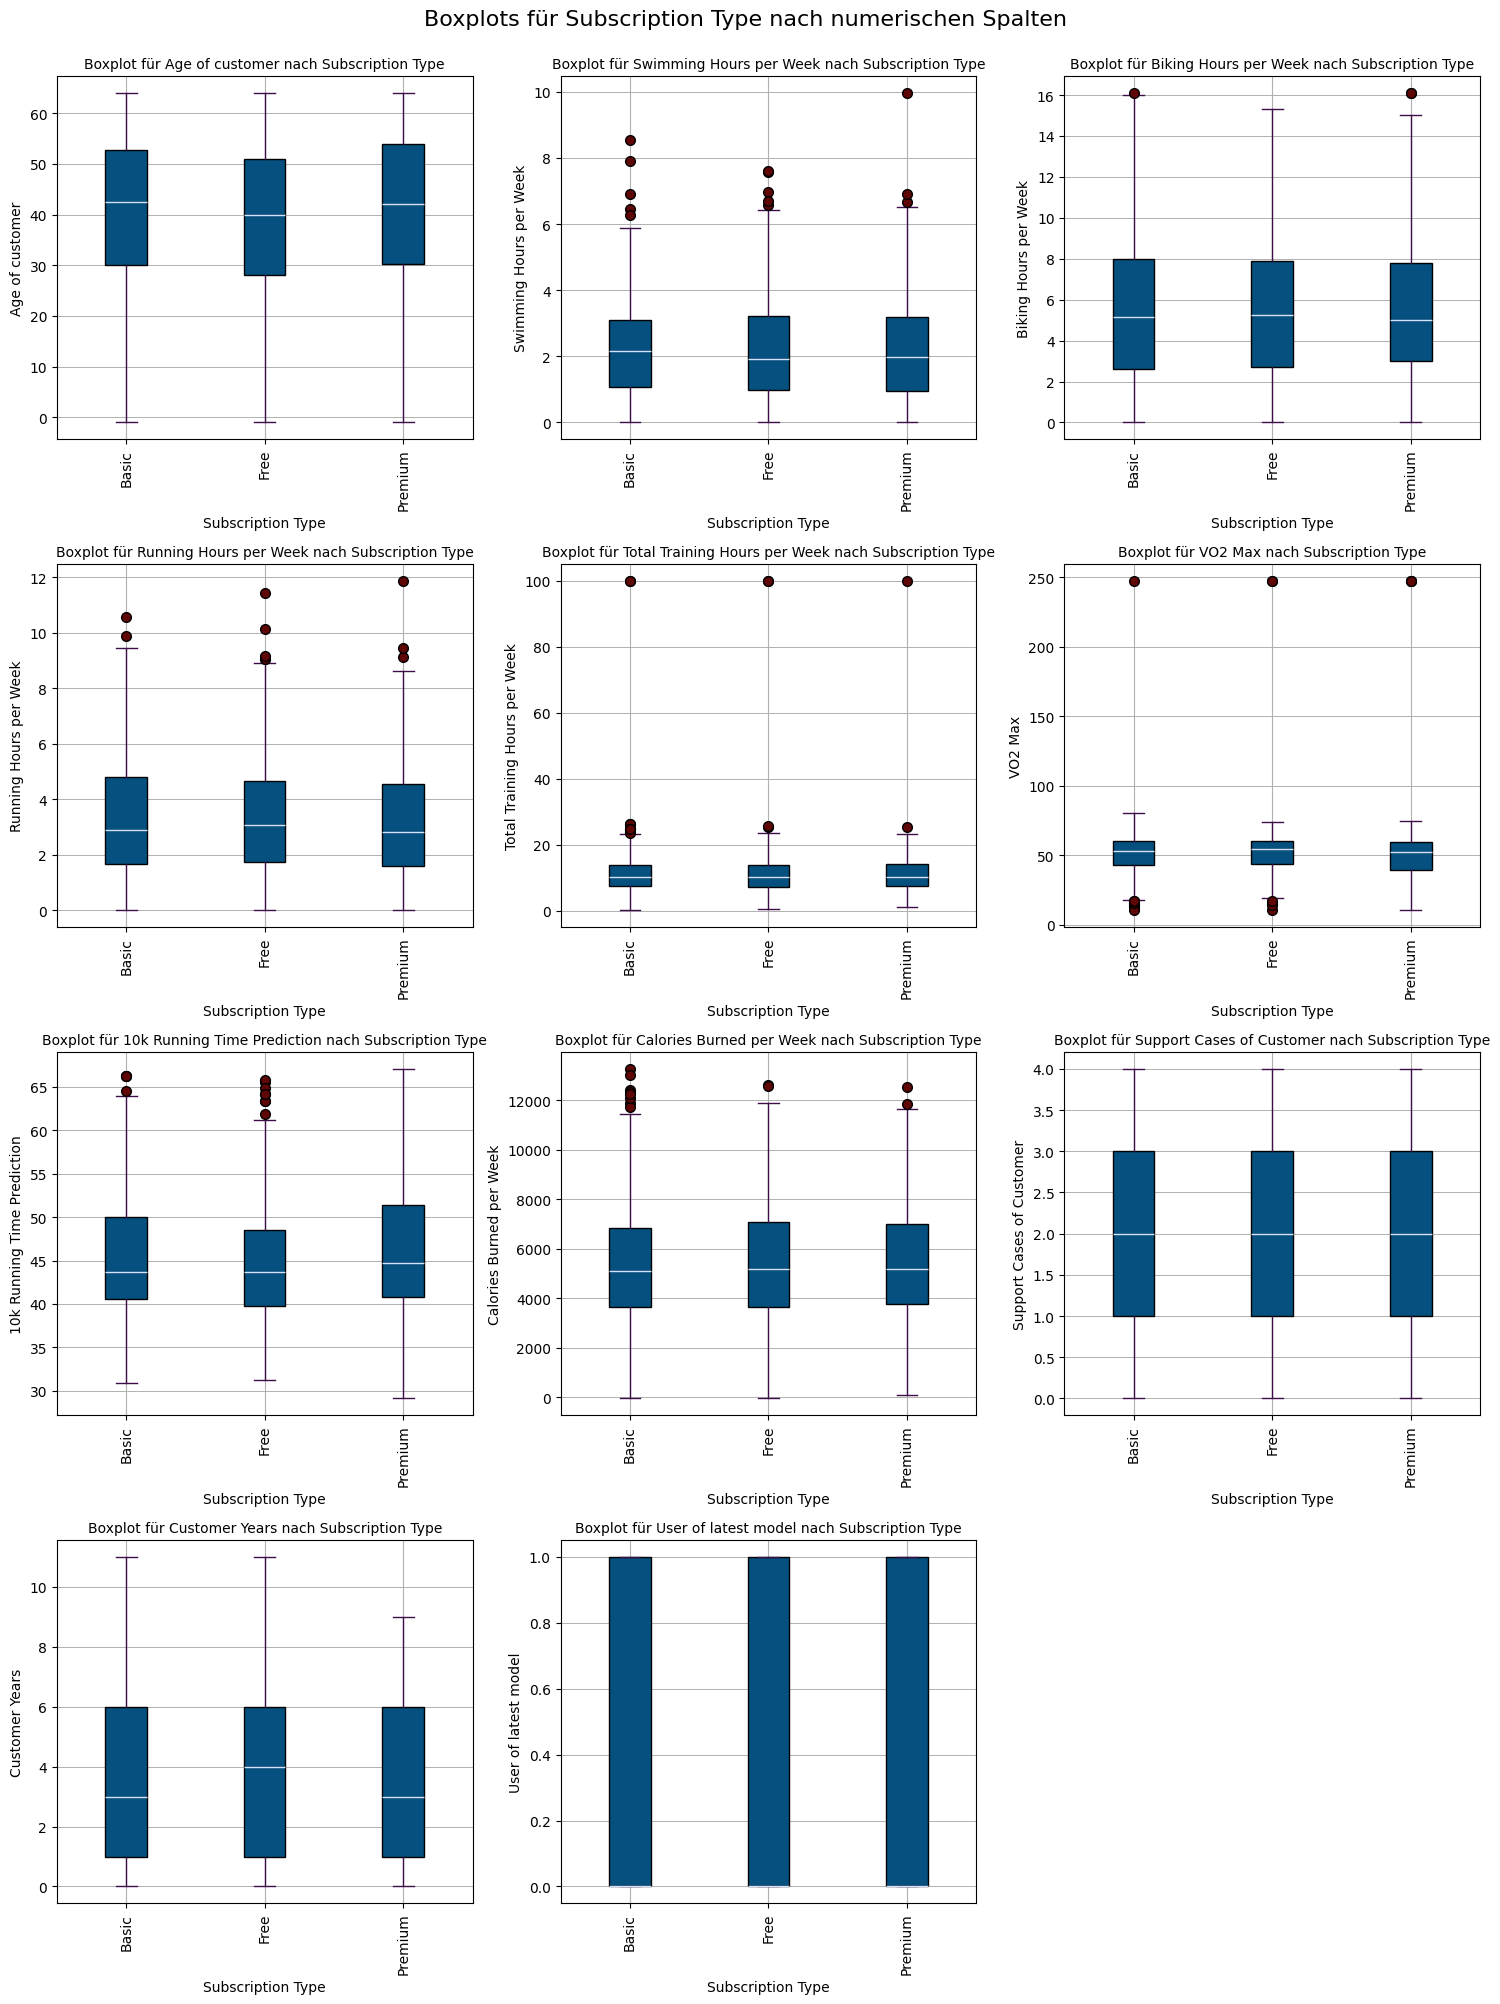

In [678]:
#Boxplots für numerische Spalten nach Subscription Type
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

c_col = 'Subscription Type'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training.boxplot(column=col, by=c_col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {col} nach {c_col}", fontsize=10)
    ax.set_xlabel(c_col)
    ax.set_ylabel(col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {c_col} nach numerischen Spalten', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

Kein deutlicher Zusammenhang.

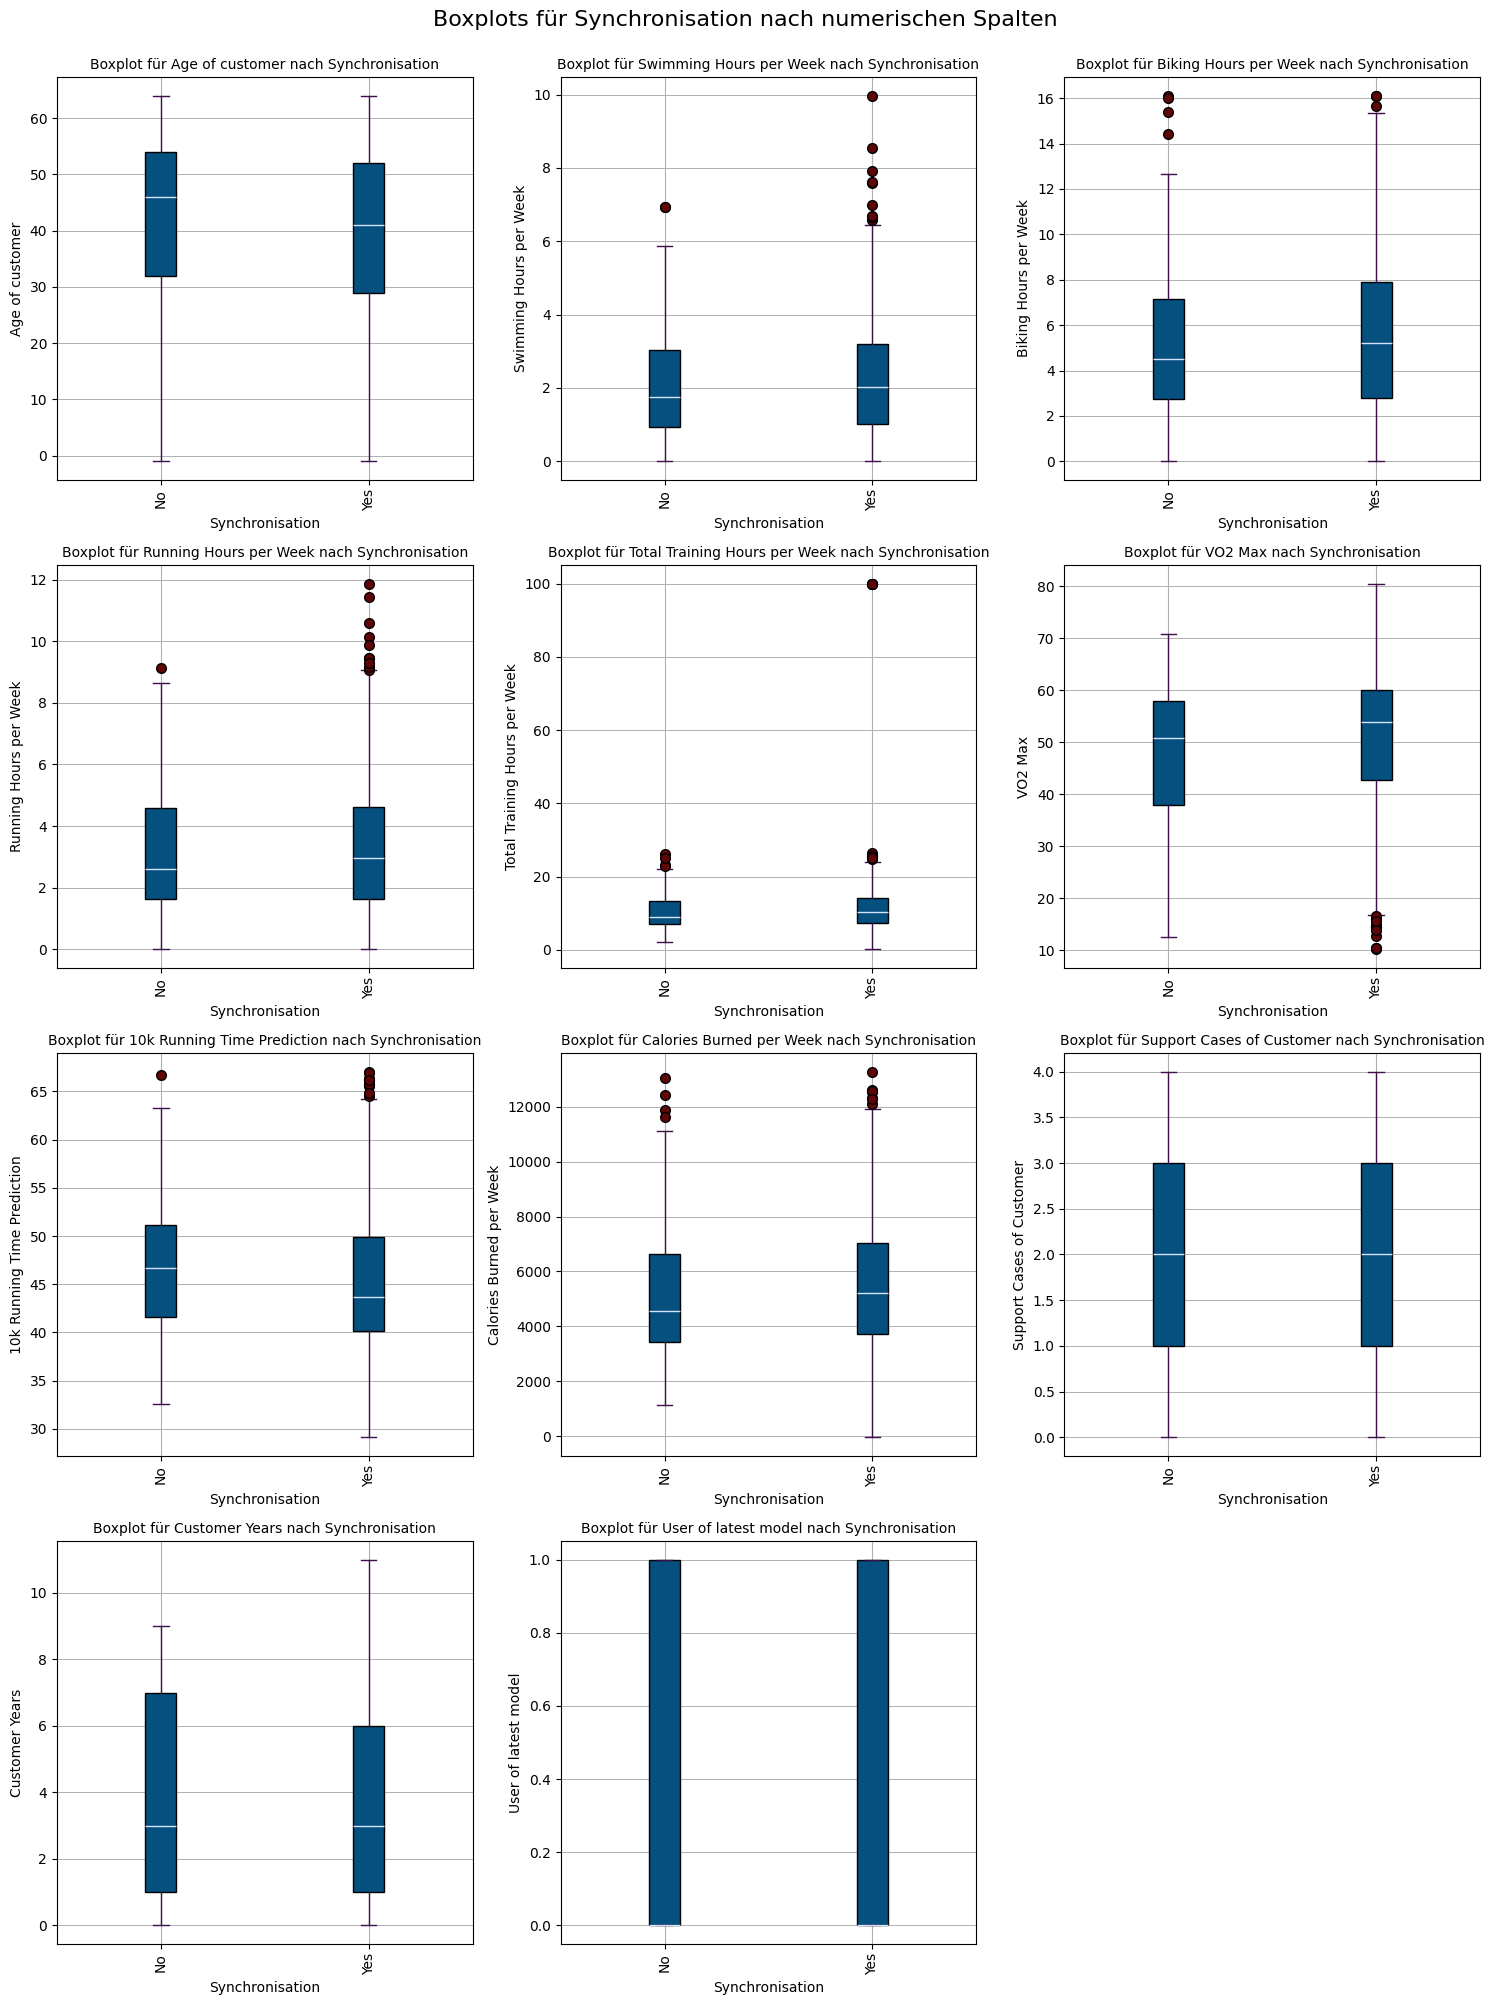

In [679]:
#Boxplots für numerische Spalten nach Syncronisation
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

c_col = 'Synchronisation'

# Durch jede numerische Spalte iterieren und Boxplot für beide Kategorien des Labels erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich

    # Boxplot für die Zielspalte auf der x-Achse (label)
    df_training_filter.boxplot(column=col, by=c_col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))

    # Titel und Achsenbeschriftung anpassen
    ax.set_title(f"Boxplot für {col} nach {c_col}", fontsize=10)
    ax.set_xlabel(c_col)
    ax.set_ylabel(col)
    ax.grid(axis='y', linewidth=0.7)
    ax.tick_params(axis='x', rotation=90)


# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Layout anpassen
plt.tight_layout() 

# Titel für das gesamte Grid
fig.suptitle(f'Boxplots für {c_col} nach numerischen Spalten', fontsize=16, y=1.0)


# Plot anzeigen
plt.show()

In [680]:
# Abschließender ANOVA-Test
# DataFrame für p-Werte erstellen (Zeilen: Labels, Spalten: numerische Features)
anova_p_values = pd.DataFrame(index=target_cat, columns=numerical_cols)

# Schleife über Labels und numerische Features
for c in target_cat:
    for target in numerical_cols:
        # Daten für ANOVA-Test vorbereiten
        data_anova = pd.concat([df_training[target], df_training[c]], axis=1).dropna()
        
        # Gruppen basierend auf den Kategorien im Label
        groups = []
        for category in data_anova[c].unique():
            groups.append(data_anova[data_anova[c] == category][target])
        
        # ANOVA-Test durchführen
        stat, p = f_oneway(*groups)
        anova_p_values.loc[c, target] = p  # p-Wert speichern

# Ergebnisse anzeigen
anova_p_values

Age of customer Swimming Hours per Week  \
Town                              0.000775                0.026343   
Goal of Training                  0.420323                     0.0   
Subscription Type                 0.131568                0.791298   
Preferred Training Daytime        0.152488                0.836727   
Color of Watch                    0.128585                0.473533   
Synchronisation                   0.173918                0.163663   

                           Biking Hours per Week Running Hours per Week  \
Town                                    0.016289               0.500116   
Goal of Training                             0.0                    0.0   
Subscription Type                       0.720861               0.747858   
Preferred Training Daytime              0.384355               0.920121   
Color of Watch                          0.350124               0.974344   
Synchronisation                         0.544046               0.440828   

                           Total Training Hours per Week   VO2 Max  \
Town                                            0.575063  0.093718   
Goal of Training                                     0.0  0.003993   
Subscription Type                               0.915163  0.612321   
Preferred Training Daytime                      0.518292  0.200722   
Color of Watch                                  0.193262  0.763355   
Synchronisation                                 0.179162   0.04146   

                           10k Running Time Prediction  \
Town                                          0.023687   
Goal of Training                                   0.0   
Subscription Type                             0.033884   
Preferred Training Daytime                    0.112589   
Color of Watch                                0.208493   
Synchronisation                               0.065869   

                           Calories Burned per Week Support Cases of Customer  \
Town                                       0.041173                  0.321339   
Goal of Training                                0.0                  0.523253   
Subscription Type                           0.91305                  0.643615   
Preferred Training Daytime                 0.441963                  0.618079   
Color of Watch                             0.944773                  0.730819   
Synchronisation                            0.367411                  0.651893   

                           Customer Years User of latest model  
Town                             0.827494                  0.0  
Goal of Training                 0.380847                  0.0  
Subscription Type                0.315518             0.005463  
Preferred Training Daytime       0.201668             0.135107  
Color of Watch                   0.668403             0.835613  
Synchronisation                   0.89524             0.056122

**Erkenntnisse ANOVA-Test**
- `Town`  
Zusammenhang mit `Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week`
- `Goal of Training`  
Zusammenhang mit `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week`, `Total Training Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week`
- `Subscription Type`  
Zusammenhang mit `10k Running Time Prediction`

### Datenqualität Testdaten

<Axes: >

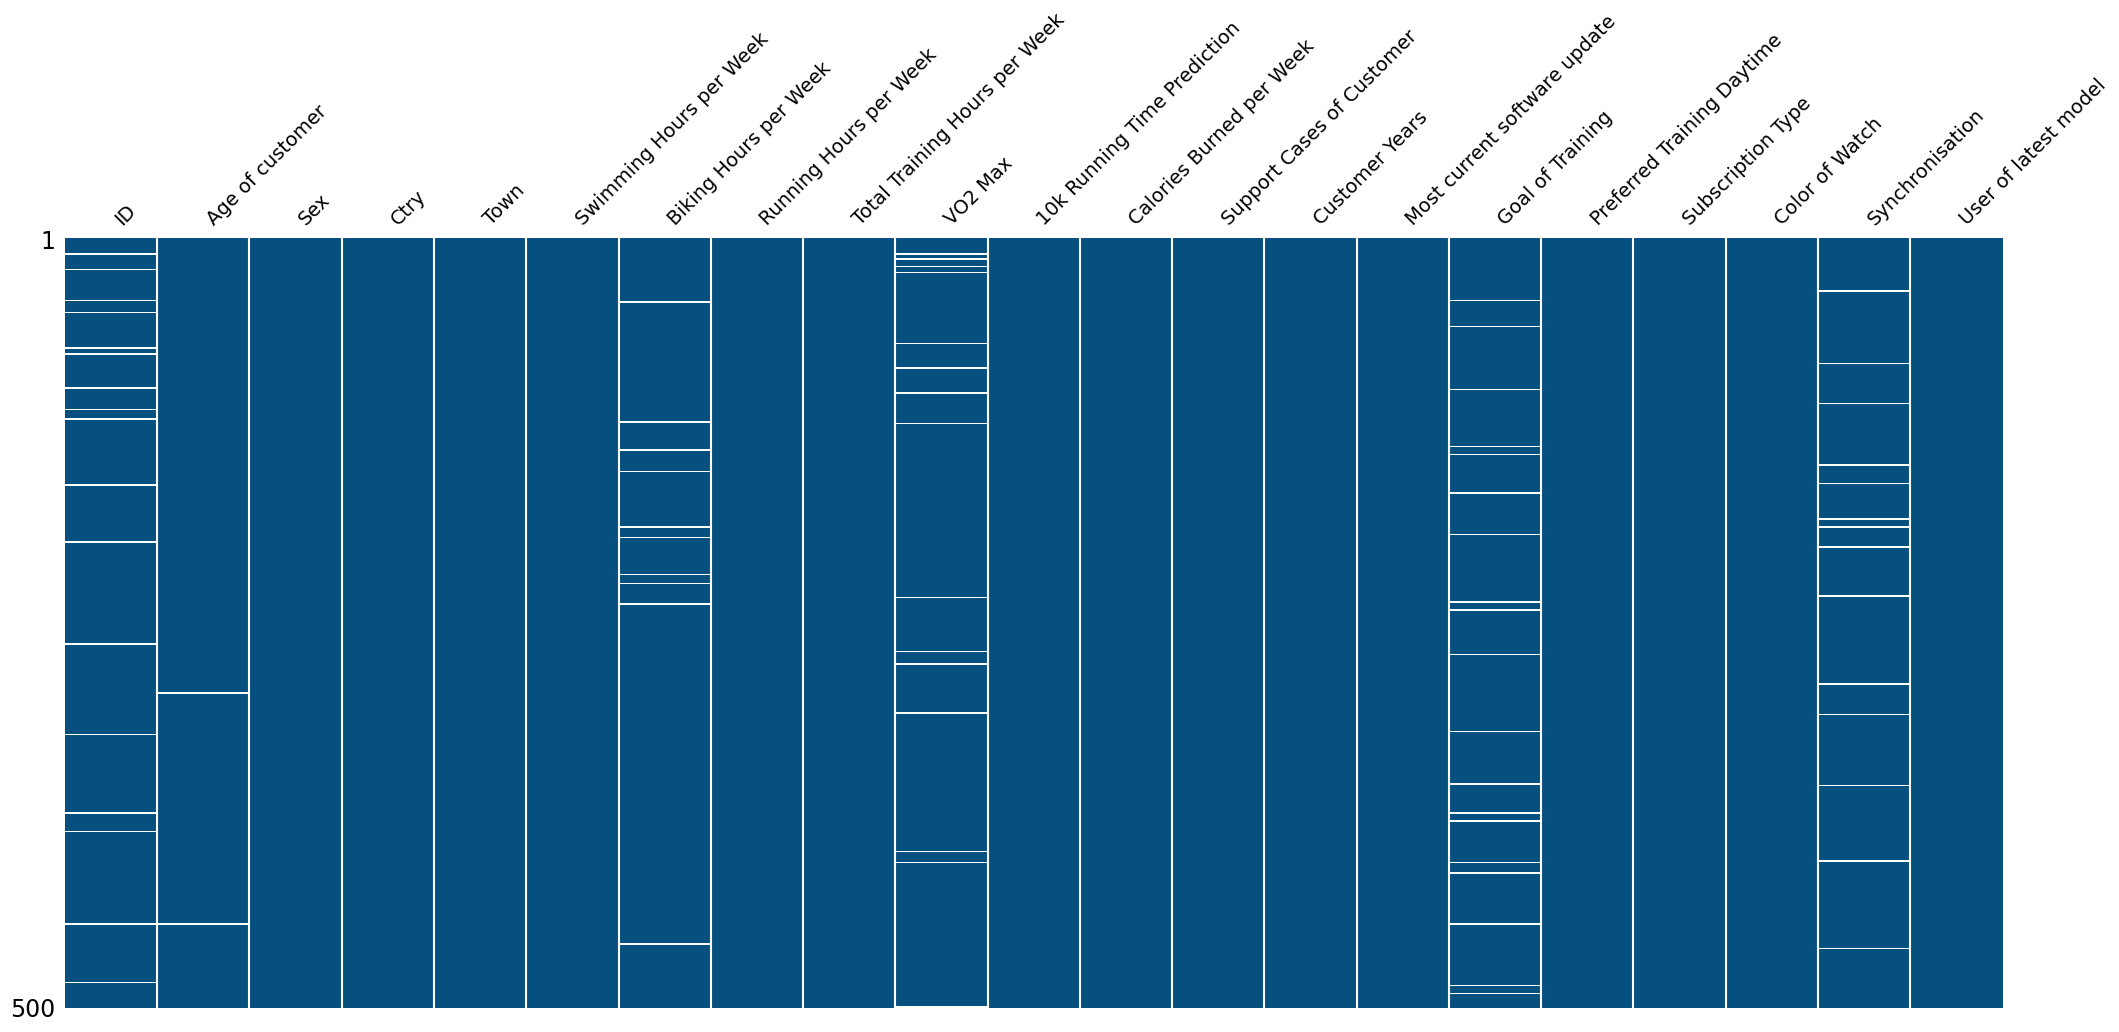

In [681]:
msno.matrix(df_test, color= hex_to_rgb_normalized(color2), fontsize=14, sparkline=False)

- Keine Lücken im Label
- Gehäuft Lücken in der ID &rarr; Nicht ausschlaggebend für Vorhersage
- Übrige Spalten können per Imputation-Vorgehenweise analog Trainingsdaten vervollständigt werden

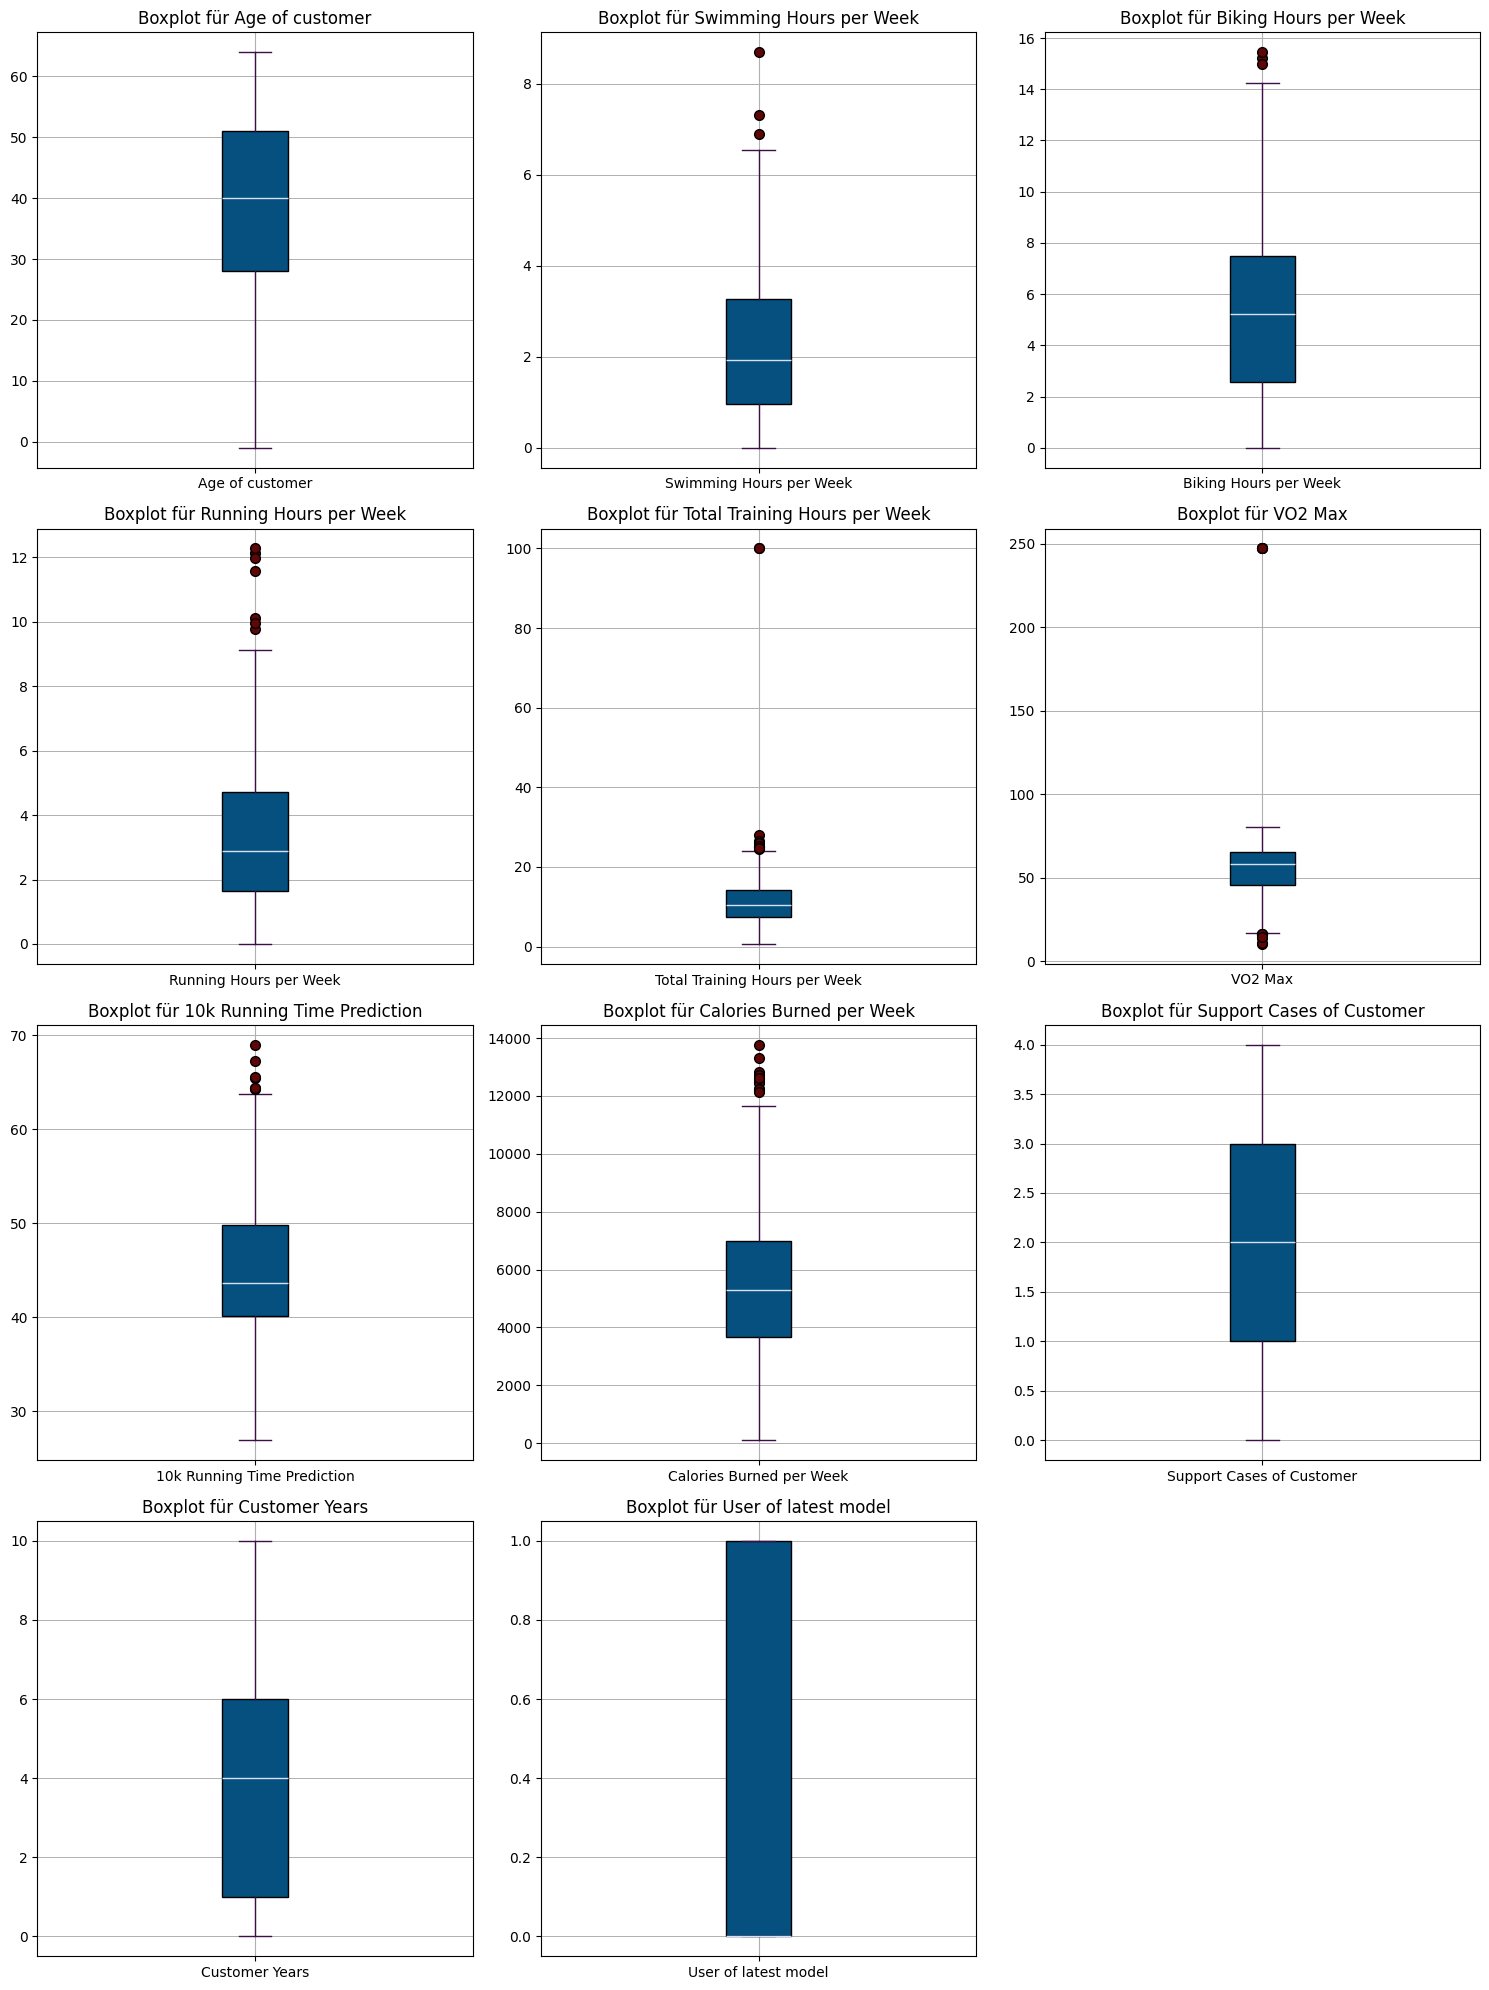

In [682]:
#Boxplots für numerische Spalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(numerical_cols) // ncols) + (len(numerical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede numerische Spalte iterieren und einen Boxplot erstellen
for i, col in enumerate(numerical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    df_test.boxplot(column=col, ax=ax, patch_artist=True, 
                        boxprops=dict(facecolor=color2, color='black'), 
                        whiskerprops=dict(color=color4),
                        flierprops=dict(markerfacecolor=color3, marker='o', markersize=7),
                        capprops=dict(color=color4),
                        medianprops=dict(color=color5))
    ax.set_title(f"Boxplot für {col}")
    ax.grid(axis='y', linewidth=0.7)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

Unplausible Werte für `VO2 Max`, `Age of Customer` und `Total Training Hours per Week` auch in Testdaten vorhanden &rarr; Behandlung notwendig

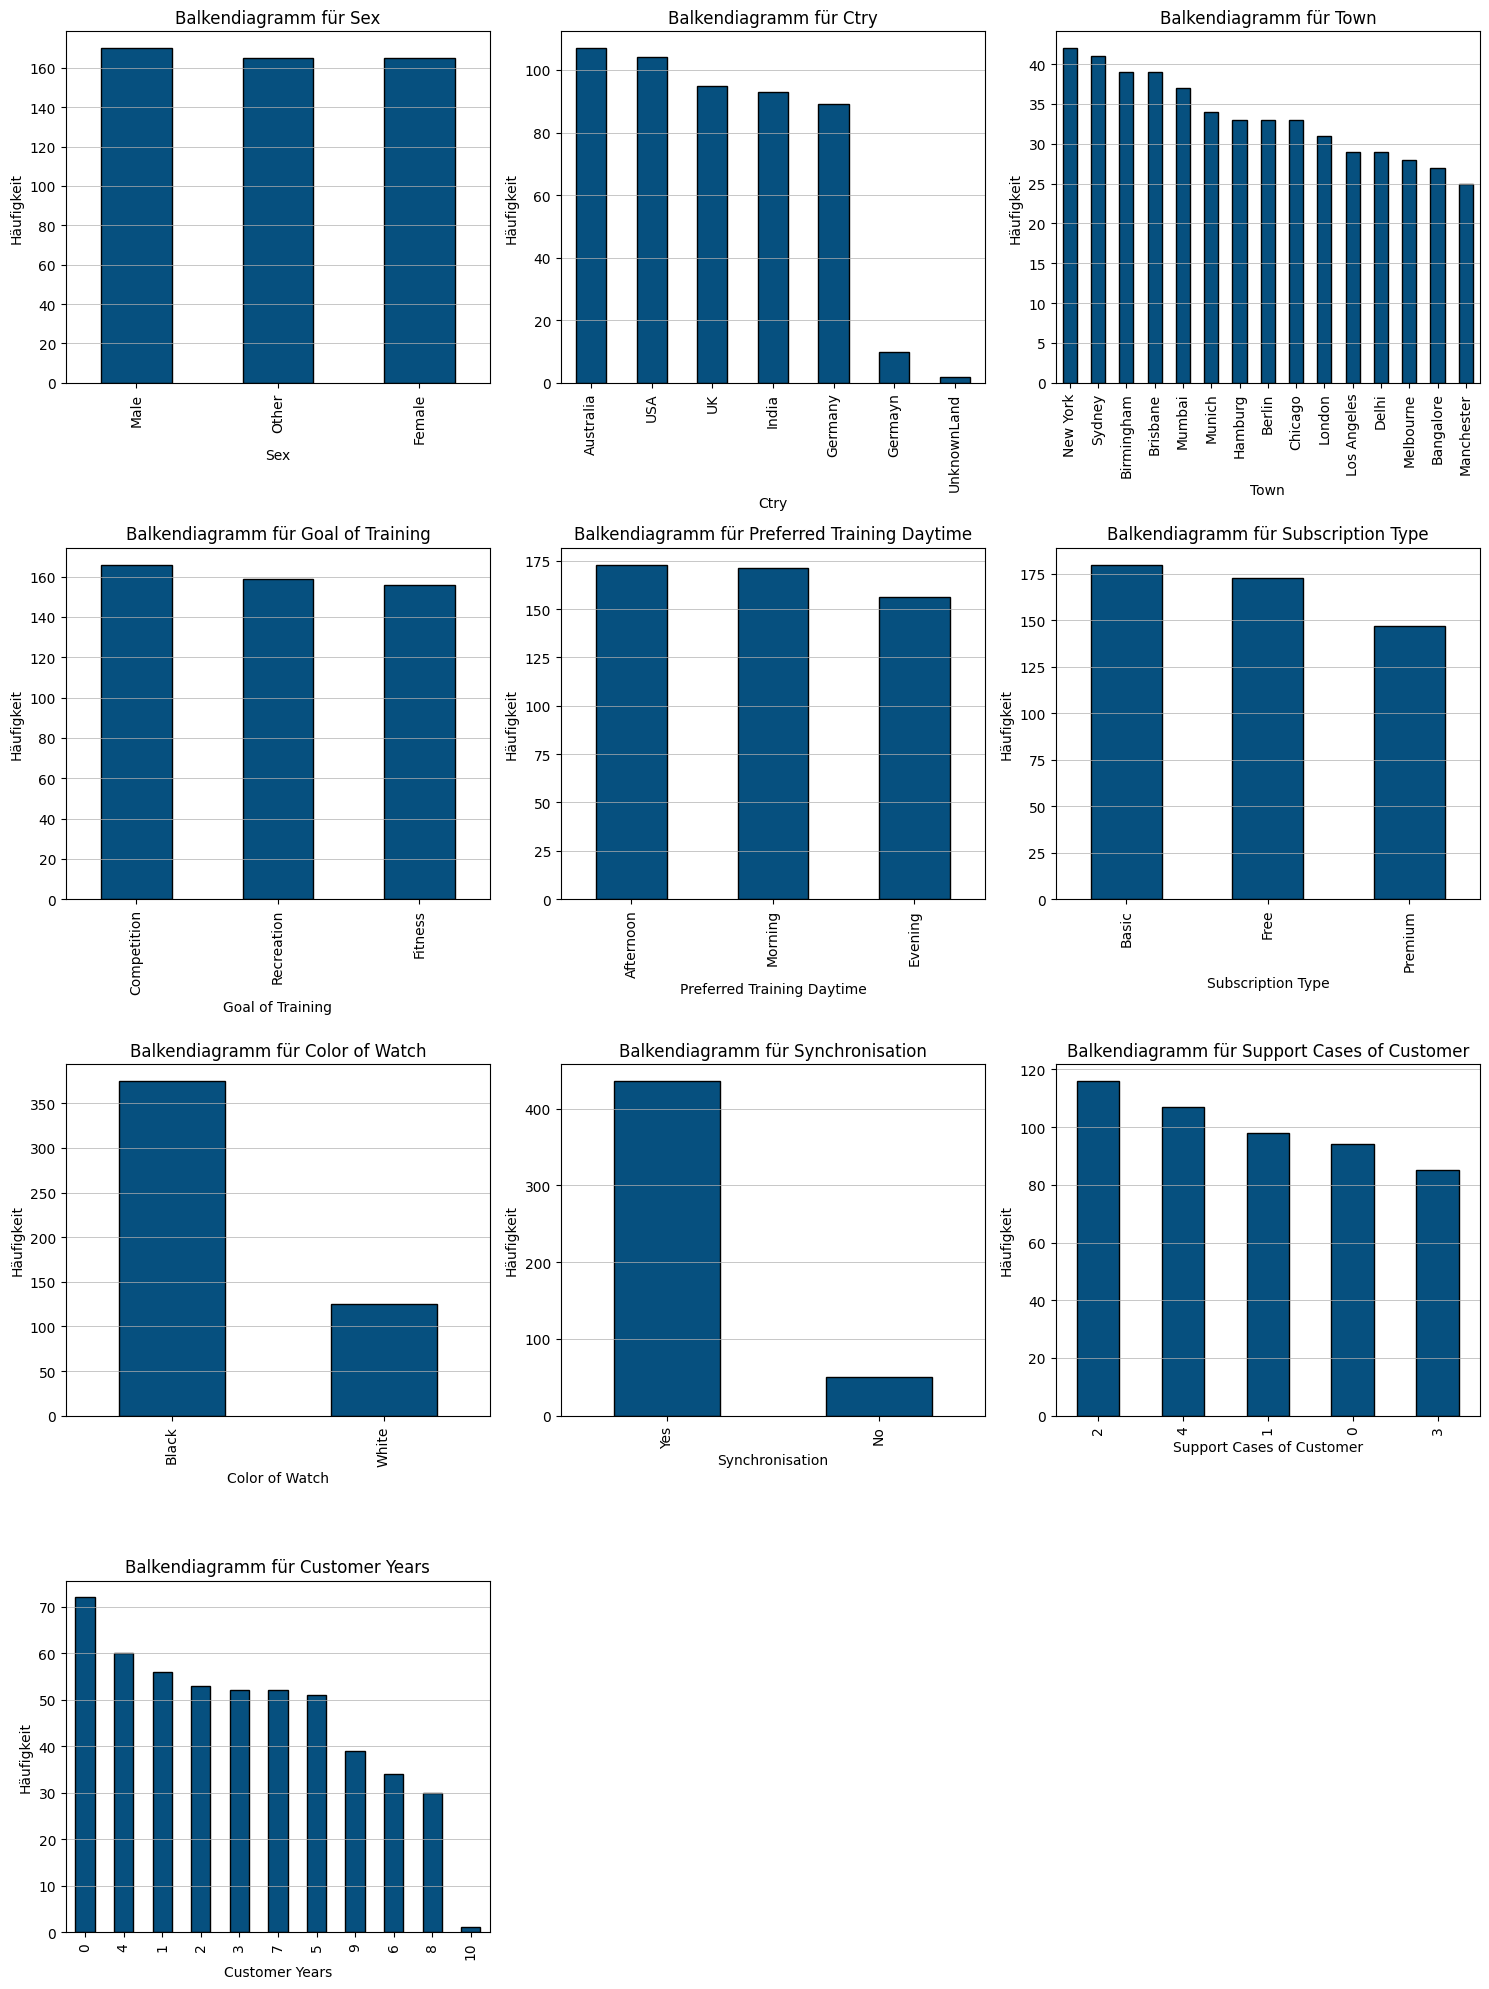

In [683]:
# Balkendiagramme für kategorische Spalten um Einblick in die Häufigkeiten zu erhalten
# Rastergröße festlegen (z.B. 2 Zeilen und so viele Spalten wie benötigt)
ncols = 3  # Anzahl der Spalten im Raster
nrows = (len(categorical_cols) // ncols) + (len(categorical_cols) % ncols > 0)  # Berechnet die notwendige Anzahl an Zeilen

# Subplots erstellen
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))

# Alle Achsen in einer Liste speichern, um sie zu iterieren
axes = axes.flatten()

# Durch jede kategorische Spalte iterieren und Balkendiagramme erstellen
for i, col in enumerate(categorical_cols):
    ax = axes[i]  # Der aktuelle Achsenbereich
    # Häufigkeiten der Kategorien berechnen
    value_counts = df_test[col].value_counts()
    # Balkendiagramm erstellen
    value_counts.plot(kind='bar', ax=ax, color=color2, edgecolor='black')
    ax.set_title(f"Balkendiagramm für {col}")
    ax.set_xlabel(col)
    ax.set_ylabel("Häufigkeit")
    ax.grid(axis='y', linewidth=0.5)

# Überflüssige Subplots ausblenden (falls es mehr Plätze im Raster gibt als Spalten)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Plot anzeigen
plt.tight_layout()  # Layout anpassen
plt.show()

Datenfehler in `Town` mit UnknownLand und Germayn auch enthalten &rarr; Korrektur notwendig

In [684]:
# Überprüfung Duplikate
find_similar_rows(df_test, max_diff=3).sort_values(by='ID')

ID  Age of customer     Sex     Ctry        Town  \
299  C0302             54.0    Male    India       Delhi   
300  C0302             53.0    Male    India       Delhi   
413  C0416             40.0    Male  Germayn      Munich   
414  C0416             39.0    Male  Germayn      Munich   
439  C0441             58.0  Female       UK  Birmingham   
440  C0441             59.0  Female       UK  Birmingham   
463  C0464             27.0    Male  Germany      Munich   
464  C0464             27.0    Male  Germany      Munich   

     Swimming Hours per Week  Biking Hours per Week  Running Hours per Week  \
299                     3.49                   7.36                    1.48   
300                     3.49                   7.36                    1.48   
413                     1.15                   4.92                    1.79   
414                     1.15                   4.92                    1.79   
439                     3.26                   6.37                    3.72   
440                     3.26                   6.37                    3.72   
463                     2.94                   3.41                    6.54   
464                     2.94                   3.41                    6.54   

     Total Training Hours per Week  VO2 Max  10k Running Time Prediction  \
299                          12.34    45.19                        49.21   
300                          12.34    45.19                        49.21   
413                           7.87    56.94                        41.46   
414                           7.87    56.94                        41.46   
439                          13.35    36.45                        53.04   
440                          13.35    36.45                        53.04   
463                          12.89    73.42                        33.29   
464                          12.89    73.42                        33.29   

     Calories Burned per Week  Support Cases of Customer  Customer Years  \
299                   6086.33                          3               7   
300                   6086.33                          3               7   
413                   4102.36                          2               9   
414                   4102.36                          2               9   
439                   6793.96                          4               5   
440                   6793.96                          4               5   
463                   6403.11                          1               9   
464                   6403.11                          1               9   

    Most current software update Goal of Training Preferred Training Daytime  \
299                   2024-09-04       Recreation                  Afternoon   
300                   2024-09-04       Recreation                  Afternoon   
413                   2024-10-07       Recreation                    Morning   
414                   2024-10-07       Recreation                    Morning   
439                   2024-05-28          Fitness                  Afternoon   
440                   2024-05-28          Fitness                  Afternoon   
463                   2024-02-29          Fitness                  Afternoon   
464                   2024-02-29          Fitness                  Afternoon   

    Subscription Type Color of Watch Synchronisation  User of latest model  
299             Basic          Black             Yes                     0  
300             Basic          Black             Yes                     0  
413             Basic          Black             Yes                     0  
414             Basic          Black             Yes                     0  
439              Free          Black             Yes                     0  
440              Free          Black             Yes                     0  
463             Basic          Black             Yes                     0  
464             Basic          Black            

4 Duplikate vorhanden in den Testdaten.

### Zusammenfassung

**Trainingsdaten - Data Quality**
1. Löschen der 22 Zeilen, in denen das Label 0 ist.
2. Löschen der 7 Zeilen mit der doppelten ID.
3. Umbennung Germayn zu Germany in Spalte `Ctry` 
4. Anpassung UnknownLand in Spalte `Ctry`
5. Berechnung der fehlenden Werte für `Biking Hours per Week` durch `Total Training Hours per Week` - `Swimming Hours per Week` -  `Running Hours per Week` (Aureißer bei der Gesamttrainingszeit betreffen hier nicht die fehlenden Wert für Biking Hours) (*Rule based Imputation*)
6. Unplausible und fehlende Werte für `Total Training Hours per Week` durch andere Spalten berechnen lassen und ersetzen. (*Rule based Imputation*)
7. Setzen der unplausiblen Werte von `VO2 Max` und `Age of Customer` auf NaN.  
8. Löschung Feature `Color of Watch`, `Prefered Training Datetime` aufgrund fehlendem Zusammenhang mit Label und anderen Daten

**Trainingsdaten - Feature Engineering**  
`Most current software update` umwandeln zu `Days since Update`

**Trainingsdaten - Imputation**  
1. 1 Fehlender Wert in `Days since Update` befüllen mit dem Mittelwert je Label, aufgrund fehlendem Zusammenhang mit anderen Daten
2. 1 Fehlender Wert in `Subscription Type` mit Hilfe Informationen `10k Running Time Prediction` befüllen (*Regression Imputation*)
3. 10 falsche Werte in `Age of Customer`  mit Hilfe folgender Spalten befüllen: `10k Running Time Prediction`, `Ctry`, `Support Cases of Customer`, `Customer Years` (*Regression Imputation*)
4. 19 Fehlende Werte in `Calories Burned per Week` mit Hilfe folgender Spalten befüllen: `Sex`, `Biking Hours per Week`, `Total Training Hours per Week`, `Swimming Hours per Week`, `Running Hours per Week` (Hauptsache Fahrradzeiten, andere Zeiten eher weniger relevant) (*Regression Imputation*)
5. 28 Fehlende Werte in `Goal of Training` mit Hilfe folgender Spalten befüllen: `Swimming Hours per Week`, `Biking Hours per Week`, `Running Hours per Week`, `Total Training Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week` (*Regression Imputation*)
6. 10 Fehlende Werte in `VO2 Max` mit Hilfe folgender Spalten befüllen: `Goal of Training`, `10k Running Time Prediction`, `Calories Burned per Week`, `Age of customer`
7. 27 Fehlende Werte in `Synchronisation` mit Hilfe folgender Spalten befüllen: `VO2 Max` (*Regression Imputation*)
8. 39 Fehlende Werte in Town in einer Kombination aus *Regression Imputation* und *Rule based Imputation*: Erst einschränken, welche Auswahl an Städten möglich ist anhand von `Ctry`. Dann anhand folgender Werte bestimmen, welches aus den möglichen Städten die wahrscheinlichste ist: `Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`, `10k Running Time Prediction`, `Calories Burned per Week`  

**Trainingsdaten - Transformation**  
- Keine der Daten sind komplett normalverteilt (`10k Running Time Prediction`, `Calories Burned per Week` nahezu normalverteilt, aber laut Shapiro-Wilk eben nicht ganz)
- Linksschiefe Spalten:  
`VO2 Max` (nach Bereinigung Ausreißer), 
- Gleichverteilte Spalten:  
`Age of customer`, `Support Cases of Customer`, `Days since Update`
- Rechtsschiefe Spalten:  
`Biking Hours per Week`, `Total Training Hours per Week`, `Swimming Hours per Week`, `Running Hours per Week`, `Customer Years`  

**Trainingsdaten - Feature Selection**  
- Tendenziell hoher Zusammenhang mit Label:  
`Age of customer`, `Swimming Hours per Week`, `Biking Hours per Week`,`Running Hours per Week`, `Total Training Hours per Week`, `VO2 Max`, `10k Running Time Prediction`, `Calories Burned per Week`, `Support Cases of Customer`, `Customer Years`, `Ctry`, `Town`,  `Goal of Training`, `Subscription Type`, `Support Cases of Customer`, `Customer Years`
- Tendenziell niedriger Zusammenhang mit Label:  
`Days since Update` (`Most current software update`), `Synchronisation`, `Sex`
- Eher kein Zusammenhang mit Label:  
`Color of Watch`, `Prefered Training Datetime`

**Testdaten - Datenqualität**  
Gleiche Probleme wie in den Trainingsdaten.
